In [1]:
# %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, r2_score, mean_absolute_error, mean_squared_error,
    auc
)

# Configuration esthétique pour les graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
import mlflow
from scipy import stats
import math
from equipy.fairness import FairWasserstein
from equipy.metrics import unfairness
from scipy.stats import kstest, ks_2samp, norm
from tqdm import tqdm
import matplotlib.patches as mpatches
from scipy.stats import kstest

#Import useful functions
from Models_and_Metrics import *


__Functions__

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator

def plot_unfairness_decomposition(results_dict, param_name, param_name_legend,output_file, figsize=(6, 4), dpi=300):
    """
    Plot unfairness decomposition as stacked bars for varying parameter values.
    
    Parameters:
    -----------
    results_dict : dict
        Dictionary with results for each parameter value
    param_name : str
        Name of the parameter that varies (e.g., 'T_correl')
    output_file : str
        Path to save the output figure
    figsize : tuple
        Figure size (width, height) in inches
    dpi : int
        Resolution for the saved figure
    """
    # Set style for scientific publication
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Use colorblind palette
    palette = sns.color_palette("colorblind")
    
    # Create figure with higher quality settings
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Extract parameter values and prepare data
    param_values = sorted(results_dict.keys())
    
    # Components to plot
    components = ['direct_mean_bias_mean', 'indirect_structural_bias_mean', 'indirect_mean_bias_mean', 'interaction_mean']
    component_labels = ['Direct Mean Bias', 'Indirect Structural Bias', 'Indirect Mean Bias', 'Interaction']
    
    # Create data structure for plotting
    data = []
    for param_val in param_values:
        result = results_dict[param_val]['y_input_reg']
        row = [param_val]
        for comp in components:
            row.append(result[comp])
        data.append(row)
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=[param_name] + components)
    
    # Set width of bars
    bar_width = 0.7
    
    # Plot stacked bars
    bottom = np.zeros(len(param_values))
    for i, comp in enumerate(components):
        values = df[comp].values
        ax.bar(df[param_name], values, bottom=bottom, width=bar_width,
               label=component_labels[i], color=palette[i], 
               edgecolor='black', linewidth=0.5)
        bottom += values
    
    # Add total unfairness as a line
    df['total'] = df[components].sum(axis=1)
    ax.plot(df[param_name], df['total'], 'k--', marker='o', markersize=5, 
            linewidth=1.5, label='Total Unfairness')
    
    # Customize plot for scientific publication
    ax.set_xlabel(f'{param_name_legend}', fontsize=15, fontweight='bold')
    ax.set_ylabel('Unfairness', fontsize=15, fontweight='bold')
    ax.tick_params(axis='both', labelsize=15)
    
    # Ensure x-axis shows all integer values
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Add grid only for y-axis
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend with clear formatting
    legend = ax.legend(fontsize=9, frameon=True, fancybox=False, 
                      edgecolor='black', ncol=1, loc='upper left', 
                      bbox_to_anchor=(1.02, 1))
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(output_file, bbox_inches='tight')
    
    return fig


In [3]:
# def generate_synthetic_data(nb_features, nb_obs, tho, additional_s, t_unfair, p_mu_bias, p_sigma_bias, t_correl, random_seed):
#     # Set random seed if provided
#     if random_seed is not None:
#         np.random.seed(random_seed)

#     # Simulation of S
#     param = {}
#     param['q'] = 1 - norm.pdf(tho, loc=0, scale=1)
#     param['S'] = np.random.binomial(1, param['q'], (nb_obs)) + 1 + additional_s * np.random.binomial(1, param['q'], (nb_obs))
#     data = pd.DataFrame({"S": param['S']})

#     # Generate means for each group
#     n_binomial, p_binomial = 3, np.random.uniform(low=0.0, high=1.0, size=nb_features)
#     mu_1, mu_2 = np.zeros(nb_features), np.zeros(nb_features)
    
#     if p_mu_bias == 0: 
#         mu_1 += np.random.binomial(n_binomial, p_binomial, nb_features)
#         mu_2 = mu_1
#     else:
#         p_binomial_1 = np.random.uniform(low=0.0, high=1.0, size=nb_features)
#         mu_1 += np.random.binomial(n_binomial, p_binomial_1, nb_features)
#         p_binomial_2 = np.random.uniform(low=0.0, high=1.0, size=nb_features)
#         mu_2 += p_mu_bias * np.random.binomial(n_binomial, p_binomial_2, nb_features)
    
#     # Generate covariance matrices for each group
#     if t_correl == 0:
#         # Independent features case (diagonal covariance)
#         if p_sigma_bias == 0:
#             std_1 = np.random.uniform(low=0.0, high=2.0) * np.ones(nb_features)
#             std_2 = std_1
#             cov_1 = np.diag(std_1**2)
#             cov_2 = np.diag(std_2**2)
#         else:
#             std_1 = np.random.uniform(low=0.0, high=2.0, size=nb_features)
#             std_2 = p_sigma_bias * np.random.uniform(low=0.0, high=2.0, size=nb_features)
#             cov_1 = np.diag(std_1**2)
#             cov_2 = np.diag(std_2**2)
#     else:
#         # Correlated features case
#         # Generate base diagonal matrices
#         if p_sigma_bias == 0:
#             std_1 = np.random.uniform(low=0.0, high=2.0) * np.ones(nb_features)
#             std_2 = std_1
#         else:
#             std_1 = np.random.uniform(low=0.0, high=2.0, size=nb_features)
#             std_2 = p_sigma_bias * np.random.uniform(low=0.0, high=2.0, size=nb_features)
        
#         # Create diagonal matrices
#         diag_1 = np.diag(std_1**2)
#         diag_2 = np.diag(std_2**2)
        
#         # Generate random correlation matrices
#         A_1 = np.random.normal(0, 1, (nb_features, nb_features))
#         corr_1 = A_1.T @ A_1
#         corr_1 = corr_1 / np.outer(np.sqrt(np.diag(corr_1)), np.sqrt(np.diag(corr_1)))
        
#         if t_correl == 1:  # Same correlation structure for both groups
#             corr_2 = corr_1
#         else:  # Different correlation structures
#             A_2 = np.random.normal(0, 1, (nb_features, nb_features))
#             corr_2 = A_2.T @ A_2
#             corr_2 = corr_2 / np.outer(np.sqrt(np.diag(corr_2)), np.sqrt(np.diag(corr_2)))
        
#         # Apply correlation strength t_correl
#         # corr_1 = (1 - t_correl) * np.eye(nb_features) + t_correl * corr_1
#         # corr_2 = (1 - t_correl) * np.eye(nb_features) + t_correl * corr_2
        
#         # Convert correlation matrices to covariance matrices
#         cov_1 = np.sqrt(diag_1) @ corr_1 @ np.sqrt(diag_1)
#         cov_2 = np.sqrt(diag_2) @ corr_2 @ np.sqrt(diag_2)
    
#     # Generate X conditionally on S using the covariance matrices
#     X_all = np.zeros((nb_obs, nb_features))
#     indices_1 = data.index[data['S'] == 1].tolist()
#     indices_2 = data.index[data['S'] == 2].tolist()
    
#     param['X_1'] = np.random.multivariate_normal(mean=mu_1, cov=cov_1, size=len(indices_1))
#     X_all[indices_1] = param['X_1']
#     param['X_2'] = np.random.multivariate_normal(mean=mu_2, cov=cov_2, size=len(indices_2))
#     X_all[indices_2] = param['X_2']

#     # Add X columns to the dataframe
#     for j in range(nb_features):
#         data[f'X_{j}'] = X_all[:, j]

#     # Calculate Y as sum of X features plus t*S
#     Y = np.sum(X_all, axis=1) + t_unfair * data['S'].values
#     data['Y'] = Y

#     # Reset random seed to avoid affecting other code
#     if random_seed is not None:
#         np.random.seed(None)
    
#     return data, param


In [4]:
def generate_synthetic_data(nb_features, nb_obs, tho, additional_s, t_unfair, p_mu_bias, p_sigma_bias, t_correl, random_seed):
    """Generate syntetic dataset

    Args:
        nb_features (_type_): _description_
        nb_obs (_type_): _description_
        tho (_type_): _description_
        additional_s (_type_): _description_
        t_unfair (_type_): _description_
        p_mu_bias (_type_): _description_
        p_sigma_bias (_type_): _description_
        t_correl (_type_): _description_
        random_seed (_type_): _description_

    Returns:
        _type_: _description_
    """
    # Set random seed if provided
    if random_seed is not None:
        np.random.seed(random_seed)

    # Simulation of S
    param = {}
    param['q'] = 1 - norm.pdf(tho, loc=0, scale=1)
    param['S'] = np.random.binomial(1, param['q'], (nb_obs)) + 1 + additional_s * np.random.binomial(1, param['q'], (nb_obs))
    data = pd.DataFrame({"S": param['S']})

    # Generate means for each group
    n_binomial, p_binomial = 3, np.random.uniform(low=0.0, high=1.0, size=nb_features)
    mu_1, mu_2 = np.zeros(nb_features), np.zeros(nb_features)
    
    if p_mu_bias == 0: 
        mu_1 += np.random.binomial(n_binomial, p_binomial, nb_features)
        mu_2 = mu_1
    else:
        # Générer des moyennes indépendantes pour chaque dimension
        # pour éviter d'introduire des corrélations artificielles
        p_binomial_1 = np.random.uniform(low=0.0, high=1.0, size=nb_features)
        mu_1 += np.random.binomial(n_binomial, p_binomial_1, nb_features)
        
        # Pour mu_2, on peut soit:
        # 1. Ajouter un décalage constant à mu_1
        mu_2 = mu_1 + p_mu_bias * np.ones(nb_features)
        # OU 2. Générer des moyennes indépendantes avec un facteur d'échelle
        # p_binomial_2 = np.random.uniform(low=0.0, high=1.0, size=nb_features)
        # mu_2 += p_mu_bias * np.random.binomial(n_binomial, p_binomial_2, nb_features)
    
    # Generate covariance matrices for each group
    if t_correl == 0:
        # Independent features case (diagonal covariance)
        if p_sigma_bias == 0:
            std_1 = np.random.uniform(low=0.0, high=2.0) * np.ones(nb_features)
            std_2 = std_1
        else:
            std_1 = np.random.uniform(low=0.0, high=2.0, size=nb_features)
            # Pour éviter les corrélations artificielles, utiliser un facteur constant
            # std_2 = std_1 * np.sqrt(p_sigma_bias) #* np.ones(nb_features)
            std_2 = std_1 + np.sqrt(p_sigma_bias)* np.ones(nb_features)
            
        cov_1 = np.diag(std_1**2)
        cov_2 = np.diag(std_2**2)
    else:
        # Code pour les cas corrélés reste inchangé
        if p_sigma_bias == 0:
            std_1 = np.random.uniform(low=0.0, high=2.0) * np.ones(nb_features)
            std_2 = std_1
        else:
            std_1 = np.random.uniform(low=0.0, high=2.0, size=nb_features)
            std_2 = std_1 + np.sqrt(p_sigma_bias)* np.ones(nb_features)
            # std_2 = std_1 * np.sqrt(p_sigma_bias)
            # std_2 = p_sigma_bias * np.random.uniform(low=0.0, high=2.0, size=nb_features)
        
        diag_1 = np.diag(std_1**2)
        diag_2 = np.diag(std_2**2)
        
        A_1 = np.random.normal(0, 1, (nb_features, nb_features))
        corr_1 = A_1.T @ A_1
        corr_1 = corr_1 / np.outer(np.sqrt(np.diag(corr_1)), np.sqrt(np.diag(corr_1)))
        
        if t_correl == 1:
            corr_2 = corr_1
        else:
            A_2 = np.random.normal(0, 1, (nb_features, nb_features))
            corr_2 = A_2.T @ A_2
            corr_2 = corr_2 / np.outer(np.sqrt(np.diag(corr_2)), np.sqrt(np.diag(corr_2)))
        
        # Appliquer la force de corrélation
        corr_1 = (1 - t_correl) * np.eye(nb_features) + t_correl * corr_1
        corr_2 = (1 - t_correl) * np.eye(nb_features) + t_correl * corr_2
        
        cov_1 = np.sqrt(diag_1) @ corr_1 @ np.sqrt(diag_1)
        cov_2 = np.sqrt(diag_2) @ corr_2 @ np.sqrt(diag_2)
    
    # Generate X conditionally on S using the covariance matrices
    X_all = np.zeros((nb_obs, nb_features))
    indices_1 = data.index[data['S'] == 1].tolist()
    indices_2 = data.index[data['S'] == 2].tolist()
    
    param['X_1'] = np.random.multivariate_normal(mean=mu_1, cov=cov_1, size=len(indices_1))
    X_all[indices_1] = param['X_1']
    param['X_2'] = np.random.multivariate_normal(mean=mu_2, cov=cov_2, size=len(indices_2))
    X_all[indices_2] = param['X_2']

    # Add X columns to the dataframe
    for j in range(nb_features):
        data[f'X_{j}'] = X_all[:, j]

    # Calculate Y as sum of X features plus t*S
    Y = np.sum(X_all, axis=1) + t_unfair * data['S'].values
    data['Y'] = Y

    # Reset random seed to avoid affecting other code
    if random_seed is not None:
        np.random.seed(None)
    
    return data, param


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_fairness_accuracy_tradeoff(results_df_exp, t_value=0):
    """
    Crée un graphique dans le style des figures de référence:
    - Fond blanc propre
    - Grille discrète
    - Style épuré et académique
    """
    
    # Filtrer pour la valeur de t spécifiée
    df_filtered = results_df_exp[results_df_exp['t'] == t_value].copy()
    
    # Style matplotlib épuré
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'sans-serif',
        'axes.linewidth': 1,
        'grid.linewidth': 0.5,
        'axes.spines.top': False,
        'axes.spines.right': False
    })
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_facecolor('white')
    
    # Palette de couleurs cohérente avec vos graphiques de référence
    colors = {
        'interpolation': '#4472C4',    # Bleu comme dans vos barres
        'our_model': '#E74C3C',        # Rouge distinctif
        'bayes': '#2E8B57',            # Vert foncé
        'cs22': '#FF8C00',             # Orange
        'fs23': '#8A2BE2'              # Violet
    }
    
    # 1. Points d'interpolation ε
    epsilon_values = np.arange(0.1, 1.0, 0.1)
    x_interp, y_interp = [], []
    
    for epsilon in epsilon_values:
        e = round(epsilon, 2)
        model_name = f'y_pref_fair_{e}'
        
        if model_name in df_filtered['model'].values:
            model_data = df_filtered[df_filtered['model'] == model_name].iloc[0]
            x_interp.append(model_data['computed_unfairness'])
            y_interp.append(model_data['GWR2_mean'])
    
    # Tracer la courbe d'interpolation
    if len(x_interp) > 0:
        # Ligne continue
        ax.plot(x_interp, y_interp, color=colors['interpolation'], 
                linewidth=2, alpha=0.8, zorder=2)
        
        # Points d'interpolation
        ax.scatter(x_interp, y_interp, color=colors['interpolation'], 
                  s=60, alpha=0.9, zorder=3, edgecolors='white', linewidth=1)
    
    # 2. Modèles de référence
    reference_models = [
        ('y_pred_fair', 'Our Model', colors['our_model'], 'o'),
        ('y_input_reg', 'Bayes', colors['bayes'], 's'), 
        ('y_pred_bias', 'CS_22', colors['cs22'], '^'),
        ('y_pred_riken', 'FS_23', colors['fs23'], 'D')
    ]
    
    for model_key, label, color, marker in reference_models:
        if model_key in df_filtered['model'].values:
            model_data = df_filtered[df_filtered['model'] == model_key].iloc[0]
            x = model_data['unfairness_W2_mean']
            y = model_data['GWR2_mean']
            
            ax.scatter(x, y, color=color, s=100, marker=marker, 
                      label=label, edgecolors='white', linewidth=1.5, zorder=4)
    
    # 3. Annotations epsilon (tous les points)
    for i, (x, y) in enumerate(zip(x_interp, y_interp)):
        epsilon = round((i + 1) * 0.1, 1)
        ax.annotate(f'ε={epsilon}', (x, y), xytext=(6, 6), 
                   textcoords='offset points', fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.15", 
                            facecolor='white', alpha=0.9, 
                            edgecolor='lightgray', linewidth=0.5))
    
    # 4. Style comme vos graphiques de référence
    
    # Grille subtile comme dans vos images
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, color='gray')
    ax.set_axisbelow(True)
    
    # Labels des axes
    ax.set_xlabel('Unfairness', fontsize=14, fontweight='normal')
    ax.set_ylabel('GWR²', fontsize=14, fontweight='normal')
    
    # Titre discret (optionnel, comme dans vos graphiques)
    # ax.set_title('Accuracy-Fairness Trade-off', fontsize=14, pad=15)
    
    # Légende positionnée proprement
    legend = ax.legend(loc='best', fontsize=11, framealpha=1, 
                      fancybox=False, shadow=False, 
                      edgecolor='lightgray')
    legend.get_frame().set_linewidth(0.5)
    
    # Ajustements des marges
    ax.margins(0.05)
    
    # Spines minimales (comme dans vos graphiques)
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)
        spine.set_color('gray')
    
    # Ticks discrets
    ax.tick_params(axis='both', which='major', labelsize=11, 
                  colors='black', width=0.8, length=4)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Usage: plot_fairness_accuracy_tradeoff(results_df_exp, t_value=0)

In [6]:
def plot_scores_densities(t_results,unfairness_measure, test_dataset, save_path=None):
    """Displays the density distribution of the main models.

    Args:
        test_dataset: The dataset containing the predictions
        save_path: Path to save the figure (optional)

    Returns:
        The figure object
    """
    # Select only the models we want to display
    display_models = ['y_input_reg', 'y_pred_bias', 'y_pred_riken', 'y_pred_fair']
    display_titles = ['Linear Model', 'CS22', 'FS23', 'Our model']
    
    # Create figure with 4 subplots (one for each selected model)
    fig, axes = plt.subplots(1, len(display_models), figsize=(12, 3))
    
    # For each model
    for i, model in enumerate(display_models):
        if model in test_dataset.columns:
            # Calculate metrics for the title
            r2 = Metrics.group_weighted_r2(test_dataset, 'Y', model, 'S')
            rmse=round(np.sqrt(mean_squared_error(test_dataset['Y'], test_dataset[model])),5)
            # w2_unfairness = Metrics.unfairness_computation(model, 'S', test_dataset)
            unfairness = t_results[model][unfairness_measure]
            
            # Plot histograms
            sns.histplot(
                test_dataset[test_dataset['S']==1][model],
                label='Group 1',
                stat='density',
                bins=15,
                alpha=0.4,
                ax=axes[i])
            sns.histplot(
                test_dataset[test_dataset['S']==2][model],
                label='Group 2',
                stat='density',
                bins=15,
                alpha=0.4,
                ax=axes[i])
            
            # Set title with metrics
            axes[i].set_title(f"{display_titles[i]}\nRMSE: {rmse}, GWR²: {r2:.3f}, U: {unfairness:.3f}", fontsize=10)
            
            # Clean up axes
            axes[i].set_xlabel("Prediction", fontsize=9)
            if i == 0:
                axes[i].set_ylabel("Density", fontsize=9)
                axes[i].legend(fontsize=8)
            else:
                axes[i].set_ylabel("")
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig


In [7]:
def compute_unf_linear_model(param_dictionnary, test_dataset, S_variable):          
    # Computation of E[f^*|S] for first moment disparity
    cond_mean_score = 0
    for i in test_dataset[S_variable].unique():
        cond_mean_score += param_dictionnary[f'p_{int(i)}'] * test_dataset[test_dataset[S_variable]==i]['y_input_reg'].mean()

    # Computation of E[sqrt(Var(f|S))] for second moment disparity
    cond_std_score = 0
    for i in test_dataset[S_variable].unique():
        cond_std_score += param_dictionnary[f'p_{int(i)}'] * np.sqrt(test_dataset[test_dataset[S_variable]==i]['y_input_reg'].var())
              
    # Computation of first_moment_disparity = Var[E[f^*|S]] and second_moment_disparity = Var[sqrt(Var[f^*|S])]
    first_moment_disparity = 0
    second_moment_disparity = 0
    for i in test_dataset[S_variable].unique():
        first_moment_disparity += param_dictionnary[f'p_{int(i)}'] * (test_dataset[test_dataset[S_variable]==i]['y_input_reg'].mean()-cond_mean_score)**2
        second_moment_disparity += param_dictionnary[f'p_{int(i)}'] * (np.sqrt(test_dataset[test_dataset[S_variable]==i]['y_input_reg'].var())-cond_std_score)**2
    
    total_unfairness = first_moment_disparity + second_moment_disparity
    return(total_unfairness, first_moment_disparity, second_moment_disparity)

In [8]:
def run_experiment(varying_param, param_values, fixed_params, coefficients_analysis,bool_coef, bool_approximate_fairness):
    """
    Exécute une expérience en faisant varier un paramètre spécifique.
    
    Args:
        varying_param: Le nom du paramètre à faire varier ('t_values', 'p_mu_bias', ou 'p_sigma_bias')
        param_values: Liste des valeurs pour le paramètre variable
        fixed_params: Dictionnaire des paramètres fixes
    
    Returns:
        all_results: Dictionnaire contenant les résultats pour chaque valeur du paramètre
    """
    models = ['y_pred_fair', 'y_input_reg', 'y_score_equipy', 'y_pred_riken', 'y_pred_bias']
    metrics = ['r2', 'GWR2','mae', 'rmse', 'unfairness_W2', 'unfairness_W1', 'unfairness_computed','ks_stat', 
               'indirect_mean_bias', 'indirect_structural_bias', 'interaction', 'direct_mean_bias',
               'total_unfairness', 'first_moment_disparity', 'second_moment_disparity']
    coefs = ['beta_0_NoStd','beta_NoStd','gamma_NoStd',
                'beta_0_1_Std','beta_0_2_Std','beta_1_Std','beta_2_Std','gamma_Std',
                'fair_intercept_1_NoStd', 'fair_intercept_2_NoStd', 'beta_1_NoStd','beta_2_NoStd', 
                'fair_intercept_Std','beta_Std',
            'riken_intercept_Std']
    # Dictionnaire pour stocker tous les résultats
    all_results = {}
    if bool_coef is not None : 
        metrics= metrics+coefs
    if bool_approximate_fairness:
        for epsilon in np.arange(0.1, 1, 0.1):
            e=round((epsilon),2)
            models.append(f'y_pred_fair_{e}')

    # Boucle sur chaque valeur du paramètre variable
    for param_value in tqdm(param_values, desc=f"Processing {varying_param}"):
        # Définir les paramètres pour cette itération
        current_params = fixed_params.copy()
        current_params[varying_param] = param_value
        
        # Générer les données synthétiques
        data_t,param_t = generate_synthetic_data(
            current_params['nb_features'], 
            current_params['nb_obs'], 
            current_params['tho'], 
            current_params['additional_s'], 
            current_params['t_unfair'],
            current_params['p_mu_bias'], 
            current_params['p_sigma_bias'],  
            current_params['t_correl'],  
            current_params['random_seed'],  
        )
        
        X_features = data_t.drop(columns=[current_params['S_variable'], current_params['y'], 'X_4']).columns.to_list()
        
        # Initialiser les résultats pour cette valeur du paramètre
        t_results = {model: {metric: [] for metric in metrics} for model in models}
        
        # Effectuer n_simulations pour cette valeur du paramètre
        for bootstrap in tqdm(range(current_params['n_simulations']), desc=f"Simulations pour {varying_param}={param_value}", leave=False):
            # Préparation des données
            train_dataset, test_dataset = train_test_split(data_t, test_size=0.2, random_state=bootstrap)
            train_dataset, pool_dataset = train_test_split(train_dataset, test_size=0.2, random_state=bootstrap)
            
            # train_dataset, test_dataset, pool_dataset = Preprocessing.perform_min_max_scaler(
            #     train_dataset[X_features + [current_params['S_variable'], current_params['y']]], 
            #     test_dataset[X_features + [current_params['S_variable'], current_params['y']]], 
            #     pool_dataset, 
            #     current_params['S_variable'], 
            #     current_params['y']
            # )
            
            y_sensitive_feature = pd.DataFrame({f"{current_params['S_variable']}": test_dataset[f"{current_params['S_variable']}"].to_list()})
            unique_groups = test_dataset[current_params['S_variable']].unique()
            
            # Modèle Fair Linear
            coef_input_model, param_dictionnary, input_model, test_dataset = Fair_model.predict_fair_linear_score(
                train_dataset, pool_dataset, test_dataset, current_params['S_variable'], current_params['y'], X_features, True, False, False)
            
            t_results['y_input_reg']['beta_0_NoStd'].append(param_dictionnary['beta_0'])
            t_results['y_input_reg']['beta_NoStd'].append(param_dictionnary['beta'])
            t_results['y_input_reg']['gamma_NoStd'].append(param_dictionnary['gamma'])
            t_results['y_input_reg']['beta_0_1_Std'].append(param_dictionnary['beta_0']+np.dot(param_dictionnary['empirical_mean_1'],param_dictionnary['beta']))
            t_results['y_input_reg']['beta_0_2_Std'].append(param_dictionnary['beta_0']+np.dot(param_dictionnary['empirical_mean_2'],param_dictionnary['beta']))
            t_results['y_input_reg']['beta_1_Std'].append(param_dictionnary['beta']*param_dictionnary['var_cov_product_1'])
            t_results['y_input_reg']['beta_2_Std'].append(param_dictionnary['beta']*param_dictionnary['var_cov_product_2'])
            t_results['y_input_reg']['gamma_Std'].append(param_dictionnary['gamma'])
            
            t_results['y_input_reg']['interaction'].append(param_dictionnary['interaction'])
            t_results['y_input_reg']['direct_mean_bias'].append(param_dictionnary['direct_mean_bias'])
            t_results['y_input_reg']['indirect_structural_bias'].append(param_dictionnary['indirect_structural_bias'])
            t_results['y_input_reg']['indirect_mean_bias'].append(param_dictionnary['indirect_mean_bias'])
            t_results['y_input_reg']['unfairness_computed'].append(param_dictionnary['unfairness_input_model'])
            total_unfairness, first_moment_disparity, second_moment_disparity = compute_unf_linear_model(param_dictionnary,test_dataset, current_params['S_variable'])
            t_results['y_input_reg']['total_unfairness'].append(total_unfairness)
            t_results['y_input_reg']['first_moment_disparity'].append(first_moment_disparity)
            t_results['y_input_reg']['second_moment_disparity'].append(second_moment_disparity)


            t_results['y_pred_fair']['indirect_structural_bias'].append(param_dictionnary['indirect_structural_bias_fair_model'])
            t_results['y_pred_fair']['indirect_mean_bias'].append(param_dictionnary['indirect_mean_bias_fair_model'])
            t_results['y_pred_fair']['unfairness_computed'].append(param_dictionnary['unfairness_our_model'])

            t_results['y_pred_fair']['fair_intercept_1_NoStd'].append(param_dictionnary['fair_intercept']-param_dictionnary['invariant_var_cov_term']*np.dot(param_dictionnary['empirical_mean_1'],param_dictionnary['beta'])/param_dictionnary['var_cov_product_1'])
            t_results['y_pred_fair']['fair_intercept_2_NoStd'].append(param_dictionnary['fair_intercept']-param_dictionnary['invariant_var_cov_term']*np.dot(param_dictionnary['empirical_mean_2'],param_dictionnary['beta'])/param_dictionnary['var_cov_product_2'])
            t_results['y_pred_fair']['beta_1_NoStd'].append(param_dictionnary['invariant_var_cov_term']*param_dictionnary['beta']/param_dictionnary['var_cov_product_1'])
            t_results['y_pred_fair']['beta_2_NoStd'].append(param_dictionnary['invariant_var_cov_term']*param_dictionnary['beta']/param_dictionnary['var_cov_product_2'])
            t_results['y_pred_fair']['gamma_NoStd'].append(0)

            t_results['y_pred_fair']['fair_intercept_Std'].append(param_dictionnary['fair_intercept'])
            t_results['y_pred_fair']['beta_Std'].append(param_dictionnary['invariant_var_cov_term'])
            t_results['y_pred_fair']['gamma_Std'].append(0)

            for epsilon in np.arange(0.1, 1, 0.1):
                e=round((epsilon),2)
                test_dataset[f'y_pred_fair_{e}']= (1-(e))*test_dataset['y_pred_fair'] + (e)*test_dataset['y_input_reg']
            #----------------------------------------------------------------------------------------------------
            # Modèle EquiPy
            Benchmark_model.benchmark_equipy(train_dataset, test_dataset, 'y_input_reg', current_params['S_variable'])
            #----------------------------------------------------------------------------------------------------
            # Modèle Riken
            dictionnary_riken_raw = Benchmark_model.riken_prediction(train_dataset, test_dataset, current_params['S_variable'], X_features, current_params['y'])
            t_results['y_pred_riken']['indirect_mean_bias'].append(dictionnary_riken_raw['indirect_mean_bias'])
            t_results['y_pred_riken']['indirect_structural_bias'].append(dictionnary_riken_raw['indirect_structural_bias'])
            t_results['y_pred_riken']['unfairness_computed'].append(dictionnary_riken_raw['total_unfairness'])

            # # Modèle SKL Group
            # coef_sklearn_o, coef_sklearn_z = Benchmark_model.model_benchmark_group(
            #     train_dataset, test_dataset, current_params['y'], current_params['S_variable'], X_features, True, False
            # )
            
            # Modèle Evgeni (model_bias)
            beta_hat, intercept_hat, ps,total_unfairness, indirect_mean_bias, indirect_structural_bias = Benchmark_model.weighted_group_intercepts(train_dataset, test_dataset, X_features, current_params['y'], current_params['S_variable'], True)
            t_results['y_pred_bias']['indirect_mean_bias'].append(indirect_mean_bias)
            t_results['y_pred_bias']['indirect_structural_bias'].append(indirect_structural_bias)
            t_results['y_pred_bias']['unfairness_computed'].append(total_unfairness)
            
            # Calculer et stocker les métriques pour chaque modèle
            for prediction in models:
                t_results[prediction]['r2'].append(r2_score(test_dataset[current_params['y']], test_dataset[prediction]))
                t_results[prediction]['GWR2'].append( Metrics.group_weighted_r2(test_dataset,current_params['y'],prediction, current_params['S_variable']))
                t_results[prediction]['mae'].append(mean_absolute_error(test_dataset[current_params['y']], test_dataset[prediction]))
                t_results[prediction]['rmse'].append(np.sqrt(mean_squared_error(test_dataset[current_params['y']], test_dataset[prediction])))
                t_results[prediction]['unfairness_W1'].append(unfairness(np.array(test_dataset[prediction].tolist()), y_sensitive_feature))
                t_results[prediction]['unfairness_W2'].append(Metrics.unfairness_computation(prediction, current_params['S_variable'], test_dataset))                
                if len(unique_groups) >= 2:
                    ks_stat = kstest(
                        rvs=test_dataset[test_dataset[current_params['S_variable']] == unique_groups[0]][prediction],
                        cdf=test_dataset[test_dataset[current_params['S_variable']] == unique_groups[1]][prediction],
                        alternative='two-sided'
                    ).statistic
                    t_results[prediction]['ks_stat'].append(ks_stat)
        if coefficients_analysis:
            return t_results, test_dataset
        else: 
            # Calculer les moyennes pour cette valeur du paramètre
            summary_t = {}
            for model in models:
                summary_t[model] = {}
                for metric in metrics:
                    if t_results[model][metric]:  # Vérifier si la liste n'est pas vide
                        summary_t[model][f'{metric}_mean'] = round(np.mean(t_results[model][metric]), 5)
                        summary_t[model][f'{metric}_std'] = round(np.std(t_results[model][metric]), 5)
                    else:
                        summary_t[model][f'{metric}_mean'] = None
                        summary_t[model][f'{metric}_std'] = None
            
        # Stocker les résultats pour cette valeur du paramètre
        all_results[param_value] = summary_t
    results_df_exp = []
    for t in all_results:
        for model in all_results[t]:
            row = {'t': t, 'model': model}
            row.update({k: v for k, v in all_results[t][model].items()})
            results_df_exp.append(row)

    results_df_exp = pd.DataFrame(results_df_exp)
                        
            # Enregistrer dans MLflow pour cette valeur du paramètre
            # with mlflow.start_run(run_name=f"{varying_param}_{param_value}_experiment"):
            #     # Enregistrer les moyennes et écarts-types des métriques pour chaque modèle
            #     for model in all_results[param_value]:
            #         for metric in metrics:
            #             mean_key = f'{metric}_mean'
            #             std_key = f'{metric}_std'
                        
            #             if mean_key in all_results[param_value][model] and all_results[param_value][model][mean_key] is not None:
            #                 mlflow.log_metric(f"{model}_{mean_key}", all_results[param_value][model][mean_key])
                        
            #             if std_key in all_results[param_value][model] and all_results[param_value][model][std_key] is not None:
            #                 mlflow.log_metric(f"{model}_{std_key}", all_results[param_value][model][std_key])
        
    return all_results, results_df_exp, test_dataset,pool_dataset, param_dictionnary


In [9]:
def calculate_marginal_contributions(df, feature_cols, s_col, param_our_model):
    """
    Calcule les contributions marginales en utilisant les moyennes et variances conditionnelles pré-calculées.
    
    Paramètres:
    df: pandas DataFrame contenant les features et la variable de stratification
    feature_cols: liste des noms de colonnes des features X
    s_col: nom de la colonne pour la variable de stratification S
    param_our_model: dictionnaire contenant les coefficients et statistiques conditionnelles
    
    Retourne:
    DataFrame avec les contributions marginales pour chaque feature
    """
    # Récupérer les coefficients du modèle
    beta_j_star = param_our_model['beta']
    gamma_star = param_our_model['gamma']
    
    n_features = len(feature_cols)
    unique_groups = df[s_col].unique()
    
    # Initialiser les résultats
    results = {
        'Feature': feature_cols,
        'Mean': [],
        'Std':[],
        'Beta_j_star': beta_j_star,
        'Var_mu_j': [],
        'Var_sigma_j': [],
        'Cov_S_mu_j': [],
        'Indirect_Mean_Bias': [],
        'Indirect_Structural_Bias': [],
        'Interaction_Effect': [],
        'Total_Marginal_Contribution': []
    }
    
    for j in range(n_features):
        
        # Calculer Var(μ_j^(S))
        mean_mu_j = 0
        mean_sigma_j=0
        mean_S = 0

        Mean=[]
        Std=[]
        for i in unique_groups:
            Mean.append(param_our_model[f'empirical_mean_{i}'][j])
            Std.append(param_our_model[f'Sigma_{i}'].iloc[j, j])
            mean_mu_j += param_our_model[f'p_{i}']*param_our_model[f'empirical_mean_{i}'][j]
            mean_sigma_j += param_our_model[f'p_{i}']*param_our_model[f'Sigma_{i}'].iloc[j, j]
            mean_S = param_our_model[f'p_{i}']*i

        results['Mean'].append(Mean)
        results['Std'].append(Std)

        var_mu_j=0
        for i in unique_groups:
            var_mu_j += param_our_model[f'p_{i}']*(param_our_model[f'empirical_mean_{i}'][j]-mean_mu_j)**2
        results['Var_mu_j'].append(var_mu_j)
        
        indirect_mean_bias = (beta_j_star[j]**2) * var_mu_j

        cov_S_mu_j=0
        for i in unique_groups:
            cov_S_mu_j += param_our_model[f'p_{i}']*(param_our_model[f'empirical_mean_{i}'][j]-mean_mu_j)*(i-mean_S)

        results['Cov_S_mu_j'].append(cov_S_mu_j)
        interaction_effect = 2 * gamma_star * beta_j_star[j] * cov_S_mu_j

        var_sigma_j =0
        for i in unique_groups:
            var_sigma_j += param_our_model[f'p_{i}']*(param_our_model[f'Sigma_{i}'].iloc[j, j]-mean_sigma_j)**2
        results['Var_sigma_j'].append(var_sigma_j)
        indirect_structural_bias = (beta_j_star[j]**4) * var_sigma_j
        
        results['Indirect_Mean_Bias'].append(indirect_mean_bias)
        results['Indirect_Structural_Bias'].append(indirect_structural_bias)
        results['Interaction_Effect'].append(interaction_effect)
        
        # Contribution marginale totale
        total_contribution = indirect_mean_bias + indirect_structural_bias + interaction_effect
        results['Total_Marginal_Contribution'].append(total_contribution)
    
    return results

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_marginal_contribution_decomposition(marginal_contribution_df):
    """
    Affiche un graphe de décomposition des contributions marginales par feature.
    
    Parameters:
    -----------
    marginal_contribution_df : pandas.DataFrame
        DataFrame contenant les colonnes 'X_features', 'structural bias', 
        'mean bias', 'interaction effect'
    """
    # Extraction des données
    features = marginal_contribution_df['Feature'].iloc[:3]
    mean_bias = marginal_contribution_df['Indirect_Mean_Bias'].iloc[:3]
    structural_bias = marginal_contribution_df['Indirect_Structural_Bias'].iloc[:3]
    interaction_effect = marginal_contribution_df['Interaction_Effect'].iloc[:3]
    
    # Création de la figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Position des barres
    y_pos = np.arange(len(features))
    
    # Largeur des barres
    bar_height = 0.6
    
    # Création des barres empilées horizontalement
    ax.barh(y_pos, mean_bias, bar_height, label='Mean Bias', color='orange')
    ax.barh(y_pos, structural_bias, bar_height, left=mean_bias, label='Structural Bias', color='blue')
    ax.barh(y_pos, interaction_effect, bar_height, 
            left=mean_bias+structural_bias, label='Interaction Effect', color='green')
    
    # Personnalisation du graphique
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    ax.invert_yaxis()  # Pour avoir X_0 en haut
    ax.set_xlabel('Marginal Contribution')
    ax.set_title('Inductive Bias Decomposition')
    
    # Ajout de la légende
    ax.legend(loc='best')
    
    # Affichage du graphique
    plt.tight_layout()
    plt.show()
    
    return fig, ax

In [11]:
def plot_fair_coefficient_evolution_with_decomposition(t_results, nb_features_to_plot, name_figure, marginal_contribution_df=None):
    # Set the style for publication-quality figures
    plt.style.use('default')
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.5)
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=(14, 9), dpi=300)  # Hauteur réduite à 9
    
    # Prepare data structure for plotting
    variables = ['Intercept'] + [f'X_{i}' for i in range(nb_features_to_plot)] + ['S']
    n_vars = len(variables)
    
    # Extract coefficients
    # Group 1 base coefficients (input regression)
    base_g1 = [t_results['y_input_reg']['beta_0_NoStd'][0]]  # Intercept
    base_g1.extend([t_results['y_input_reg']['beta_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    base_g1.append(t_results['y_input_reg']['gamma_NoStd'][0])  # S feature
    base_g1 = np.array(base_g1)
    
    # Group 2 base coefficients (input regression)
    base_g2 = [t_results['y_input_reg']['beta_0_NoStd'][0]]  # Intercept
    base_g2.extend([t_results['y_input_reg']['beta_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    base_g2.append(t_results['y_input_reg']['gamma_NoStd'][0])  # S feature
    base_g2 = np.array(base_g2)
    
    # Group 1 fair coefficients
    fair_g1 = [t_results['y_pred_fair']['fair_intercept_1_NoStd'][0]]  # Intercept
    fair_g1.extend([t_results['y_pred_fair']['beta_1_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    fair_g1.append(t_results['y_pred_fair']['gamma_NoStd'][0])  # S feature
    fair_g1 = np.array(fair_g1)
    
    # Group 2 fair coefficients
    fair_g2 = [t_results['y_pred_fair']['fair_intercept_2_NoStd'][0]]  # Intercept
    fair_g2.extend([t_results['y_pred_fair']['beta_2_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    fair_g2.append(t_results['y_pred_fair']['gamma_NoStd'][0])  # S feature
    fair_g2 = np.array(fair_g2)
    
    # Calculate differences
    diff_g1 = fair_g1 - base_g1
    diff_g2 = fair_g2 - base_g2
    
    # Bar placement
    width = 0.35
    x = np.arange(n_vars)
    offset = [-width / 2, width / 2]
    
    # Plot bars for each group
    groups = ["Group 1", "Group 2"]
    bases = [base_g1, base_g2]
    diffs = [diff_g1, diff_g2]
    
    for gi, group in enumerate(groups):
        xg_all = x + offset[gi]
        
        # Base bars (input regression)
        ax1.bar(xg_all, bases[gi], width,
               color="#F4F4F4", edgecolor="#222B36", lw=0.4,
               label=f"Input Reg ({group})" if gi == 0 else None, zorder=2)
        
        # Difference bars (to fair model)
        ax1.bar(xg_all, diffs[gi], width, bottom=bases[gi],
               color=np.where(diffs[gi] > 0, "#00A562", "#FFA100"),
               edgecolor="#222B36", lw=0.4,
               label=f"Δ to Fair Model" if gi == 0 else None, zorder=3)
        
        # Arrows showing direction of change
        for vi, (b, d) in enumerate(zip(bases[gi], diffs[gi])):
            if abs(d) < 1e-10:  # Skip if no significant change
                continue
            x_c = xg_all[vi]
            y_start = b + (0.05 * d)  # Start 5% from base
            y_end = b + (0.95 * d)    # End 95% toward fair value
            ax1.annotate("",
                        xy=(x_c, y_end), xytext=(x_c, y_start),
                        arrowprops=dict(arrowstyle="->",
                                        color="#000000",
                                        lw=1.2),
                        zorder=6)
    
    # Legend and styling - Improved for better readability
    group_1_patch = mpatches.Patch(facecolor='none', edgecolor='#222B36',
                                  label="Group 1 (left bar)")
    group_2_patch = mpatches.Patch(facecolor='none', edgecolor='#222B36',
                                  label="Group 2 (right bar)")
    grey_patch = mpatches.Patch(color='#F4F4F4', label='Input Regression')
    up_patch = mpatches.Patch(color='#00A562', label='Increase to Fair')
    down_patch = mpatches.Patch(color='#FFA100', label='Decrease to Fair')
    
    # X-axis labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(variables, rotation=0, ha='center', fontsize=20)
    
    # Make sure y-axis tick labels are also consistent
    ax1.tick_params(axis='y', labelsize=20)
    
    # Title and labels
    ax1.set_ylabel("Coefficient Value", fontsize=20)
    ax1.set_xlabel("Variable", fontsize=20)
    
    # Zero line
    ax1.axhline(0, color="#222B36", lw=0.5)
    
    # Add marginal contribution plot as an inset if data is provided
    if marginal_contribution_df is not None:
        # Create an inset axes for the marginal contribution plot
        # Position it more to the right
        # [left, bottom, width, height] in figure coordinates
        ax2 = fig.add_axes([0.35, 0.35, 0.45, 0.35])
        
        # Extraction des données (seulement pour X_0, X_1, X_2)
        features = marginal_contribution_df['Feature'].iloc[:3]
        mean_bias = marginal_contribution_df['Indirect_Mean_Bias'].iloc[:3]
        structural_bias = marginal_contribution_df['Indirect_Structural_Bias'].iloc[:3]
        interaction_effect = marginal_contribution_df['Interaction_Effect'].iloc[:3]
        
        # Position des barres
        y_pos = np.arange(len(features))
        
        # Largeur des barres
        bar_height = 0.6
        
        # Couleurs pastel
        mean_bias_color = "#CDA5FF"      # Orange pastel
        structural_bias_color = "#BFEDCB"  # Vert pastel
        interaction_effect_color = "#BFD7ED" # Bleu pastel
        
        # Création des barres empilées horizontalement
        ax2.barh(y_pos, mean_bias, bar_height, label='Mean Bias', color=mean_bias_color)
        ax2.barh(y_pos, structural_bias, bar_height, left=mean_bias, 
                label='Structural Bias', color=structural_bias_color)
        ax2.barh(y_pos, interaction_effect, bar_height, 
                left=mean_bias+structural_bias, label='Interaction Effect', 
                color=interaction_effect_color)
        
        # Personnalisation du graphique inséré
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(features, fontsize=16)
        ax2.invert_yaxis()  # Pour avoir X_0 en haut
        ax2.set_xlabel('Marginal Contribution', fontsize=20)
        ax2.set_title('Feature-Level contribution to unfairness', fontsize=20)
        ax2.tick_params(axis='x', labelsize=20)
        
        # Ajout d'un cadre autour du graphique inséré
        ax2.patch.set_alpha(0.9)  # Légère transparence
        ax2.patch.set_facecolor('white')  # Fond blanc
        for spine in ax2.spines.values():
            spine.set_edgecolor('#222B36')
            spine.set_linewidth(1)
        
        # Ajout de la légende pour le graphique inséré
        ax2.legend(loc='lower right', fontsize=20, frameon=True, framealpha=0.9)
    
    # Adjust layout - Réduire l'espace en haut pour rapprocher la légende
    plt.subplots_adjust(top=0.85)# Augmenté de 0.80 à 0.88
    
    # Create a figure legend instead of axis legend for better control
    # First legend - Group identification - Rapprocher du graphique
    first_legend = fig.legend(
        handles=[group_1_patch, group_2_patch],
        loc='upper center', 
        bbox_to_anchor=(0.5, 0.99),  # Réduit de 1.05 à 0.99
        ncol=2,
        frameon=True,
        fontsize=20
    )
    
    # Second legend - Color coding - Rapprocher du graphique
    fig.legend(
        handles=[grey_patch, up_patch, down_patch],
        loc='upper center', 
        bbox_to_anchor=(0.5, 0.93),#Réduit de 0.97 à 0.93
        ncol=3,
        frameon=True,
        fontsize=20
    )
    
    # Save the figure
    plt.savefig(name_figure, bbox_inches='tight', dpi=300)
    plt.show()


In [12]:
def plot_fair_coefficient_evolution(t_results, nb_features_to_plot, name_figure):
    # Set the style for publication-quality figures
    plt.style.use('default')
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.5)
    
    # Create figure with more space at the top for both legends
    fig, ax = plt.subplots(figsize=(7, 4), dpi=300)
    
    # Prepare data structure for plotting
    variables = ['Intercept'] + [f'X_{i}' for i in range(nb_features_to_plot)] + ['S']
    n_vars = len(variables)
    
    # Extract coefficients
    # Group 1 base coefficients (input regression)
    base_g1 = [t_results['y_input_reg']['beta_0_NoStd'][0]]  # Intercept
    base_g1.extend([t_results['y_input_reg']['beta_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    base_g1.append(t_results['y_input_reg']['gamma_NoStd'][0])  # S feature
    base_g1 = np.array(base_g1)
    
    # Group 2 base coefficients (input regression)
    base_g2 = [t_results['y_input_reg']['beta_0_NoStd'][0]]  # Intercept
    base_g2.extend([t_results['y_input_reg']['beta_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    base_g2.append(t_results['y_input_reg']['gamma_NoStd'][0])  # S feature
    base_g2 = np.array(base_g2)
    
    # Group 1 fair coefficients
    fair_g1 = [t_results['y_pred_fair']['fair_intercept_1_NoStd'][0]]  # Intercept
    fair_g1.extend([t_results['y_pred_fair']['beta_1_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    fair_g1.append(t_results['y_pred_fair']['gamma_NoStd'][0])  # S feature
    fair_g1 = np.array(fair_g1)
    
    # Group 2 fair coefficients
    fair_g2 = [t_results['y_pred_fair']['fair_intercept_2_NoStd'][0]]  # Intercept
    fair_g2.extend([t_results['y_pred_fair']['beta_2_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    fair_g2.append(t_results['y_pred_fair']['gamma_NoStd'][0])  # S feature
    fair_g2 = np.array(fair_g2)
    
    # Calculate differences
    diff_g1 = fair_g1 - base_g1
    diff_g2 = fair_g2 - base_g2
    
    # Bar placement
    width = 0.35
    x = np.arange(n_vars)
    offset = [-width / 2, width / 2]
    
    # Plot bars for each group
    groups = ["Group 1", "Group 2"]
    bases = [base_g1, base_g2]
    diffs = [diff_g1, diff_g2]
    
    for gi, group in enumerate(groups):
        xg_all = x + offset[gi]
        
        # Base bars (input regression)
        ax.bar(xg_all, bases[gi], width,
               color="#F4F4F4", edgecolor="#222B36", lw=0.4,
               label=f"Input Reg ({group})" if gi == 0 else None, zorder=2)
        
        # Difference bars (to fair model)
        ax.bar(xg_all, diffs[gi], width, bottom=bases[gi],
               color=np.where(diffs[gi] > 0, "#00A562", "#FFA100"),
               edgecolor="#222B36", lw=0.4,
               label=f"Δ to Fair Model" if gi == 0 else None, zorder=3)
        
        # Arrows showing direction of change
        for vi, (b, d) in enumerate(zip(bases[gi], diffs[gi])):
            if abs(d) < 1e-10:  # Skip if no significant change
                continue
            x_c = xg_all[vi]
            y_start = b + (0.05 * d)  # Start 5% from base
            y_end = b + (0.95 * d)    # End 95% toward fair value
            ax.annotate("",
                        xy=(x_c, y_end), xytext=(x_c, y_start),
                        arrowprops=dict(arrowstyle="->",
                                        color="#000000",
                                        lw=1.2),
                        zorder=6)
    
    # Legend and styling - Improved for better readability
    group_1_patch = mpatches.Patch(facecolor='none', edgecolor='#222B36',
                                  label="Group 1 (left bar)")
    group_2_patch = mpatches.Patch(facecolor='none', edgecolor='#222B36',
                                  label="Group 2 (right bar)")
    grey_patch = mpatches.Patch(color='#F4F4F4', label='Input Regression')
    up_patch = mpatches.Patch(color='#00A562', label='Increase to Fair')
    down_patch = mpatches.Patch(color='#FFA100', label='Decrease to Fair')
    
    # X-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(variables, rotation=0, ha='center', fontsize=14)
    
    # Make sure y-axis tick labels are also consistent
    ax.tick_params(axis='y', labelsize=14)
    
    # Title and labels
    ax.set_ylabel("Coefficient Value", fontsize=16)
    ax.set_xlabel("Variable", fontsize=16)
    
    # Zero line
    ax.axhline(0, color="#222B36", lw=0.5)
    
    # Adjust layout with significantly more space at the top for both legends
    plt.subplots_adjust(top=0.75)  # Increased space at top
    
    # Create a figure legend instead of axis legend for better control
    # First legend - Group identification
    first_legend = fig.legend(
        handles=[group_1_patch, group_2_patch],
        loc='upper center', 
        bbox_to_anchor=(0.5, 0.98),  # Position at the very top
        ncol=2,
        frameon=True,
        fontsize=14
    )
    
    # Second legend - Color coding
    fig.legend(
        handles=[grey_patch, up_patch, down_patch],
        loc='upper center', 
        bbox_to_anchor=(0.5, 0.91),  # Position below the first legend
        ncol=3,
        frameon=True,
        fontsize=14
    )
    
    # Save the figure
    plt.savefig(name_figure, bbox_inches='tight', dpi=300)
    plt.show()


In [13]:
def plot_conditional_distributions_with_t(data, variables, t_values, save_path=None):
    """
    Trace l'évolution de la distribution de chaque variable conditionnée par S 
    en fonction des valeurs prises par t.
    Les deux distributions (S=1 et S=2) sont affichées sur le même graphe.
    
    Args:
        data (DataFrame): Données à analyser
        variables (list): Liste des variables à tracer (fonctionne avec une seule variable)
        t_values (list): Liste des valeurs de t à utiliser
        save_path (str, optional): Chemin pour sauvegarder le graphique
        
    Returns:
        matplotlib.figure.Figure: La figure créée
    """
    # Définir une gamme de valeurs pour t si non spécifiée
    if t_values is None:
        t_values = [0, 0.5, 1.0, 1.5, 2.0]
    
    # Gérer le cas d'une seule variable
    if len(variables) == 1:
        # Créer la figure avec une seule ligne et plus d'espace en haut pour le titre
        fig, axes = plt.subplots(1, len(t_values), figsize=(4*len(t_values), 4))
        
        # S'assurer que axes est toujours un tableau même avec une seule valeur de t
        if len(t_values) == 1:
            axes = np.array([axes])
        
        # Couleurs pour S=1 et S=2
        color = ['#3498db', '#e74c3c']  # Bleu, Rouge
        
        # Stocker les données pour chaque t_val
        all_data = []
        for t_val in t_values:
            data_t = data.copy()
            data_t['Y'] += t_val * data_t['S']
            all_data.append(data_t)

        var = variables[0]  # Une seule variable
        
        # Pour chaque valeur de t
        for j, t_val in enumerate(t_values):
            df = all_data[j]
            ax = axes[j]
            
            for k, s in enumerate(sorted(df['S'].unique())):
                if len(df[df['S'] == s][var]) > 0:  # Vérifier qu'il y a des données
                    sns.kdeplot(df[df['S'] == s][var], color=color[k], ax=ax, 
                            label=f'S = {s}', 
                            linewidth=2, fill=True, alpha=0.3)
                    mean = df[df['S'] == s][var].mean()
                    ax.axvline(x=mean, color=color[k], linestyle='-', alpha=0.9, linewidth=2)
            
            # Personnaliser le sous-graphique
            ax.set_title(f't = {t_val}', fontsize=12, pad=10)  # Augmenter le padding du titre
            ax.set_xlabel('Distribution of Y conditionally to S', fontsize=10)
            
            # Mettre l'étiquette y uniquement sur le premier graphique
            if j == 0:
                ax.set_ylabel('Density', fontsize=10)
            else:
                ax.set_ylabel('')
                
            ax.grid(True, alpha=0.3)
            
            # Ajouter la légende uniquement pour le premier graphique
            if j == 0:
                ax.legend(fontsize=10, loc='upper right')
    
    else:
        # Code pour plusieurs variables
        fig, axes = plt.subplots(len(variables), len(t_values), figsize=(4*len(t_values), 3*len(variables) + 1))
        
        # Couleurs pour S=1 et S=2
        color = ['#3498db', '#e74c3c']  # Bleu, Rouge
        
        # Stocker les données pour chaque t_val
        all_data = []
        for t_val in t_values:
            data_t = data.copy()
            data_t['Y'] += t_val * data_t['S']
            all_data.append(data_t)

        # Pour chaque variable
        for i, var in enumerate(variables):
            # Pour chaque valeur de t
            for j, t_val in enumerate(t_values):
                df = all_data[j]
                ax = axes[i, j]
                
                for k, s in enumerate(sorted(df['S'].unique())):
                    if len(df[df['S'] == s][var]) > 0:
                        sns.kdeplot(df[df['S'] == s][var], color=color[k], ax=ax, 
                                label=f'S = {s}', 
                                linewidth=2, fill=True, alpha=0.3)
                        mean = df[df['S'] == s][var].mean()
                        ax.axvline(x=mean, color=color[k], linestyle='-', alpha=0.9, linewidth=2)
                
                # Titre uniquement pour la valeur de t
                if i == 0:
                    ax.set_title(f'T = {t_val}', fontsize=12, pad=10)
                
                ax.set_xlabel('', fontsize=10)
                
                # Étiquette y uniquement pour la première colonne
                if j == 0:
                    ax.set_ylabel(f'{var}', fontsize=10)
                else:
                    ax.set_ylabel('')
                    
                ax.grid(True, alpha=0.3)
                
                # Légende uniquement pour le premier graphique
                if i == 0 and j == 0:
                    ax.legend(fontsize=10, loc='upper right')
    
    # Ajuster la mise en page avant d'ajouter le titre
    plt.tight_layout()
    
    # Ajouter un titre principal avec beaucoup plus d'espace
    plt.subplots_adjust(top=0.85)  # Réduire la valeur pour augmenter l'espace en haut
    
    var_name = variables[0] if len(variables) == 1 else "variables"
    fig.suptitle(f'Distribution of {var_name} given S and T, with', 
                 fontsize=16, y=0.98)
    
    # Sauvegarder si un chemin est fourni
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_approximate_fairness(results_dict,unfairness_measure):
    """
    Crée un graphique GWR2 vs Unfairness pour différents modèles.
    
    Args:
        results_dict: Dictionnaire contenant les résultats des modèles.
                     Chaque clé est un nom de modèle et chaque valeur est un dictionnaire
                     contenant les métriques 'GWR2' et 'unfairness_W2'.
    """
    # Création de la figure
    plt.figure(figsize=(3, 1))
    
    # Définition des modèles spéciaux avec leurs légendes
    special_models = {
        'y_pred_fair': 'Our Model',
        'y_input_reg': 'Base model',
        'y_pred_riken': 'FS_23',
        'y_pred_bias': 'CS_22'
    }
    
    # Marqueurs pour les modèles spéciaux
    markers = ['o', 's', '^', 'D']
    colors = ["#03C175", "#2B92C2", "#E89B0D", "#BCE80D"]
    
    # Tracer les points spéciaux
    for i, (model, label) in enumerate(special_models.items()):
        if model in results_dict:
            plt.scatter(
                results_dict[model][unfairness_measure][0], 
                (results_dict[model]['GWR2'][0]),
                marker=markers[i], 
                s=100, 
                color=colors[i],
                label=label
            )
    
    # Tracer les points y_pred_fair_0.1 à y_pred_fair_0.9
    for i in range(1, 10):
        epsilon = i / 10
        key = f'y_pred_fair_{epsilon}'
        if key in results_dict:
            plt.scatter(
                results_dict[key][unfairness_measure][0], 
                (results_dict[key]['GWR2'][0]),
                marker='o', 
                s=50, 
                color="#6CE0C1",
                alpha=0.7
            )
            plt.annotate(
                f'ε={epsilon}', 
                (results_dict[key][unfairness_measure][0], results_dict[key]['GWR2'][0]),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=8
            )
    
    # Ajout des labels et de la légende
    plt.xlabel('Unfairness', fontsize=12)
    plt.ylabel('GWR2', fontsize=12)
    plt.title(' ', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Ajustement des limites des axes si nécessaire
    plt.tight_layout()
    
    return plt.gcf()  # Retourne la figure pour une utilisation ultérieure si nécessaire

# Exemple d'utilisation:
# fig = plot_gwr2_vs_unfairness(results_dict)
# plt.show()


In [15]:
def plot_bias_decomposition_by_model(results_df, test_dataset):
    """
    Creates a horizontal stacked bar chart showing bias decomposition for different models.
    
    Parameters:
    -----------
    results_df : pandas DataFrame
        DataFrame containing the results from run_experiment
    test_dataset : pandas DataFrame
        Test dataset containing model predictions and bias components
    """

      # Augmenter la taille des polices
    # Définir les paramètres temporaires
    temp_params = {
        'font.size': 25,
        'axes.titlesize': 25,
        'axes.labelsize': 25,
        'xtick.labelsize': 25,
        'ytick.labelsize': 25,
        'legend.fontsize': 20
    }
    
    # Utiliser le context manager
    with plt.rc_context(temp_params):
        # Define model mapping for better labels
        model_mapping = {
            'y_input_reg': 'Base model',
            'y_pred_bias': 'CS_22',
            'y_pred_riken': 'FS_23',
            'y_pred_fair': 'Our model'
        }
        
        # Extract bias components for each model
        models = ['y_input_reg', 'y_pred_bias', 'y_pred_riken', 'y_pred_fair']
        model_labels = [model_mapping.get(model, model) for model in models]
        
        # Initialize arrays to store bias components
        direct_mean_bias = []
        indirect_mean_bias = []
        indirect_structural_bias = []
        interaction = []
        
        # Extract bias components from results
        for model in models:
            # Get the first value for each bias component (assuming they're consistent across param values)
            if model == 'y_input_reg':
                # Base model has all components
                direct_mean_bias.append(results_df[results_df['model'] == model]['direct_mean_bias_mean'].iloc[0])
                indirect_mean_bias.append(results_df[results_df['model'] == model]['indirect_mean_bias_mean'].iloc[0])
                indirect_structural_bias.append(results_df[results_df['model'] == model]['indirect_structural_bias_mean'].iloc[0])
                interaction.append(results_df[results_df['model'] == model]['interaction_mean'].iloc[0])
            elif model == 'y_pred_bias':
                # CS_22 model
                direct_mean_bias.append(0)  # Assuming no direct mean bias
                indirect_mean_bias.append(results_df[results_df['model'] == model]['indirect_mean_bias_mean'].iloc[0])
                indirect_structural_bias.append(results_df[results_df['model'] == model]['indirect_structural_bias_mean'].iloc[0])
                interaction.append(0)  # Assuming no interaction
            elif model == 'y_pred_riken':
                # FS_23 model
                direct_mean_bias.append(0)  # Assuming no direct mean bias
                indirect_mean_bias.append(results_df[results_df['model'] == model]['indirect_mean_bias_mean'].iloc[0])
                indirect_structural_bias.append(results_df[results_df['model'] == model]['indirect_structural_bias_mean'].iloc[0])
                interaction.append(0)  # Assuming no interaction
            else:
                # Fair model - assuming all biases are eliminated
                direct_mean_bias.append(0)
                indirect_mean_bias.append(results_df[results_df['model'] == model]['indirect_mean_bias_mean'].iloc[0])
                indirect_structural_bias.append(results_df[results_df['model'] == model]['indirect_structural_bias_mean'].iloc[0])
                interaction.append(0)
        
        # Create the figure
        fig, ax = plt.subplots(figsize=(9, 4))
        
        # Position of bars
        y_pos = np.arange(len(model_labels))
        
        # Bar height
        bar_height = 0.4
        
        # Create stacked horizontal bars
        ax.barh(y_pos, direct_mean_bias, bar_height, label='Direct Mean Bias', color="#ff7e0ec5")
        ax.barh(y_pos, indirect_mean_bias, bar_height, left=direct_mean_bias, 
                label='Indirect Mean Bias', color="#B175FA")
        
        # Calculate cumulative sum for next bar position
        cumsum = np.array(direct_mean_bias) + np.array(indirect_mean_bias)
        
        ax.barh(y_pos, indirect_structural_bias, bar_height, left=cumsum, 
                label='Indirect Structural Bias', color="#8EEBA6")
        
        # Update cumulative sum
        cumsum = cumsum + np.array(indirect_structural_bias)
        
        ax.barh(y_pos, interaction, bar_height, left=cumsum, 
                label='Interaction', color="#85BCEF")
        
        # Décaler la légende à droite du graphique
        ax.legend(
        loc='right',           # Position de base de la légende
        bbox_to_anchor=(1.05, 0.5),  # Décalage (x, y) par rapport à la position de base
        fontsize=9,                 # Taille de police
        frameon=True                 # Afficher un cadre autour de la légende
        )

        # Ajuster la mise en page pour laisser de la place à la légende
        plt.tight_layout(rect=[0, 0, 0.85, 1])  # [gauche, bas, droite, haut]

        # Customize the chart
        ax.set_yticks(y_pos)
        ax.set_yticklabels(model_labels)
        ax.invert_yaxis()  # To have the first model at the top
        ax.set_xlabel('Bias Decomposition')
        ax.set_title(' ')
        
        # Add legend
        ax.legend(loc='best')
        
        # Display the chart
        plt.tight_layout()
        plt.show()
    
    return fig, ax


Initialisation des paramètres

In [16]:
X_features=['X_0', 'X_1','X_2','X_3'] 

In [17]:
models = ['y_pred_fair', 'y_input_reg', 'y_score_equipy', 'y_pred_riken', 'y_pred_bias']
metrics = ['r2', 'mae', 'rmse', 'unfairness_W2', 'unfairness_W1', 'ks_stat','beta_0','beta','gamma',
            'fair_intercept_1_NoStd', 'fair_intercept_2_NoStd', 'beta_1_NoStd','beta_2_NoStd', 
            'fair_intercept_1_Std', 'fair_intercept_2_Std', 'beta_1_Std','beta_2_Std',
            'riken_intercept_Std']


### __TO DO__

- [To do] Vérifier le calcul de la décomposition de l'unfairness --> pour chaque modèle --> à l'échelle des features
- [To do] Choisir une combinaison de paramètres pour le scénarios tous bias et rester consistant (graphe coefs, graphe approximate fair, densités)
  
- [To do] Application à un 4ème dataset de données réelles
- [To do] Trouver les coef de CRIME
- [TO DO] bias decomposition for real data

- [OK] Fair Learn
- [OK] Clean code Fairlearn
- [OK] Approximate fairness pour toutes les configurations
- [OK] Graphes des coefficients CRIME, GOSSIS, LAW 
- [OK] Graphes des coef avec que 3 features + avec police plus grande : plot_fair_coefficient_evolution_with_decomposition réduire la longueur ?
- [OK] Graphe de la contribution des biais directs/indirects
- [OK] Approximate Fairness
- [OK] Graphe avec T qui évolue

Dernières étapes
- Grossir la légende de tous les graphes
- Avoir un code couleur / forme cohérent 
- Insérer les graphes en appendix

#### __Fixed params__

In [18]:
current_params = {
    'y': 'Y',
    'S_variable': 'S',
    'additional_s': 0,
    'tho': 0.6,
    'nb_features': 5,
    'nb_obs': 20000,
    'n_simulations': 1,
    'random_seed': 7,
    't_unfair': 0,
    't_correl':0
}

In [19]:
X_features=['X_0','X_1','X_2','X_3']

#### __Experiments__

__No direct bias__

In [20]:
no_bias_params = current_params.copy()
no_bias_params.update({
    'random_seed': 7,
    't_unfair': 0,  # Sera remplacé par les valeurs variables
    'p_mu_bias': 0,
    'p_sigma_bias': 0,
    't_correl':0
})
no_bias_params_values = [0]

In [21]:
t_results_no_bias, test_dataset_no_bias=run_experiment('t_unfair', no_bias_params_values, no_bias_params, True,False,True)
all_results, results_df_exp, test_dataset,pool_dataset, param_dictionnary=run_experiment('t_unfair', no_bias_params_values, no_bias_params, False,False,True)

Processing t_unfair: 100%|██████████| 1/1 [00:05<00:00,  5.99s/it]


C:\Users\bertille.tierny\AppData\Local\Temp\ipykernel_22580\1330456172.py:69: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


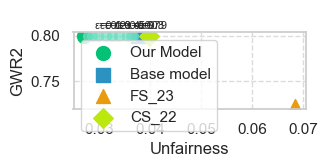

In [22]:
plot = plot_approximate_fairness(t_results_no_bias,'ks_stat')

In [23]:
results_df_exp[["model",'indirect_mean_bias_mean',
       'indirect_mean_bias_std', 'indirect_structural_bias_mean',
       'indirect_structural_bias_std', 'interaction_mean', 'interaction_std',
       'direct_mean_bias_mean', 'direct_mean_bias_std']]

,model,indirect_mean_bias_mean,indirect_mean_bias_std,indirect_structural_bias_mean,indirect_structural_bias_std,interaction_mean,interaction_std,direct_mean_bias_mean,direct_mean_bias_std
0,y_pred_fair,0.00021,0.0,0.00000,0.0,NaN,NaN,NaN,NaN
1,y_input_reg,0.00349,0.0,0.00059,0.0,-0.00138,0.0,0.00014,0.0
2,y_score_equipy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,y_pred_riken,0.03702,0.0,0.00255,0.0,NaN,NaN,NaN,NaN
4,y_pred_bias,0.00001,0.0,2.04606,0.0,NaN,NaN,NaN,NaN
5,y_pred_fair_0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,y_pred_fair_0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,y_pred_fair_0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,y_pred_fair_0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,y_pred_fair_0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
print('decomposition', t_results_no_bias['y_input_reg']['direct_mean_bias'][0] + t_results_no_bias['y_input_reg']['indirect_mean_bias'][0]+t_results_no_bias['y_input_reg']['indirect_structural_bias'][0] + t_results_no_bias['y_input_reg']['interaction'][0])
print('equation (6)', t_results_no_bias['y_input_reg']['total_unfairness'][0] )
print('equation (6)', t_results_no_bias['y_input_reg']['first_moment_disparity'][0] + t_results_no_bias['y_input_reg']['second_moment_disparity'][0] )

decomposition 0.002839503291213576
equation (6) 0.009543818810347531
equation (6) 0.009543818810347531


In [25]:
test_dataset_no_bias[test_dataset_no_bias['S']==1][X_features].cov()

,X_0,X_1,X_2,X_3
X_0,3.602124,-0.142146,-0.025097,0.182998
X_1,-0.142146,3.441440,-0.060355,-0.046411
X_2,-0.025097,-0.060355,3.441088,0.055020
X_3,0.182998,-0.046411,0.055020,3.402409


In [26]:
all_results, results_df_exp, test_dataset,pool_dataset, param_dictionnary=run_experiment('t_unfair', no_bias_params_values, no_bias_params, False,False,True)
-param_dictionnary['invariant_var_cov_term']*np.dot(param_dictionnary[f'empirical_mean_1'],param_dictionnary['beta'])/param_dictionnary[f'var_cov_product_1'] + param_dictionnary['fair_intercept']

Processing t_unfair: 100%|██████████| 1/1 [00:04<00:00,  4.70s/it]


np.float64(3.04007057803263)

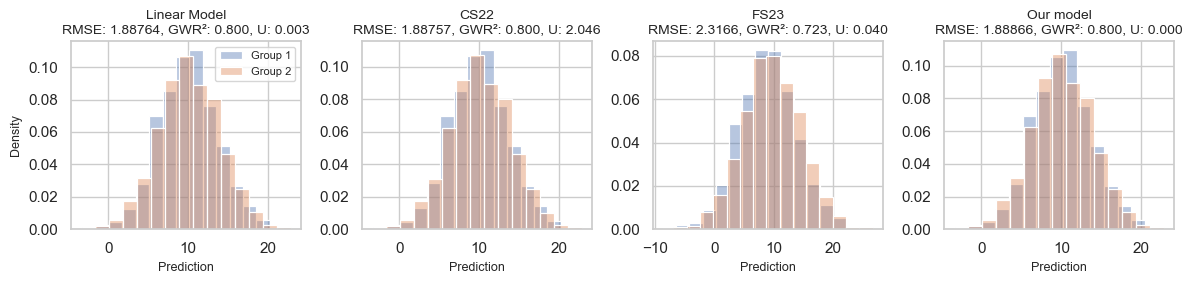

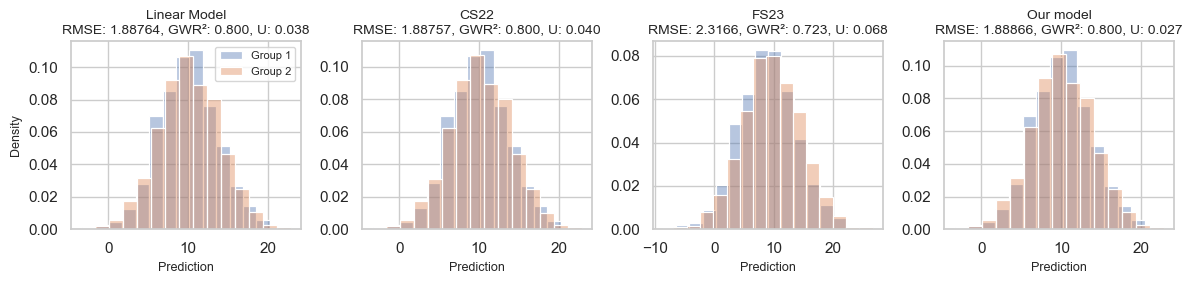

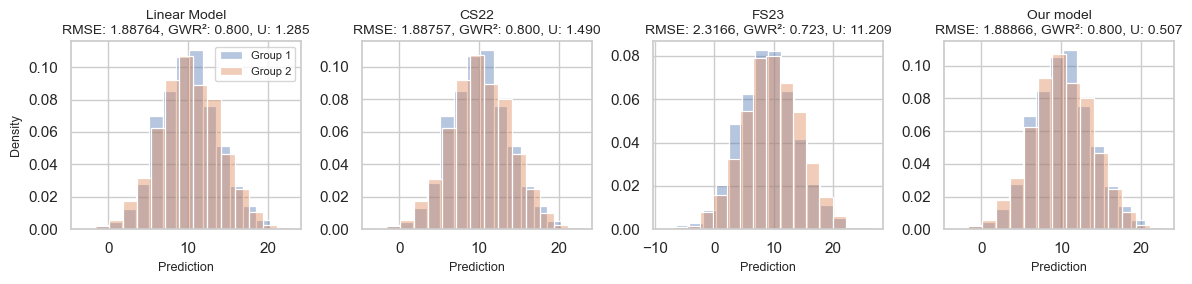

In [27]:
plot_no_bias_computation = plot_scores_densities(all_results[0],'unfairness_computed_mean',test_dataset_no_bias, save_path=None)
plot_no_bias_kstest = plot_scores_densities(all_results[0],'ks_stat_mean',test_dataset_no_bias, save_path=None,)
plot_no_bias_w2 = plot_scores_densities(all_results[0],'unfairness_W2_mean',test_dataset_no_bias, save_path=None,)

In [28]:
t_results_no_bias['y_pred_fair']['fair_intercept_1_NoStd']

[np.float64(3.04007057803263)]

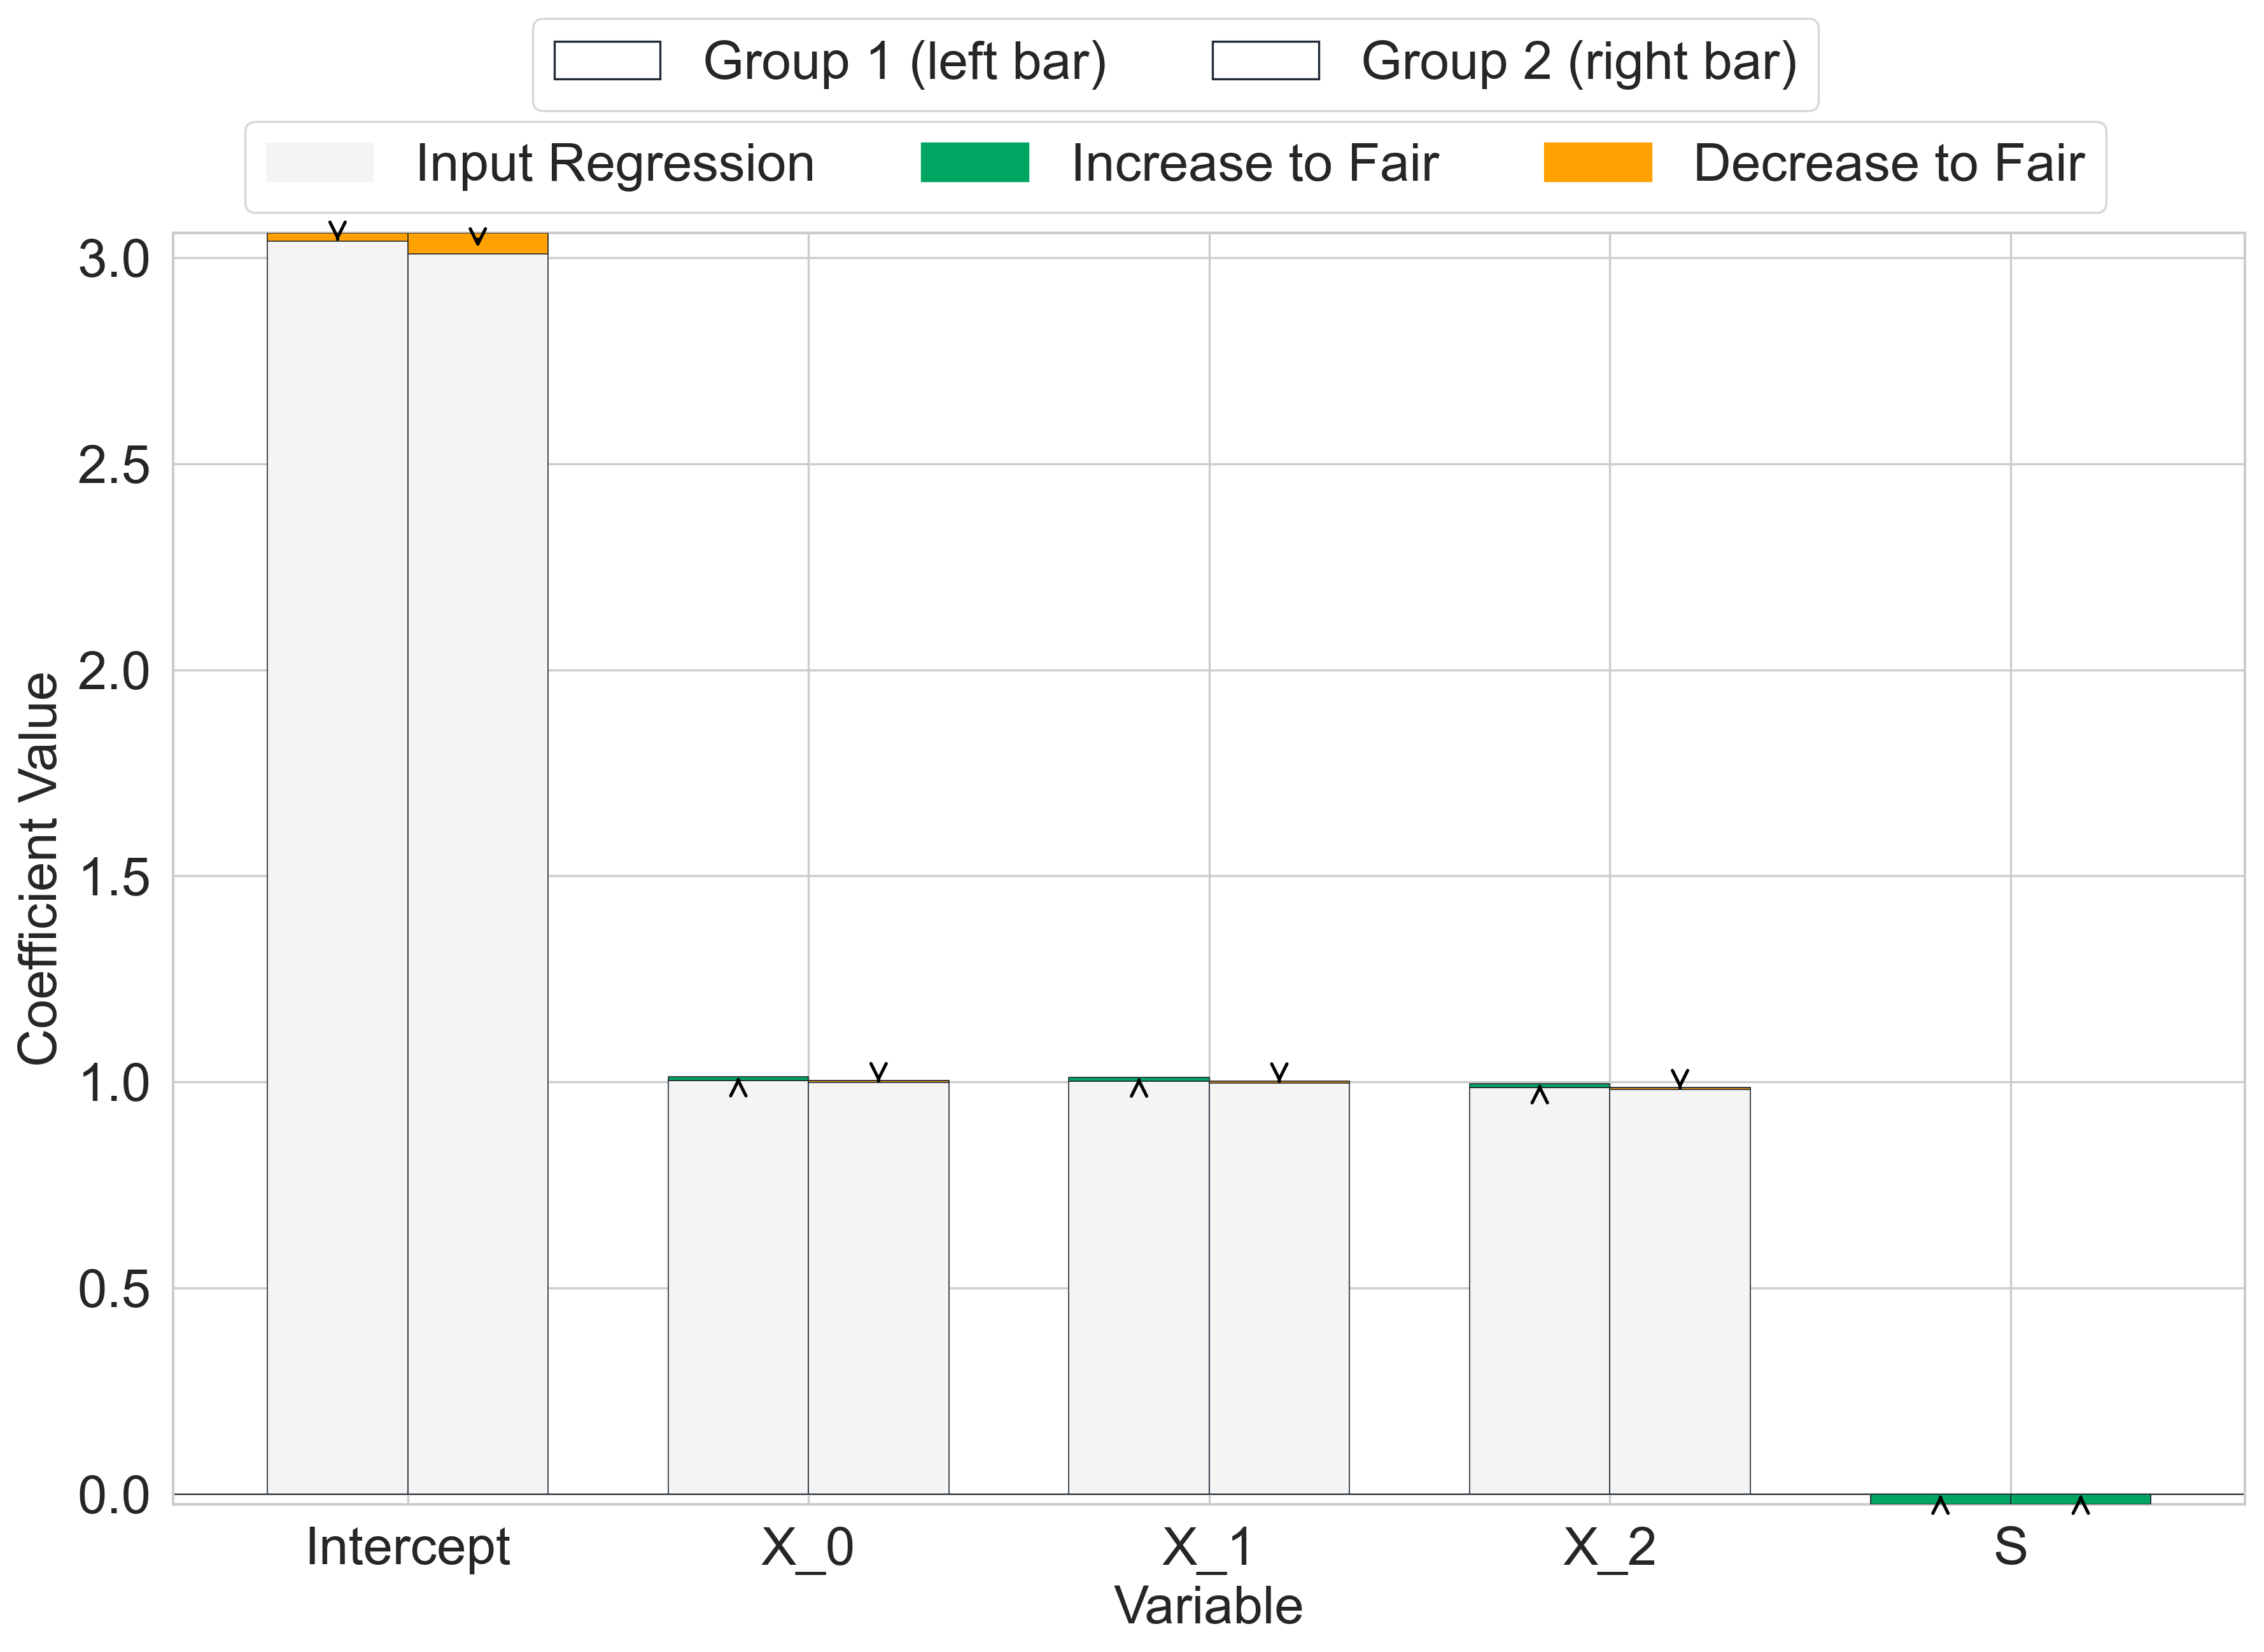

In [29]:
plot_fair_coefficient_evolution_with_decomposition(t_results_no_bias, 3, 'Comparison of coef after remediation', None)

In [30]:
print(test_dataset_no_bias[X_features].corr())
print(test_dataset_no_bias[test_dataset_no_bias['S']==1][X_features].cov())
print(test_dataset_no_bias[test_dataset_no_bias['S']==2][X_features].cov())

          X_0       X_1       X_2       X_3
X_0  1.000000 -0.015953 -0.000072  0.027102
X_1 -0.015953  1.000000  0.005705 -0.026485
X_2 -0.000072  0.005705  1.000000  0.018146
X_3  0.027102 -0.026485  0.018146  1.000000
          X_0       X_1       X_2       X_3
X_0  3.602124 -0.142146 -0.025097  0.182998
X_1 -0.142146  3.441440 -0.060355 -0.046411
X_2 -0.025097 -0.060355  3.441088  0.055020
X_3  0.182998 -0.046411  0.055020  3.402409
          X_0       X_1       X_2       X_3
X_0  3.635643 -0.013855  0.010295  0.048601
X_1 -0.013855  3.705498  0.062165 -0.117031
X_2  0.010295  0.062165  3.536998  0.065387
X_3  0.048601 -0.117031  0.065387  3.455287


__Direct bias__

In [31]:
direct_params = current_params.copy()
direct_params.update({
    'random_seed': 7,
    't_unfair': 3,  # Sera remplacé par les valeurs variables
    'p_mu_bias': 0,
    'p_sigma_bias': 0,
    't_correl':0
})
direct_params_values = [3]

In [32]:
t_results_direct, test_dataset_direct=run_experiment('t_unfair', direct_params_values, direct_params, True,False,True)
all_results_direct, results_df_DIRECT, test_dataset,pool_dataset, param_dictionnary=run_experiment('t_unfair', direct_params_values, direct_params, False,False,True)

Processing t_unfair: 100%|██████████| 1/1 [00:06<00:00,  6.11s/it]


In [33]:
print('decomposition', t_results_direct['y_input_reg']['direct_mean_bias'][0] + t_results_direct['y_input_reg']['indirect_mean_bias'][0]+t_results_direct['y_input_reg']['indirect_structural_bias'][0] + t_results_direct['y_input_reg']['interaction'][0])
print('equation (6)', t_results_direct['y_input_reg']['total_unfairness'][0] )
print('equation (6)', t_results_direct['y_input_reg']['first_moment_disparity'][0] + t_results_direct['y_input_reg']['second_moment_disparity'][0] )

decomposition 2.1285233881297816
equation (6) 2.2537267249634785
equation (6) 2.2537267249634785


C:\Users\bertille.tierny\AppData\Local\Temp\ipykernel_22580\1330456172.py:69: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


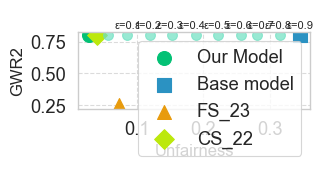

In [34]:
plot = plot_approximate_fairness(t_results_direct,'ks_stat')

In [35]:
t_results_direct['y_pred_bias']['indirect_mean_bias']
t_results_direct['y_pred_bias']['indirect_structural_bias']

[np.float64(2.0460563229566846)]

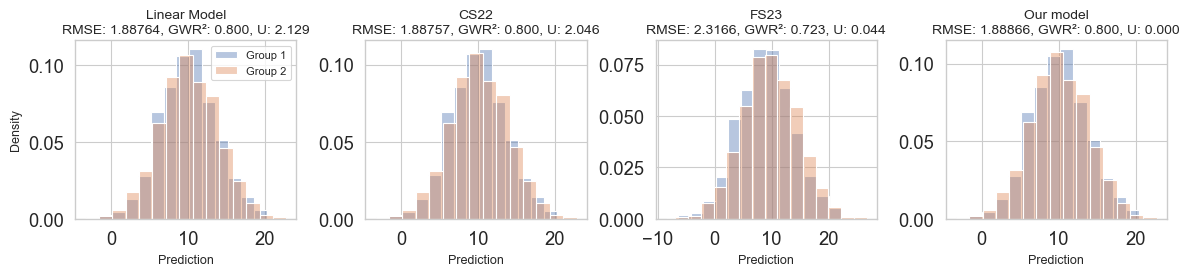

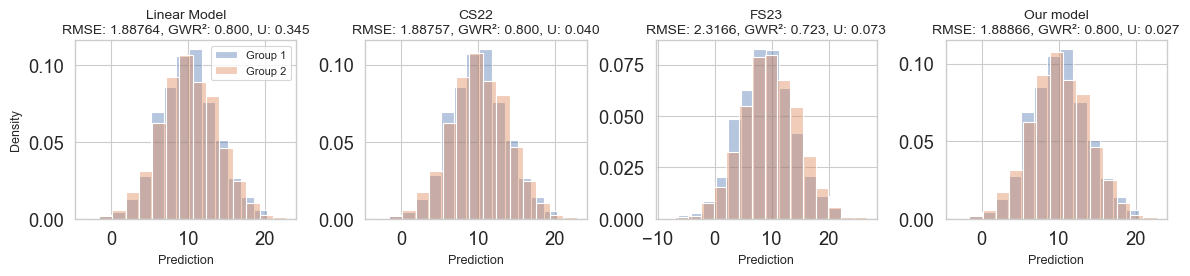

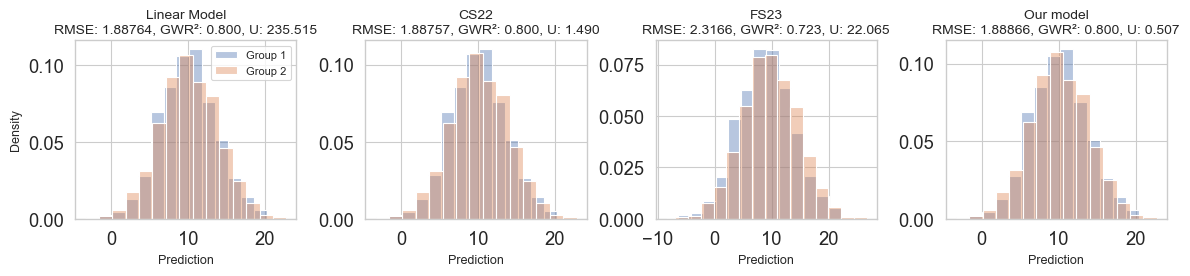

In [36]:
# density_plot = plot_scores_densities(test_dataset_direct, save_path=None)
plot_direct_bias_computation = plot_scores_densities(all_results_direct[3],'unfairness_computed_mean',test_dataset_no_bias, save_path=None)
plot_direct_bias_kstest = plot_scores_densities(all_results_direct[3],'ks_stat_mean',test_dataset_no_bias, save_path=None,)
plot_direct_bias_w2 = plot_scores_densities(all_results_direct[3],'unfairness_W2_mean',test_dataset_no_bias, save_path=None,)

In [37]:
all_results_direct, results_df_DIRECT, test_dataset_direct,pool_dataset_direct, param_dictionnary_direct=run_experiment('t_unfair', direct_params_values, direct_params, False,False,True)
print('intercept group 1', -param_dictionnary_direct['invariant_var_cov_term']*np.dot(param_dictionnary_direct[f'empirical_mean_1'],param_dictionnary_direct['beta'])/param_dictionnary_direct[f'var_cov_product_1'] + param_dictionnary_direct['fair_intercept'])
print('intercept group 2', -param_dictionnary_direct['invariant_var_cov_term']*np.dot(param_dictionnary_direct[f'empirical_mean_2'],param_dictionnary_direct['beta'])/param_dictionnary_direct[f'var_cov_product_2'] + param_dictionnary_direct['fair_intercept'])

Processing t_unfair: 100%|██████████| 1/1 [00:06<00:00,  6.19s/it]

intercept group 1 8.048195578032628
intercept group 2 8.017706347110597


In [38]:
def plot_fair_coefficient_evolution_with_decomposition(t_results, nb_features_to_plot, name_figure, marginal_contribution_df=None):
    # Import nécessaire pour Line2D
    from matplotlib.lines import Line2D
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Reset style to default and set clean theme
    plt.style.use('default')
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.0)  # Reduced font scale
    
    # Create smaller figure
    fig, ax1 = plt.subplots(figsize=(3, 1.5), dpi=300)  # Reduced size
    
    # Prepare data structure for plotting
    variables = ['Intercept'] + [f'X_{i}' for i in range(nb_features_to_plot)] + ['S']
    n_vars = len(variables)
    
    # Extract coefficients
    # Group 1 base coefficients (input regression)
    base_g1 = [t_results['y_input_reg']['beta_0_NoStd'][0]]  # Intercept
    base_g1.extend([t_results['y_input_reg']['beta_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    base_g1.append(t_results['y_input_reg']['gamma_NoStd'][0])  # S feature
    base_g1 = np.array(base_g1)
    
    # Group 2 base coefficients (input regression)
    base_g2 = [t_results['y_input_reg']['beta_0_NoStd'][0]]  # Intercept
    base_g2.extend([t_results['y_input_reg']['beta_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    base_g2.append(t_results['y_input_reg']['gamma_NoStd'][0])  # S feature
    base_g2 = np.array(base_g2)
    
    # Group 1 fair coefficients
    fair_g1 = [t_results['y_pred_fair']['fair_intercept_1_NoStd'][0]]  # Intercept
    fair_g1.extend([t_results['y_pred_fair']['beta_1_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    fair_g1.append(t_results['y_pred_fair']['gamma_NoStd'][0])  # S feature
    fair_g1 = np.array(fair_g1)
    
    # Group 2 fair coefficients
    fair_g2 = [t_results['y_pred_fair']['fair_intercept_2_NoStd'][0]]  # Intercept
    fair_g2.extend([t_results['y_pred_fair']['beta_2_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    fair_g2.append(t_results['y_pred_fair']['gamma_NoStd'][0])  # S feature
    fair_g2 = np.array(fair_g2)
    
    # Calculate differences
    diff_g1 = fair_g1 - base_g1
    diff_g2 = fair_g2 - base_g2
    
    # Bar placement
    width = 0.3  # Reduced width
    x = np.arange(n_vars)
    offset = [-width / 2, width / 2]
    
    # Plot bars for each group
    groups = ["Group 1", "Group 2"]
    bases = [base_g1, base_g2]
    diffs = [diff_g1, diff_g2]
    
    for gi, group in enumerate(groups):
        xg_all = x + offset[gi]
        
        # Base bars (input regression)
        ax1.bar(xg_all, bases[gi], width,
               color="#F4F4F4", edgecolor="#222B36", lw=0.4,
               label=f"Input Reg ({group})" if gi == 0 else None, zorder=2)
        
        # Difference bars (to fair model)
        ax1.bar(xg_all, diffs[gi], width, bottom=bases[gi],
               color=np.where(diffs[gi] > 0, "#00A562", "#FFA100"),
               edgecolor="#222B36", lw=0.4,
               label=f"Δ to Fair Model" if gi == 0 else None, zorder=3)
        
        # Arrows showing direction of change - only for significant changes
        for vi, (b, d) in enumerate(zip(bases[gi], diffs[gi])):
            if abs(d) < 1e-10 or abs(d) < abs(b)*0.05:  # Skip if no significant change
                continue
            x_c = xg_all[vi]
            y_start = b + (0.05 * d)  # Start 5% from base
            y_end = b + (0.95 * d)    # End 95% toward fair value
            ax1.annotate("",
                        xy=(x_c, y_end), xytext=(x_c, y_start),
                        arrowprops=dict(arrowstyle="->",
                                        color="#000000",
                                        lw=0.8),  # Thinner arrows
                        zorder=6)
    
    # X-axis labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(variables, rotation=0, ha='center', fontsize=8)  # Smaller font
    
    # Make sure y-axis tick labels are also consistent
    ax1.tick_params(axis='y', labelsize=8)  # Smaller font
    
    # Title and labels
    ax1.set_ylabel("Coefficient Value", fontsize=9)
    ax1.set_xlabel("Variable", fontsize=9)
    
    # Zero line
    ax1.axhline(0, color="#222B36", lw=0.5)
    
    # Add marginal contribution plot as an inset if data is provided
    if marginal_contribution_df is not None:
        # Create an inset axes for the marginal contribution plot
        # Position it more to the right
        ax2 = fig.add_axes([0.58, 0.25, 0.4, 0.5])  # Adjusted position and size
        
        # Extraction des données (seulement pour X_0, X_1, X_2)
        features = marginal_contribution_df['Feature'].iloc[:3]
        mean_bias = marginal_contribution_df['Indirect_Mean_Bias'].iloc[:3]
        structural_bias = marginal_contribution_df['Indirect_Structural_Bias'].iloc[:3]
        interaction_effect = marginal_contribution_df['Interaction_Effect'].iloc[:3]
        
        # Position des barres
        y_pos = np.arange(len(features))
        
        # Largeur des barres
        bar_height = 0.6
        
        # Couleurs pastel
        mean_bias_color = "#CDA5FF"      # Orange pastel
        structural_bias_color = "#BFEDCB"  # Vert pastel
        interaction_effect_color = "#BFD7ED" # Bleu pastel
        
        # Création des barres empilées horizontalement
        ax2.barh(y_pos, mean_bias, bar_height, label='Mean Bias', color=mean_bias_color)
        ax2.barh(y_pos, structural_bias, bar_height, left=mean_bias, 
                label='Structural Bias', color=structural_bias_color)
        ax2.barh(y_pos, interaction_effect, bar_height, 
                left=mean_bias+structural_bias, label='Interaction Effect', 
                color=interaction_effect_color)
        
        # Personnalisation du graphique inséré
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(features, fontsize=8)  # Smaller font
        ax2.invert_yaxis()  # Pour avoir X_0 en haut
        ax2.set_xlabel('Marginal Contribution', fontsize=8)  # Smaller font
        ax2.set_title('Feature-Level Contribution', fontsize=9)  # Shorter title
        ax2.tick_params(axis='x', labelsize=7)  # Smaller font
        
        # Ajout d'un cadre autour du graphique inséré
        ax2.patch.set_alpha(0.9)  # Légère transparence
        ax2.patch.set_facecolor('white')  # Fond blanc
        for spine in ax2.spines.values():
            spine.set_edgecolor('#222B36')
            spine.set_linewidth(0.8)
        
        # Légende compacte pour le graphique inséré
        ax2.legend(loc='lower right', fontsize=6, frameon=True, framealpha=0.9, 
                  ncol=1, handlelength=1, handletextpad=0.5)
    
    # Create a compact legend
    # Create custom legend elements
    legend_elements = [
        # Group identification
        Line2D([0], [0], marker='s', color='w', markerfacecolor='none', markeredgecolor='#222B36', 
              markersize=8, label="Group 1 (left)"),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='none', markeredgecolor='#222B36', 
              markersize=8, label="Group 2 (right)"),
        # Color coding
        Line2D([0], [0], marker='s', color='w', markerfacecolor='#F4F4F4', markeredgecolor='#222B36', 
              markersize=8, label='Input Reg.'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='#00A562', markeredgecolor='#222B36', 
              markersize=8, label='Increase'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='#FFA100', markeredgecolor='#222B36', 
              markersize=8, label='Decrease')
    ]
    
    # Place legend at the top of the figure
    fig.legend(handles=legend_elements, loc='upper center', 
              bbox_to_anchor=(0.5, 1.05), ncol=5, frameon=False, 
              fontsize=7, handletextpad=0.5, columnspacing=1.0)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(name_figure, bbox_inches='tight', dpi=300)
    
    return fig


In [39]:
def plot_fair_coefficient_evolution_with_decomposition(t_results, nb_features_to_plot, name_figure, marginal_contribution_df=None):
    # Import nécessaire pour Line2D
    from matplotlib.lines import Line2D
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Reset style to default and set clean theme
    plt.style.use('default')
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.0)  # Reduced font scale
    
    # Utiliser la palette colorblind de seaborn
    palette = sns.color_palette("colorblind")
    
    # Définir les couleurs à partir de la palette colorblind
    base_color = "#F4F4F4"  # Gardons le gris clair pour la base
    increase_color = palette[2]  # Vert-bleu (généralement accessible)
    decrease_color = palette[1]  # Orange (généralement accessible)
    
    # Couleurs pour le graphique inséré
    mean_bias_color = palette[0]      # Bleu
    structural_bias_color = palette[3]  # Vert
    interaction_effect_color = palette[4]  # Violet
    
    # Create smaller figure
    fig, ax1 = plt.subplots(figsize=(5, 2.5), dpi=300)  # Reduced size
    
    # Prepare data structure for plotting
    variables = ['Intercept'] + [f'X_{i}' for i in range(nb_features_to_plot)] + ['S']
    n_vars = len(variables)
    
    # Extract coefficients
    # Group 1 base coefficients (input regression)
    base_g1 = [t_results['y_input_reg']['beta_0_NoStd'][0]]  # Intercept
    base_g1.extend([t_results['y_input_reg']['beta_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    base_g1.append(t_results['y_input_reg']['gamma_NoStd'][0])  # S feature
    base_g1 = np.array(base_g1)
    
    # Group 2 base coefficients (input regression)
    base_g2 = [t_results['y_input_reg']['beta_0_NoStd'][0]]  # Intercept
    base_g2.extend([t_results['y_input_reg']['beta_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    base_g2.append(t_results['y_input_reg']['gamma_NoStd'][0])  # S feature
    base_g2 = np.array(base_g2)
    
    # Group 1 fair coefficients
    fair_g1 = [t_results['y_pred_fair']['fair_intercept_1_NoStd'][0]]  # Intercept
    fair_g1.extend([t_results['y_pred_fair']['beta_1_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    fair_g1.append(t_results['y_pred_fair']['gamma_NoStd'][0])  # S feature
    fair_g1 = np.array(fair_g1)
    
    # Group 2 fair coefficients
    fair_g2 = [t_results['y_pred_fair']['fair_intercept_2_NoStd'][0]]  # Intercept
    fair_g2.extend([t_results['y_pred_fair']['beta_2_NoStd'][0][i] for i in range(nb_features_to_plot)])  # Features
    fair_g2.append(t_results['y_pred_fair']['gamma_NoStd'][0])  # S feature
    fair_g2 = np.array(fair_g2)
    
    # Calculate differences
    diff_g1 = fair_g1 - base_g1
    diff_g2 = fair_g2 - base_g2
    
    # Bar placement
    width = 0.3  # Reduced width
    x = np.arange(n_vars)
    offset = [-width / 2, width / 2]
    
    # Plot bars for each group
    groups = ["Group 1", "Group 2"]
    bases = [base_g1, base_g2]
    diffs = [diff_g1, diff_g2]
    
    for gi, group in enumerate(groups):
        xg_all = x + offset[gi]
        
        # Base bars (input regression)
        ax1.bar(xg_all, bases[gi], width,
               color=base_color, edgecolor="#222B36", lw=0.4,
               label=f"Input Reg ({group})" if gi == 0 else None, zorder=2)
        
        # Difference bars (to fair model) - Correction pour éviter l'erreur de broadcast
        # Créer un tableau de couleurs de la même taille que diffs[gi]
        bar_colors = []
        for d in diffs[gi]:
            if d > 0:
                bar_colors.append(increase_color)
            else:
                bar_colors.append(decrease_color)
        
        ax1.bar(xg_all, diffs[gi], width, bottom=bases[gi],
               color=bar_colors,
               edgecolor="#222B36", lw=0.4,
               label=f"Δ to Fair Model" if gi == 0 else None, zorder=3)
        
        # Arrows showing direction of change - only for significant changes
        for vi, (b, d) in enumerate(zip(bases[gi], diffs[gi])):
            if abs(d) < 1e-10 or abs(d) < abs(b)*0.05:  # Skip if no significant change
                continue
            x_c = xg_all[vi]
            y_start = b + (0.05 * d)  # Start 5% from base
            y_end = b + (0.95 * d)    # End 95% toward fair value
            ax1.annotate("",
                        xy=(x_c, y_end), xytext=(x_c, y_start),
                        arrowprops=dict(arrowstyle="->",
                                        color="#000000",
                                        lw=0.8),  # Thinner arrows
                        zorder=6)
    
    # X-axis labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(variables, rotation=0, ha='center', fontsize=8)  # Smaller font
    
    # Make sure y-axis tick labels are also consistent
    ax1.tick_params(axis='y', labelsize=8)  # Smaller font
    
    # Title and labels
    ax1.set_ylabel("Coefficient Value", fontsize=9)
    ax1.set_xlabel("Variable", fontsize=9)
    
    # Zero line
    ax1.axhline(0, color="#222B36", lw=0.5)
    
    # Add marginal contribution plot as an inset if data is provided
    if marginal_contribution_df is not None:
        # Create an inset axes for the marginal contribution plot
        # Position it more to the right
        ax2 = fig.add_axes([0.58, 0.25, 0.4, 0.5])  # Adjusted position and size
        
        # Extraction des données (seulement pour X_0, X_1, X_2)
        features = marginal_contribution_df['Feature'].iloc[:3]
        mean_bias = marginal_contribution_df['Indirect_Mean_Bias'].iloc[:3]
        structural_bias = marginal_contribution_df['Indirect_Structural_Bias'].iloc[:3]
        interaction_effect = marginal_contribution_df['Interaction_Effect'].iloc[:3]
        
        # Position des barres
        y_pos = np.arange(len(features))
        
        # Largeur des barres
        bar_height = 0.6
        
        # Création des barres empilées horizontalement
        ax2.barh(y_pos, mean_bias, bar_height, label='Mean Bias', color=mean_bias_color)
        ax2.barh(y_pos, structural_bias, bar_height, left=mean_bias, 
                label='Structural Bias', color=structural_bias_color)
        ax2.barh(y_pos, interaction_effect, bar_height, 
                left=mean_bias+structural_bias, label='Interaction Effect', 
                color=interaction_effect_color)
        
        # Personnalisation du graphique inséré
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(features, fontsize=8)  # Smaller font
        ax2.invert_yaxis()  # Pour avoir X_0 en haut
        ax2.set_xlabel('Marginal Contribution', fontsize=8)  # Smaller font
        ax2.set_title('Feature-Level Contribution', fontsize=9)  # Shorter title
        ax2.tick_params(axis='x', labelsize=7)  # Smaller font
        
        # Ajout d'un cadre autour du graphique inséré
        ax2.patch.set_alpha(0.9)  # Légère transparence
        ax2.patch.set_facecolor('white')  # Fond blanc
        for spine in ax2.spines.values():
            spine.set_edgecolor('#222B36')
            spine.set_linewidth(0.8)
        
        # Légende compacte pour le graphique inséré
        ax2.legend(loc='lower right', fontsize=6, frameon=True, framealpha=0.9, 
                  ncol=1, handlelength=1, handletextpad=0.5)
    
    # Create a compact legend
    # Create custom legend elements
    legend_elements = [
        # Group identification
        Line2D([0], [0], marker='s', color='w', markerfacecolor='none', markeredgecolor='#222B36', 
              markersize=8, label="Group 1 (left)"),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='none', markeredgecolor='#222B36', 
              markersize=8, label="Group 2 (right)"),
        # Color coding
        Line2D([0], [0], marker='s', color='w', markerfacecolor=base_color, markeredgecolor='#222B36', 
              markersize=8, label='Input Reg.'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor=increase_color, markeredgecolor='#222B36', 
              markersize=8, label='Increase'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor=decrease_color, markeredgecolor='#222B36', 
              markersize=8, label='Decrease')
    ]
    
    # Place legend at the top of the figure
    fig.legend(handles=legend_elements, loc='upper center', 
              bbox_to_anchor=(0.5, 1.05), ncol=5, frameon=False, 
              fontsize=7, handletextpad=0.5, columnspacing=1.0)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(name_figure, bbox_inches='tight', dpi=300)
    
    return fig


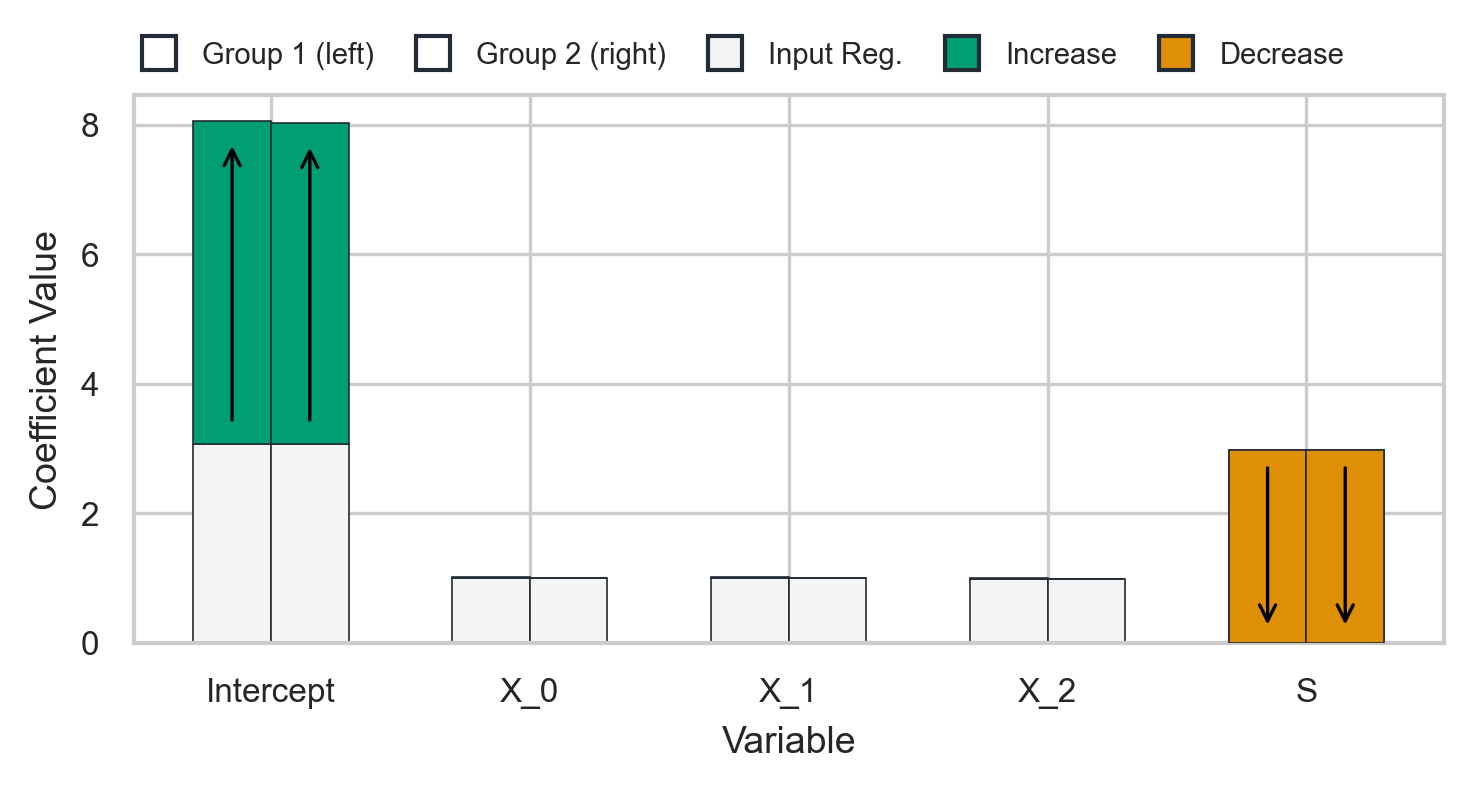

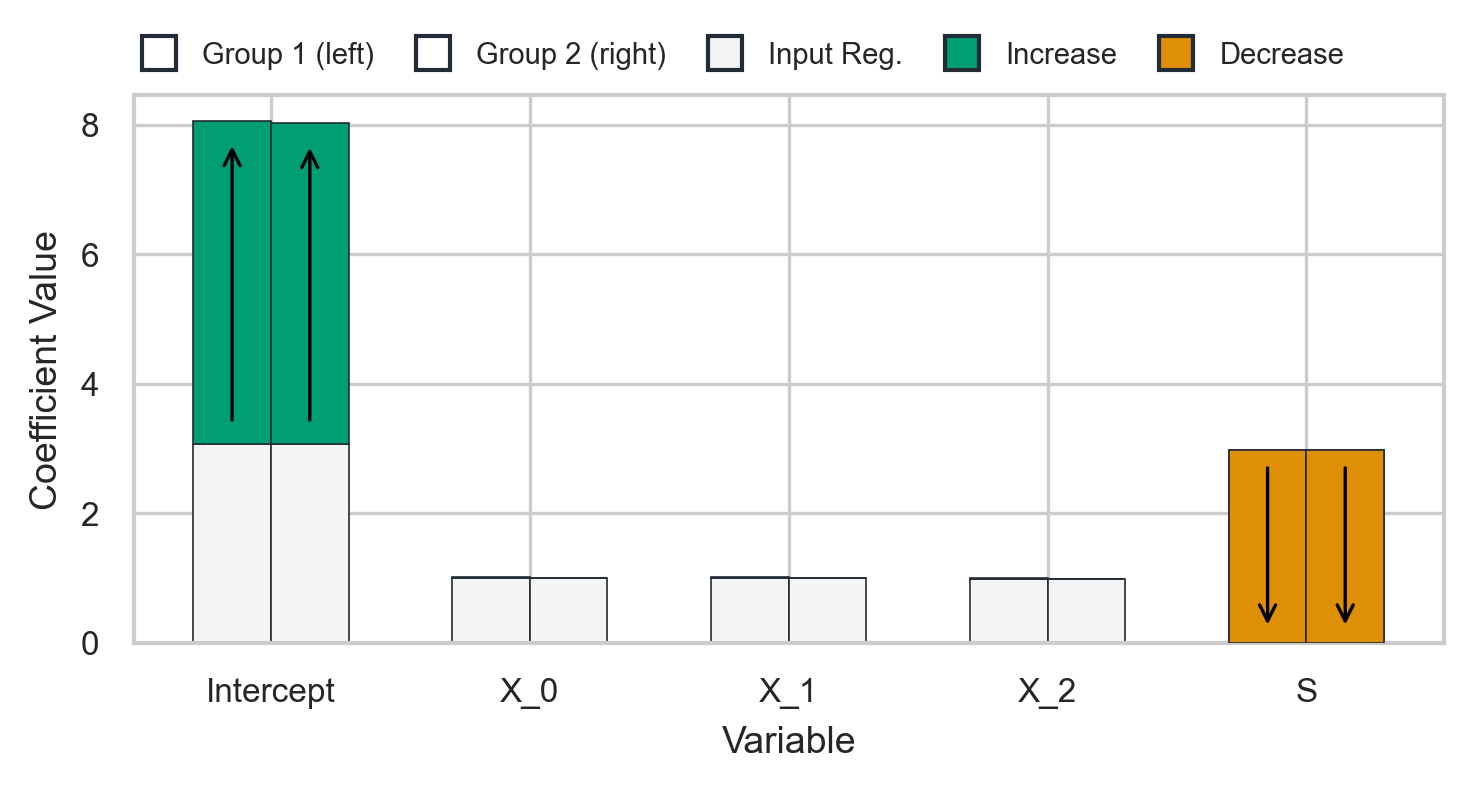

In [40]:
# plot_fair_coefficient_evolution(t_results_direct, 3, 'Comparison of coef after remediation')
plot_fair_coefficient_evolution_with_decomposition(t_results_direct, 3, 'Comparison of coef after remediation', None)

In [41]:
print(test_dataset_direct[X_features].corr())
print(test_dataset_direct[test_dataset_direct['S']==1][X_features].corr())
print(test_dataset_direct[test_dataset_direct['S']==2][X_features].corr())

          X_0       X_1       X_2       X_3
X_0  1.000000 -0.015953 -0.000072  0.027102
X_1 -0.015953  1.000000  0.005705 -0.026485
X_2 -0.000072  0.005705  1.000000  0.018146
X_3  0.027102 -0.026485  0.018146  1.000000
          X_0       X_1       X_2       X_3
X_0  1.000000 -0.040372 -0.007128  0.052273
X_1 -0.040372  1.000000 -0.017539 -0.013563
X_2 -0.007128 -0.017539  1.000000  0.016080
X_3  0.052273 -0.013563  0.016080  1.000000
          X_0       X_1       X_2       X_3
X_0  1.000000 -0.003775  0.002871  0.013712
X_1 -0.003775  1.000000  0.017171 -0.032707
X_2  0.002871  0.017171  1.000000  0.018704
X_3  0.013712 -0.032707  0.018704  1.000000


In [42]:
results_df_DIRECT[["model",'indirect_mean_bias_mean',
       'indirect_mean_bias_std', 'indirect_structural_bias_mean',
       'indirect_structural_bias_std', 'interaction_mean', 'interaction_std',
       'direct_mean_bias_mean', 'direct_mean_bias_std']]

,model,indirect_mean_bias_mean,indirect_mean_bias_std,indirect_structural_bias_mean,indirect_structural_bias_std,interaction_mean,interaction_std,direct_mean_bias_mean,direct_mean_bias_std
0,y_pred_fair,0.00021,0.0,0.00000,0.0,NaN,NaN,NaN,NaN
1,y_input_reg,0.00349,0.0,0.00059,0.0,0.16549,0.0,1.95895,0.0
2,y_score_equipy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,y_pred_riken,0.03990,0.0,0.00457,0.0,NaN,NaN,NaN,NaN
4,y_pred_bias,0.00001,0.0,2.04606,0.0,NaN,NaN,NaN,NaN
5,y_pred_fair_0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,y_pred_fair_0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,y_pred_fair_0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,y_pred_fair_0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,y_pred_fair_0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


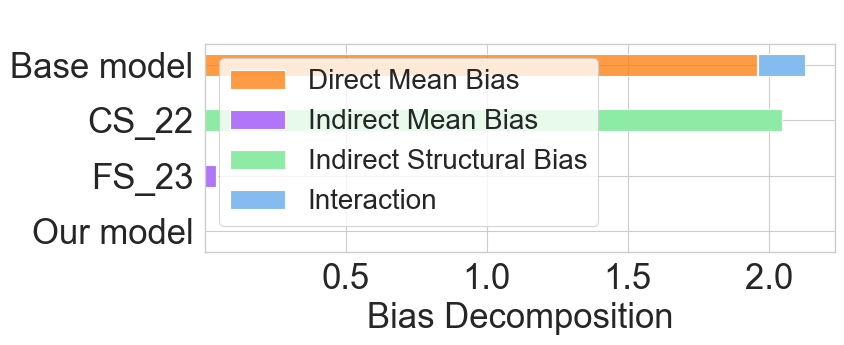

In [43]:
fig, ax = plot_bias_decomposition_by_model(results_df_DIRECT, test_dataset_direct)


__Indirect bias via the mean__

In [44]:
direct_mu_params = current_params.copy()
direct_mu_params.update({
    'random_seed': 7,
    't_unfair': 3,  # Sera remplacé par les valeurs variables
    'p_mu_bias': 2,
    'p_sigma_bias': 0,
    't_correl':0
})
direct_mu_params_values = [3]

In [45]:
t_results_direct_mu, test_dataset_direct_mu =run_experiment('t_unfair', direct_mu_params_values, direct_mu_params, True,False,True)

Processing t_unfair:   0%|          | 0/1 [00:07<?, ?it/s]


In [46]:
print('decomposition', t_results_direct_mu['y_input_reg']['direct_mean_bias'][0] + t_results_direct_mu['y_input_reg']['indirect_mean_bias'][0]+t_results_direct_mu['y_input_reg']['indirect_structural_bias'][0] + t_results_direct_mu['y_input_reg']['interaction'][0])
print('equation (6)', t_results_direct_mu['y_input_reg']['total_unfairness'][0] )
print('equation (6)', t_results_direct_mu['y_input_reg']['first_moment_disparity'][0] + t_results_direct_mu['y_input_reg']['second_moment_disparity'][0] )

decomposition 38.268197370344865
equation (6) 37.45212980119362
equation (6) 37.45212980119362


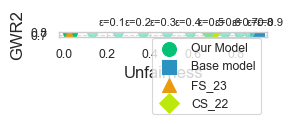

In [47]:
plot = plot_approximate_fairness(t_results_direct_mu,'ks_stat')

In [48]:
t_results_direct_mu['y_pred_bias']['indirect_mean_bias']
t_results_direct_mu['y_pred_bias']['indirect_structural_bias']

[np.float64(2.254426356841785)]

In [49]:
# density = plot_scores_densities(test_dataset_direct_mu, save_path=None)

In [50]:
all_results_mu, results_df_mu, test_dataset_mu,pool_dataset_mu, param_dictionnary_mu=run_experiment('t_unfair', direct_mu_params_values, direct_mu_params, False,False,True)
print('intercept group 1', -param_dictionnary_mu['invariant_var_cov_term']*np.dot(param_dictionnary_mu[f'empirical_mean_1'],param_dictionnary_mu['beta'])/param_dictionnary_mu[f'var_cov_product_1'] + param_dictionnary_mu['fair_intercept'])
print('intercept group 2', -param_dictionnary_mu['invariant_var_cov_term']*np.dot(param_dictionnary_mu[f'empirical_mean_2'],param_dictionnary_mu['beta'])/param_dictionnary_mu[f'var_cov_product_2'] + param_dictionnary_mu['fair_intercept'])

Processing t_unfair: 100%|██████████| 1/1 [00:10<00:00, 10.33s/it]

intercept group 1 12.481532217282549
intercept group 2 5.068971001415871


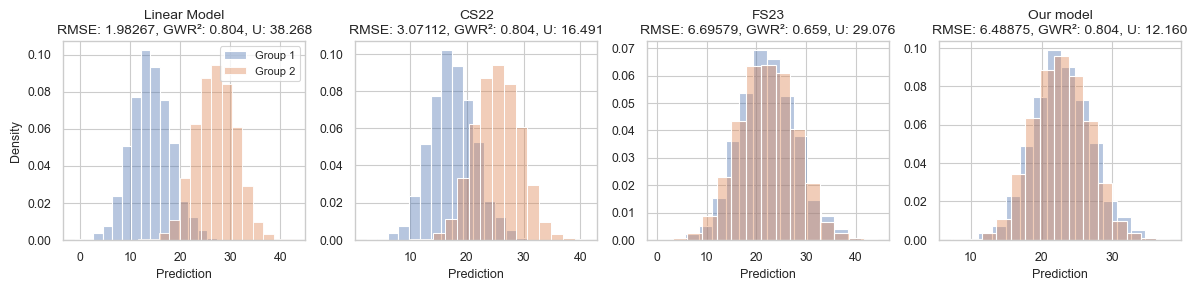

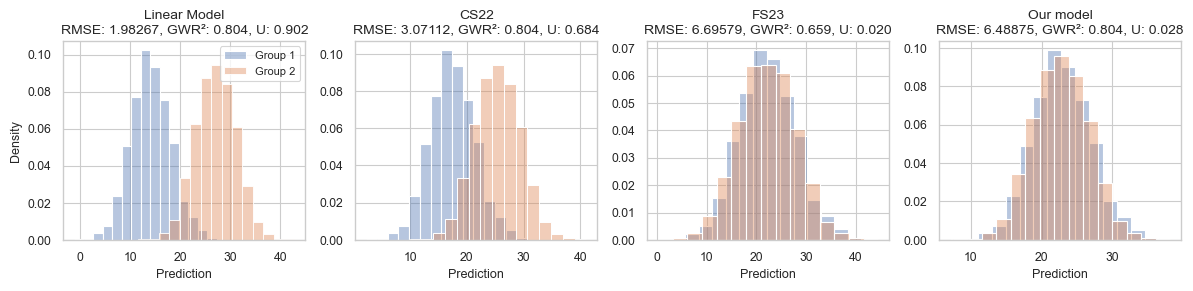

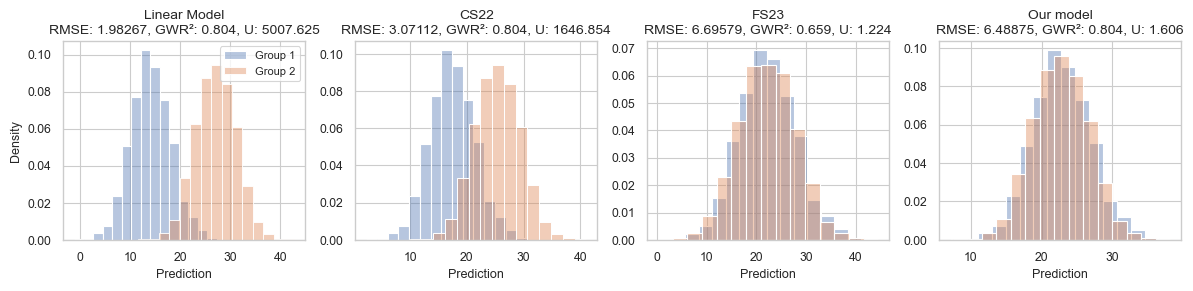

In [51]:
# density_plot = plot_scores_densities(test_dataset_direct, save_path=None)
plot_direct_mu_bias_computation = plot_scores_densities(all_results_mu[3],'unfairness_computed_mean',test_dataset_direct_mu, save_path=None)
plot_direct_mu_bias_kstest = plot_scores_densities(all_results_mu[3],'ks_stat_mean',test_dataset_direct_mu, save_path=None,)
plot_direct_mu_bias_w2 = plot_scores_densities(all_results_mu[3],'unfairness_W2_mean',test_dataset_direct_mu, save_path=None,)

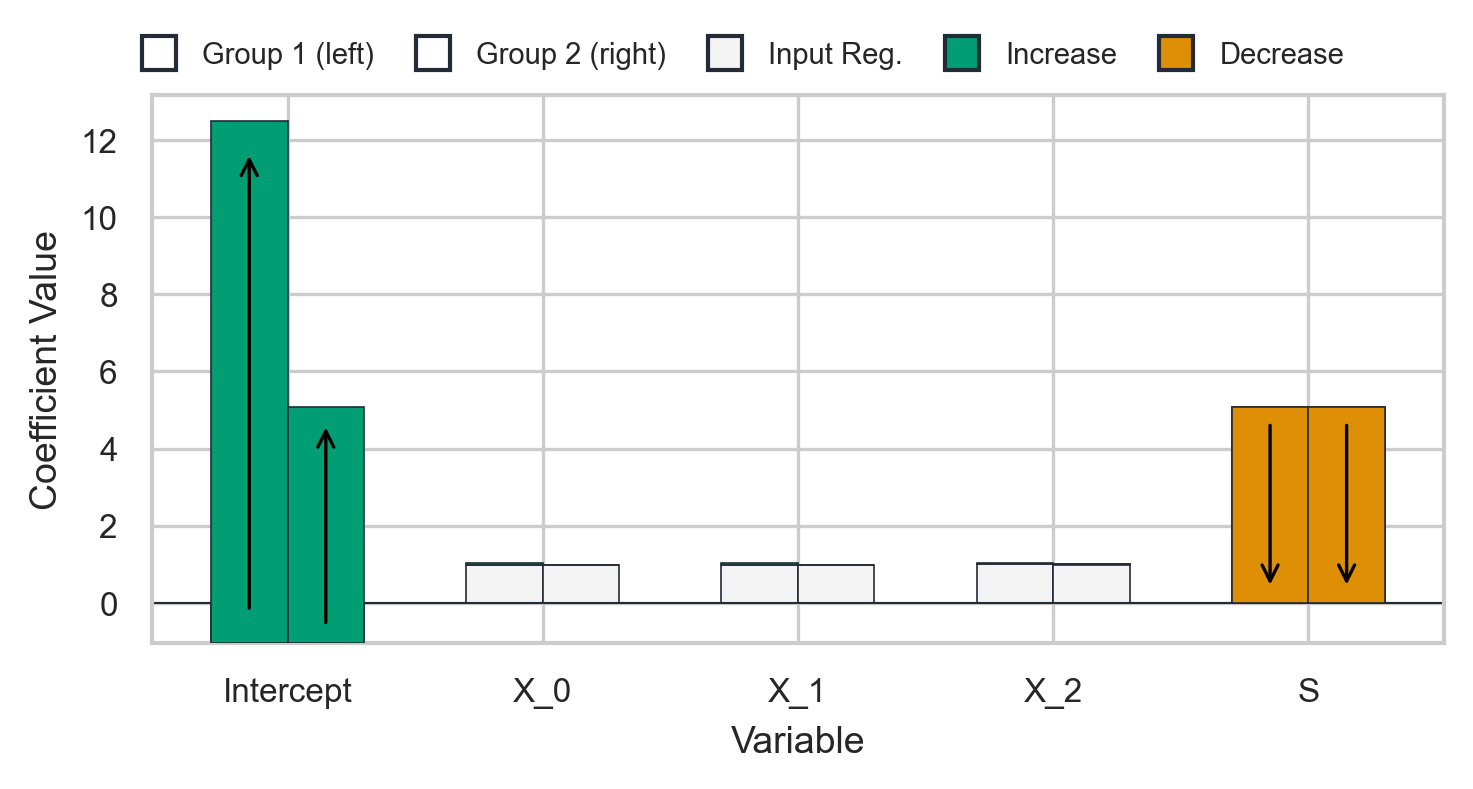

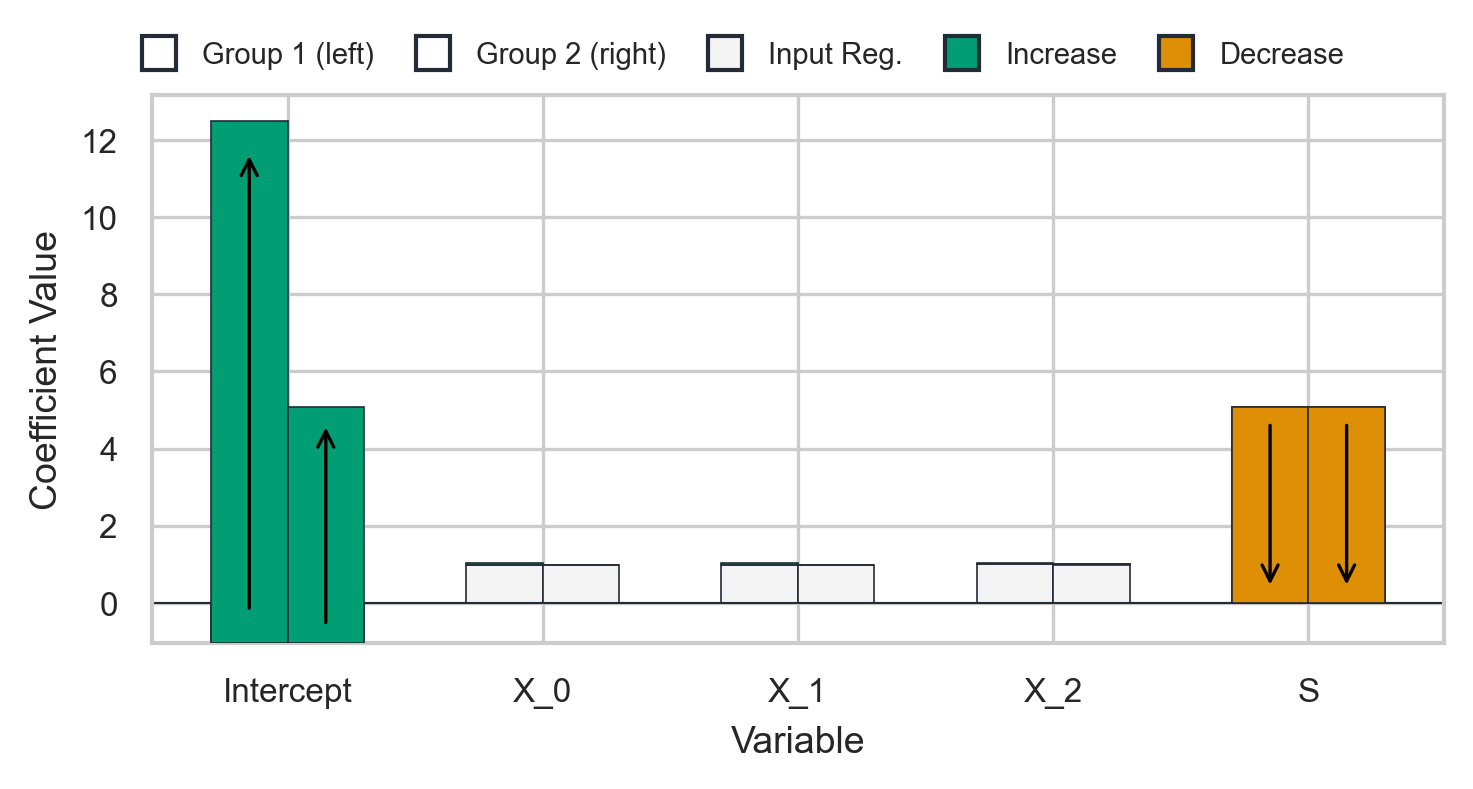

In [52]:
# plot_fair_coefficient_evolution(t_results_direct_mu, 5, 'Comparison of coef after remediation')
plot_fair_coefficient_evolution_with_decomposition(t_results_direct_mu, 3, 'Comparison of coef after remediation', None)

In [53]:
X_features

['X_0', 'X_1', 'X_2', 'X_3']

In [54]:
direct_mu_params_values = [3]
all_results_mean, results_df_exp_mean, test_dataset_mean,pool_dataset_mean, param_dictionnary_mean=run_experiment(
    varying_param='t_unfair', 
    param_values=direct_mu_params_values, 
    fixed_params=direct_mu_params, 
    coefficients_analysis=False,
    bool_coef=False, 
    bool_approximate_fairness=True)
# marginal_contribution = pd.DataFrame(calculate_marginal_contributions(test_dataset_mean, X_features, 'S', param_dictionnary_mean))

Processing t_unfair: 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


In [55]:
print(test_dataset_direct_mu[X_features].corr())
print(test_dataset_direct_mu[test_dataset_direct_mu['S']==1][X_features].corr())
print(test_dataset_direct_mu[test_dataset_direct_mu['S']==2][X_features].corr())

          X_0       X_1       X_2       X_3
X_0  1.000000  0.169001  0.198963  0.210491
X_1  0.169001  1.000000  0.170671  0.193828
X_2  0.198963  0.170671  1.000000  0.181755
X_3  0.210491  0.193828  0.181755  1.000000
          X_0       X_1       X_2       X_3
X_0  1.000000 -0.020210  0.037514  0.032090
X_1 -0.020210  1.000000 -0.021972  0.008043
X_2  0.037514 -0.021972  1.000000  0.009725
X_3  0.032090  0.008043  0.009725  1.000000
          X_0       X_1       X_2       X_3
X_0  1.000000 -0.014874  0.009156  0.024756
X_1 -0.014874  1.000000 -0.002294  0.016960
X_2  0.009156 -0.002294  1.000000 -0.008237
X_3  0.024756  0.016960 -0.008237  1.000000


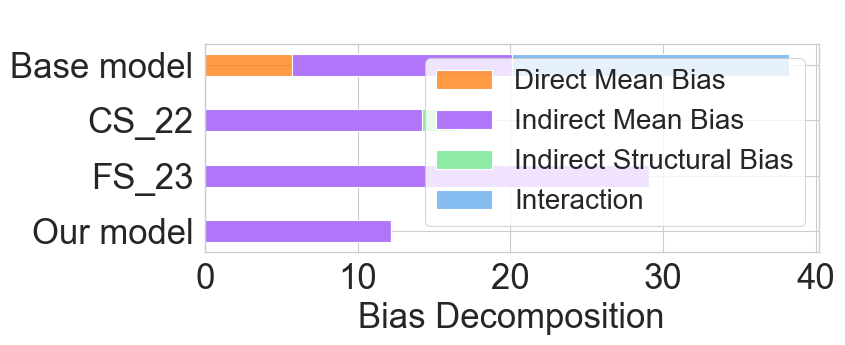

In [56]:
fig, ax = plot_bias_decomposition_by_model(results_df_exp_mean, test_dataset_mean)


__analyse avec un cas sans corrélation mais variances par groupe différentes__

In [57]:
# marginal_contribution[['Feature','Indirect_Mean_Bias',	'Indirect_Structural_Bias',	'Interaction_Effect',	'Total_Marginal_Contribution']]

In [58]:
# plot_marginal_contribution_decomposition(marginal_contribution)

In [59]:
# plot_fair_coefficient_evolution_with_decomposition(t_results_direct_mu, 3, 'Comparison of coef after remediation', marginal_contribution)

__Indirect bias via the std__

In [60]:
mean_std_bias_params = current_params.copy()
mean_std_bias_params.update({
    'random_seed': 7,
    't_unfair': 3,  # Sera remplacé par les valeurs variables
    'p_mu_bias': 5,
    'p_sigma_bias': 3, #5, #5
    't_correl':0.9, #0?5
})
mean_std_bias_params_values= [3]

In [61]:
t_results_mean_std_bias, test_dataset_mean_std_bias=run_experiment('t_unfair', mean_std_bias_params_values, mean_std_bias_params, True,False,True)

Processing t_unfair:   0%|          | 0/1 [00:06<?, ?it/s]


In [62]:
print('decomposition', t_results_mean_std_bias['y_input_reg']['direct_mean_bias'][0] + t_results_mean_std_bias['y_input_reg']['indirect_mean_bias'][0]+t_results_mean_std_bias['y_input_reg']['indirect_structural_bias'][0] + t_results_mean_std_bias['y_input_reg']['interaction'][0])
print('equation (6)', t_results_mean_std_bias['y_input_reg']['total_unfairness'][0] )
print('equation (6)', t_results_mean_std_bias['y_input_reg']['first_moment_disparity'][0] + t_results_mean_std_bias['y_input_reg']['second_moment_disparity'][0] )

decomposition 175.8678191749701
equation (6) 173.91436050300592
equation (6) 173.91436050300592


In [63]:
t_results_mean_std_bias['y_input_reg']

{'r2': [0.9635275735058606],
 'GWR2': [0.6929697532054196],
 'mae': [2.137097051695579],
 'rmse': [np.float64(2.757919066936589)],
 'unfairness_W2': [np.float64(26797.378076277004)],
 'unfairness_W1': [np.float64(32.92211881770041)],
 'unfairness_computed': [np.float64(175.8678191749701)],
 'ks_stat': [np.float64(0.9992630803242447)],
 'indirect_mean_bias': [np.float64(74.24421874463343)],
 'indirect_structural_bias': [np.float64(1.7022520070807166)],
 'interaction': [np.float64(78.93879453536053)],
 'direct_mean_bias': [np.float64(20.98255388789542)],
 'total_unfairness': [np.float64(173.91436050300592)],
 'first_moment_disparity': [np.float64(172.0933255569166)],
 'second_moment_disparity': [np.float64(1.821034946089331)],
 'beta_0_NoStd': [np.float64(-5.37811752540798)],
 'beta_NoStd': [array([1.34090257, 0.50952678, 0.75299821, 1.04306621])],
 'gamma_NoStd': [np.float64(9.737031720074313)],
 'beta_0_1_Std': [np.float64(4.253950013158649)],
 'beta_0_2_Std': [np.float64(22.5698697634

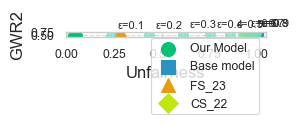

In [64]:
plot =plot_approximate_fairness(t_results_mean_std_bias,'ks_stat')

In [65]:
all_results_mean_std, results_df_exp_mean_std, test_dataset_mean_std,pool_dataset_mean_std, param_dictionnary_mean_std=run_experiment(
    varying_param='t_unfair', 
    param_values=mean_std_bias_params_values, 
    fixed_params=mean_std_bias_params, 
    coefficients_analysis=False,
    bool_coef=0.5, 
    bool_approximate_fairness=True)
# marginal_contribution_mean_std = pd.DataFrame(calculate_marginal_contributions(test_dataset_mean_std, X_features, 'S', param_dictionnary_mean_std))

Processing t_unfair: 100%|██████████| 1/1 [00:10<00:00, 10.68s/it]


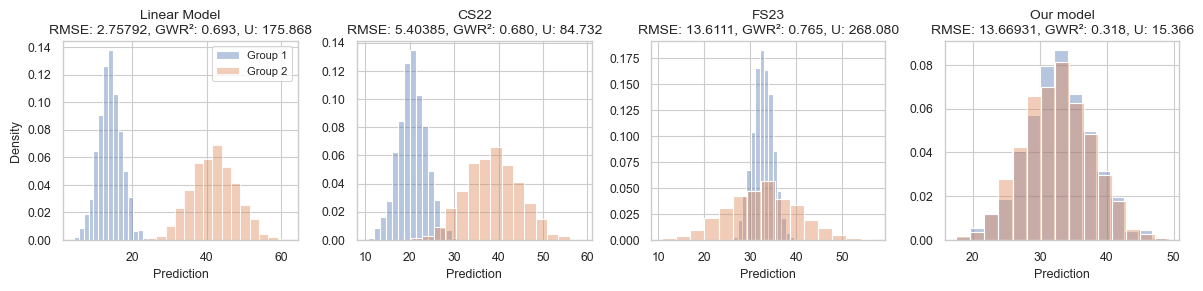

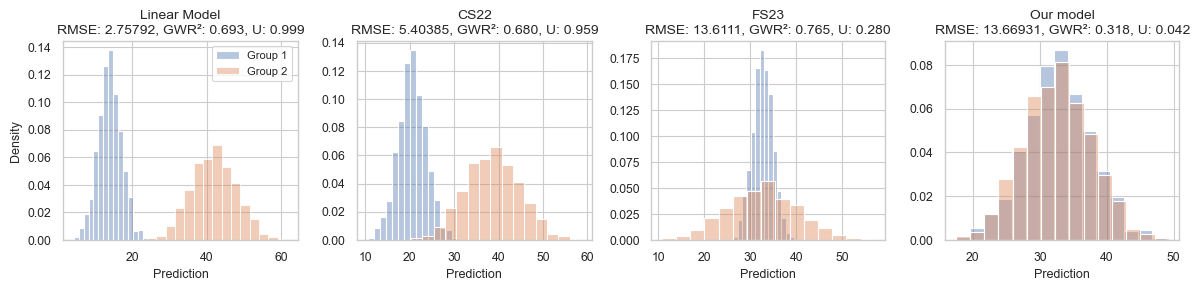

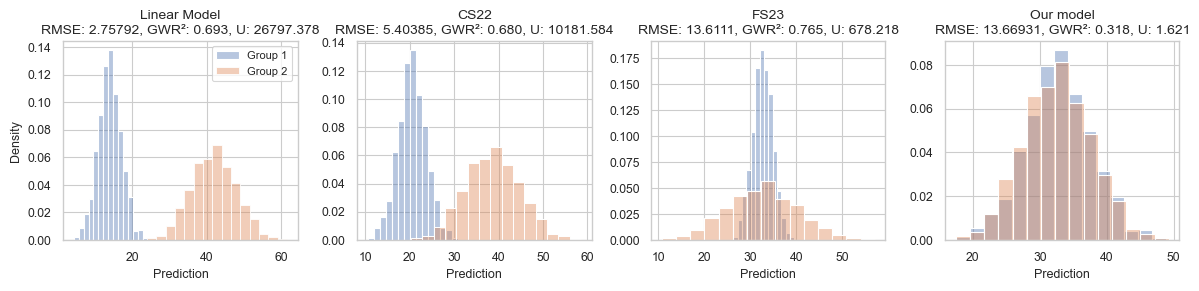

In [66]:
plot_direct_mu_std_bias_computation = plot_scores_densities(all_results_mean_std[3],'unfairness_computed_mean',test_dataset_mean_std, save_path=None)
plot_direct_mu_std_bias_kstest = plot_scores_densities(all_results_mean_std[3],'ks_stat_mean',test_dataset_mean_std, save_path=None,)
plot_direct_mu_std_bias_w2 = plot_scores_densities(all_results_mean_std[3],'unfairness_W2_mean',test_dataset_mean_std, save_path=None,)

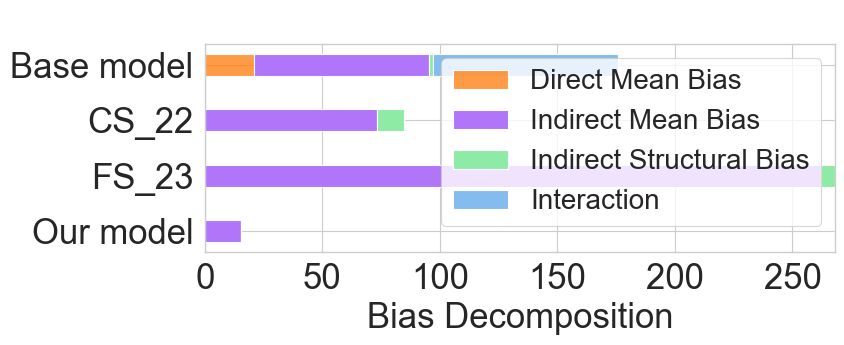

In [67]:
fig, ax = plot_bias_decomposition_by_model(results_df_exp_mean_std, test_dataset_mean_std)


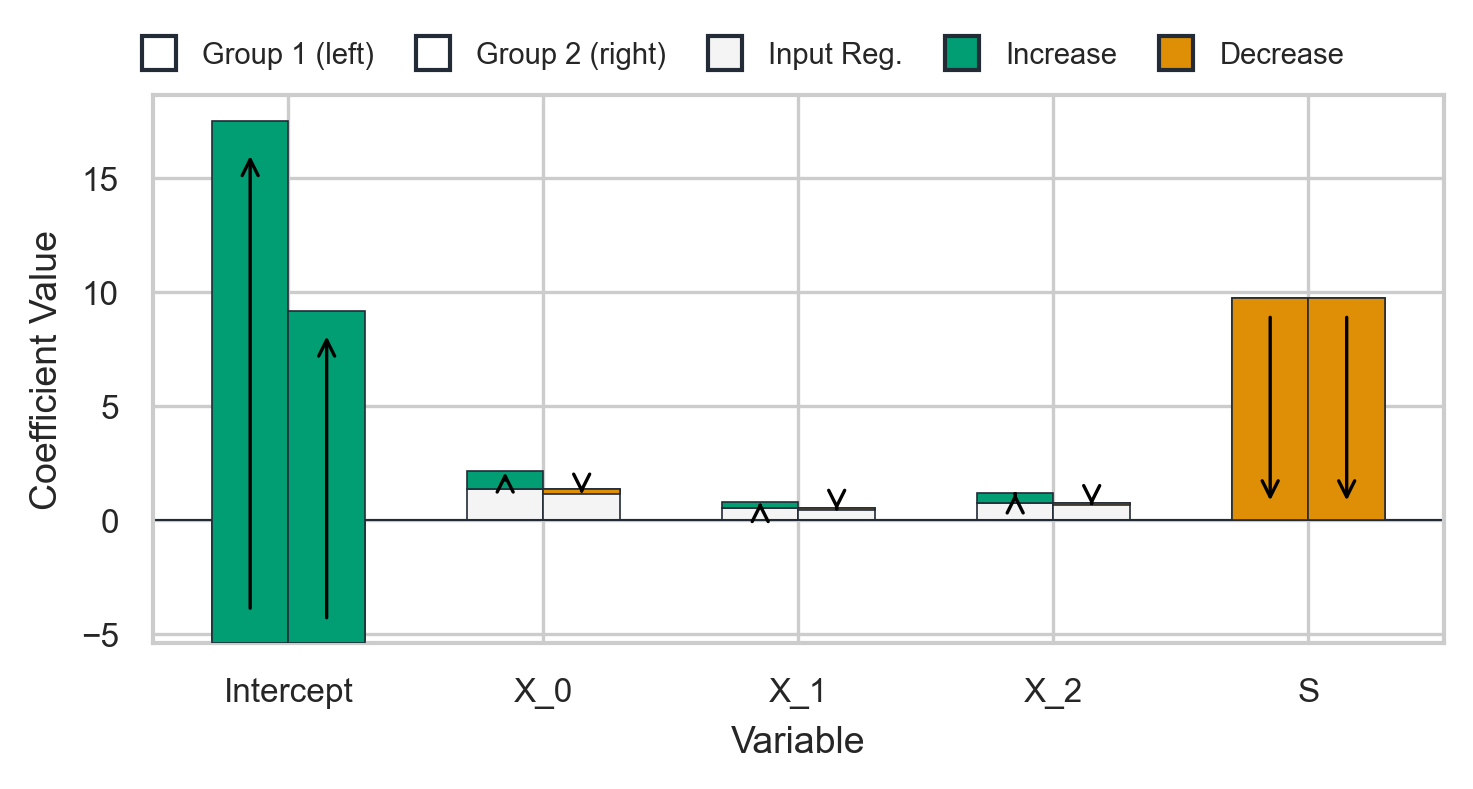

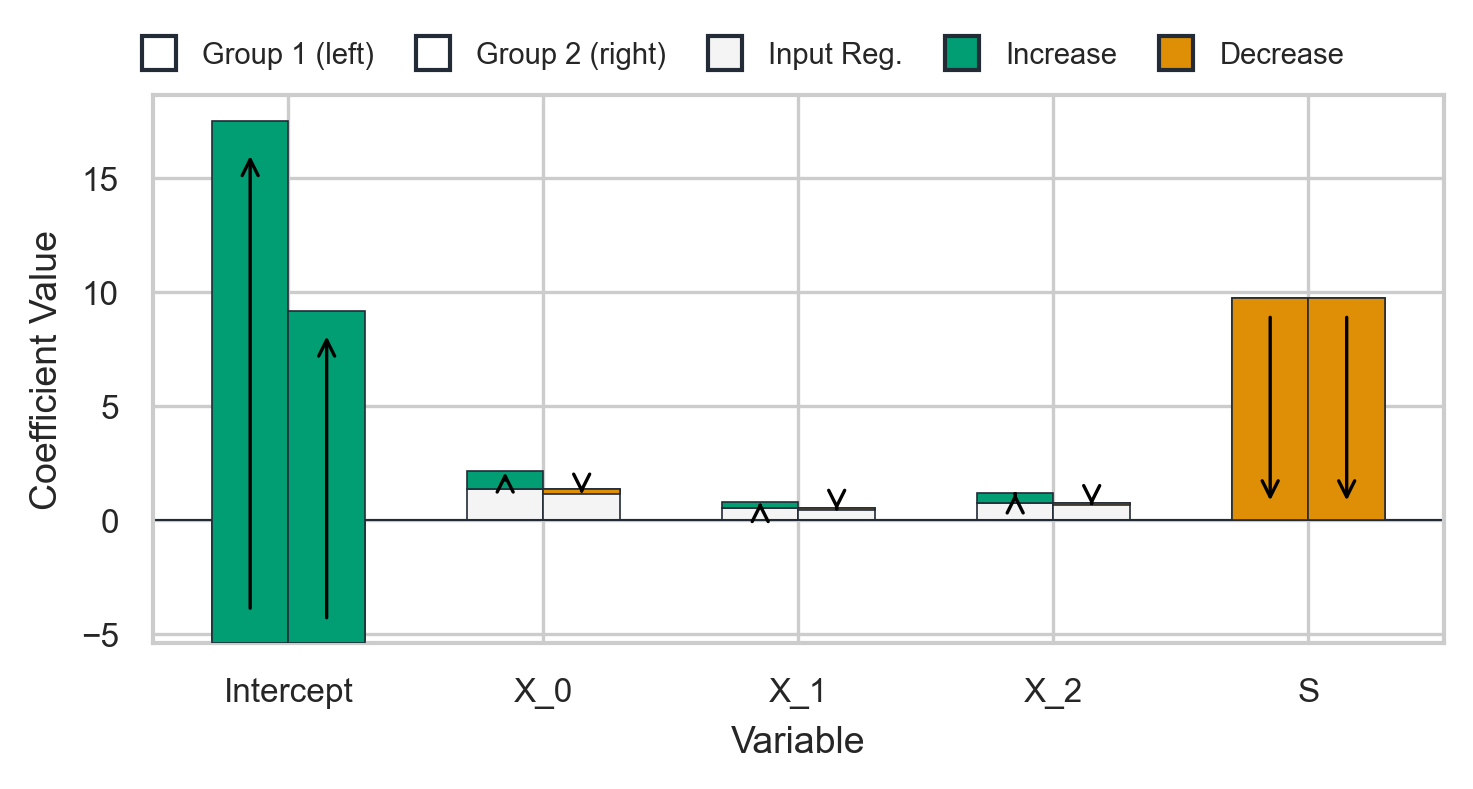

In [68]:
plot_fair_coefficient_evolution_with_decomposition(t_results_mean_std_bias, 3, 'Comparison of coef after remediation', None)

__All type of bias__

In [69]:
all_bias_params = current_params.copy()
all_bias_params.update({
    'random_seed': 7,
    't_unfair': 3,  # Sera remplacé par les valeurs variables
    'p_mu_bias': 2,
    'p_sigma_bias': 3, #5, #5
    't_correl':0.7, #0?5
})
all_bias_params_values= [10]

In [70]:
all_bias_params

{'y': 'Y',
 'S_variable': 'S',
 'additional_s': 0,
 'tho': 0.6,
 'nb_features': 5,
 'nb_obs': 20000,
 'n_simulations': 1,
 'random_seed': 7,
 't_unfair': 3,
 't_correl': 0.7,
 'p_mu_bias': 2,
 'p_sigma_bias': 3}

In [71]:
all_bias_params_values

[10]

In [72]:
t_results_all_bias, test_dataset_all_bias=run_experiment('t_unfair', all_bias_params_values, all_bias_params, True,False,True)

Processing t_unfair:   0%|          | 0/1 [00:11<?, ?it/s]


In [73]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

def plot_approximate_fairness(results_dict, unfairness_measure):
    """
    Crée un graphique GWR2 vs Unfairness pour différents modèles.
    
    Args:
        results_dict: Dictionnaire contenant les résultats des modèles.
                     Chaque clé est un nom de modèle et chaque valeur est un dictionnaire
                     contenant les métriques 'GWR2' et 'unfairness_W2'.
        unfairness_measure: La mesure d'unfairness à utiliser (ex: 'unfairness_W2')
    """
    # Création de la figure
    plt.figure(figsize=(5, 3))
    
    
    # Définition des modèles spéciaux avec leurs légendes
    special_models = {
        'y_pred_fair': 'Our Model',
        'y_input_reg': 'Linear Model',
        'y_pred_riken': 'FS23',
        'y_pred_bias': 'CS22'
    }
    
    # Couleurs colorblind-friendly avec les attributions demandées
    # Our model (vert), Base model (bleu), FS_23 (violet), CS_22 (rouge)
    colors_dict = {
        'y_pred_fair': "#03C175",  # Vert pour Our Model
        'y_input_reg': "#2B92C2",  # Bleu pour Base model
        'y_pred_riken': "#8B7DAD",  # Violet pour FS_23
        'y_pred_bias': "#D55E00"   # Rouge pour CS_22
    }
    
    # Marqueurs pour les modèles spéciaux
    markers_dict = {
        'y_pred_fair': '*',  # cercle
        'y_input_reg': 'o',  # carré
        'y_pred_riken': '^',  # triangle
        'y_pred_bias': 's'   # étoile
    }
    
    # Tracer les points spéciaux
    for model, label in special_models.items():
        if model in results_dict:
            plt.scatter(
                results_dict[model][unfairness_measure][0], 
                results_dict[model]['GWR2'][0],
                marker=markers_dict[model], 
                s=100, 
                color=colors_dict[model],
                label=label,
                alpha=0.8,
                edgecolors='black',
                linewidths=0.5
            )
    
    # Tracer les points y_pred_fair_0.1 à y_pred_fair_0.9
    epsilon_color = "#5EC2CF"  # Bleu clair pour les modèles avec epsilon
    for i in range(1, 10):
        epsilon = i / 10
        key = f'y_pred_fair_{epsilon}'
        if key in results_dict:
            plt.scatter(
                results_dict[key][unfairness_measure][0], 
                results_dict[key]['GWR2'][0],
                marker='o', 
                s=50, 
                color=epsilon_color,
                alpha=0.7,
                edgecolors='black',
                linewidths=0.5
            )
            
            # N'afficher l'annotation que pour epsilon=0.1
            if epsilon == 0.1:
                plt.annotate(
                    f'ε²={epsilon}', 
                    (results_dict[key][unfairness_measure][0], results_dict[key]['GWR2'][0]),
                    xytext=(5, -10), 
                    textcoords='offset points',
                    fontsize=11
                )
    
    # Ajout des labels et de la légende
    plt.xlabel('Unfairness', fontsize=12)
    plt.ylabel('GWR2', fontsize=12)
    plt.title(' ', fontsize=14)
    
    # Créer une légende personnalisée qui inclut f_epsilon
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Ajouter un élément pour f_epsilon
    epsilon_handle = Line2D([0], [0], marker='o', color='w', 
                           markerfacecolor=epsilon_color, 
                           markersize=8, 
                           markeredgecolor='black',
                           markeredgewidth=0.5,
                           label='f_ε²')
    
    handles.append(epsilon_handle)
    labels.append('f_ε²')
    
    plt.legend(handles=handles, labels=labels, title='Models', loc='best', frameon=True)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Ajustement des limites des axes si nécessaire
    plt.tight_layout()
    
    return plt.gcf()  # Retourne la figure pour une utilisation ultérieure si nécessaire


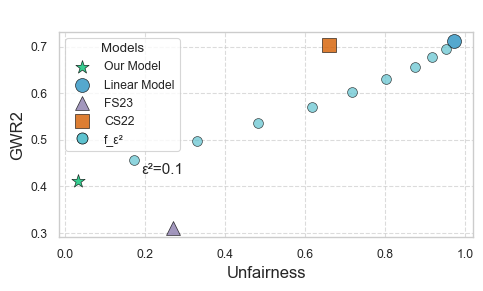

In [74]:
# t_results_no_bias, test_dataset_no_bias=run_experiment('t_unfair', no_bias_params_values, no_bias_params, True,False,True)
plot = plot_approximate_fairness(t_results_all_bias,'ks_stat')

In [75]:
print('decomposition', t_results_all_bias['y_input_reg']['direct_mean_bias'][0] + t_results_all_bias['y_input_reg']['indirect_mean_bias'][0]+t_results_all_bias['y_input_reg']['indirect_structural_bias'][0] + t_results_all_bias['y_input_reg']['interaction'][0])
print('equation (6)', t_results_all_bias['y_input_reg']['total_unfairness'][0] )
print('equation (6)', t_results_all_bias['y_input_reg']['first_moment_disparity'][0] + t_results_all_bias['y_input_reg']['second_moment_disparity'][0] )

decomposition 89.64371630107327
equation (6) 89.28600868293309
equation (6) 89.28600868293309


In [76]:
all_results_std, results_df_exp_std, test_dataset_std,pool_dataset_std, param_dictionnary_std=run_experiment(
    varying_param='t_unfair', 
    param_values=[3], 
    fixed_params=all_bias_params, 
    coefficients_analysis=False,
    bool_coef=0.7, 
    bool_approximate_fairness=True)
# marginal_contribution = pd.DataFrame(calculate_marginal_contributions(test_dataset_std, X_features, 'S', param_dictionnary_std))

Processing t_unfair:   0%|          | 0/1 [00:00<?, ?it/s]

Processing t_unfair: 100%|██████████| 1/1 [00:11<00:00, 11.75s/it]


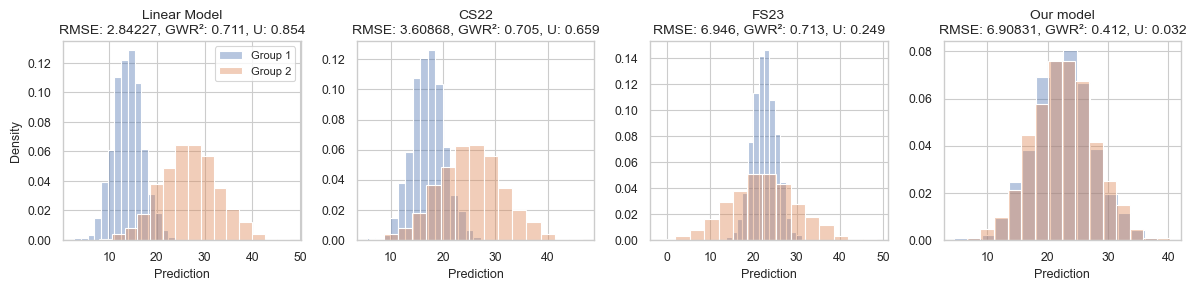

In [78]:
plot_direct_mu_std_bias_kstest = plot_scores_densities(all_results_std[3],'ks_stat_mean',test_dataset_std, save_path=None,)


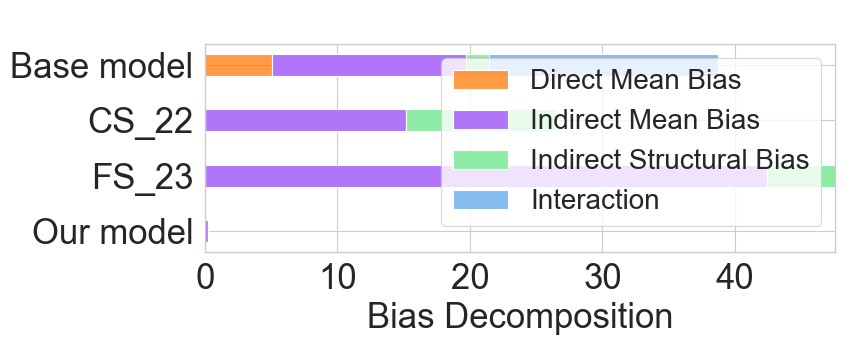

(<Figure size 900x400 with 1 Axes>,
 <Axes: title={'center': ' '}, xlabel='Bias Decomposition'>)

In [79]:
plot_bias_decomposition_by_model(results_df_exp_std, test_dataset_std)


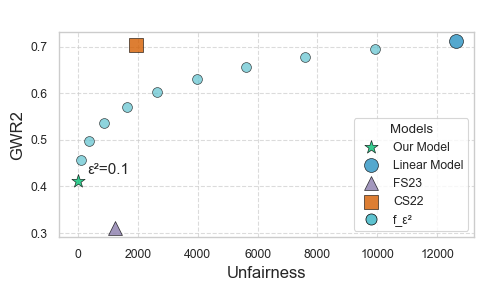

In [80]:
plot = plot_approximate_fairness(t_results_all_bias,'unfairness_W2')

In [81]:
# fig = plot_scores_densities(test_dataset_all_bias, save_path=None)
#"AAAI figures and code/figures/densities__seed_7__Ty_3.png"

In [82]:
def plot_scores_densities(t_results,unfairness_measure, test_dataset, save_path=None):
    """Displays the density distribution of the main models.

    Args:
        test_dataset: The dataset containing the predictions
        save_path: Path to save the figure (optional)

    Returns:
        The figure object
    """
    # Select only the models we want to display
    display_models = ['y_input_reg', 'y_pred_bias', 'y_pred_riken', 'y_pred_fair']
    display_titles = ['Linear Model', 'CS22', 'FS23', 'Our model']
    
    # Create figure with 4 subplots (one for each selected model)
    fig, axes = plt.subplots(1, len(display_models), figsize=(12, 3))
    
    # For each model
    for i, model in enumerate(display_models):
        if model in test_dataset.columns:
            # Calculate metrics for the title
            r2 = Metrics.group_weighted_r2(test_dataset, 'Y', model, 'S')
            rmse=round(np.sqrt(mean_squared_error(test_dataset['Y'], test_dataset[model])),2)
            # w2_unfairness = Metrics.unfairness_computation(model, 'S', test_dataset)
            unfairness = round(t_results[model][unfairness_measure],2)
            
            # Plot histograms
            sns.histplot(
                test_dataset[test_dataset['S']==1][model],
                label='Group 1',
                stat='density',
                bins=15,
                alpha=0.4,
                ax=axes[i])
            sns.histplot(
                test_dataset[test_dataset['S']==2][model],
                label='Group 2',
                stat='density',
                bins=15,
                alpha=0.4,
                ax=axes[i])
            
            # Set title with metrics
            axes[i].set_title(f"{display_titles[i]}\nRMSE: {rmse}, GWR²: {r2:.3f}, U: {unfairness:.3f}", fontsize=11)
            
            # Clean up axes
            axes[i].set_xlabel("Prediction", fontsize=11)
            if i == 0:
                axes[i].set_ylabel("Density", fontsize=11)
                axes[i].legend(fontsize=8)
            else:
                axes[i].set_ylabel("")
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig


In [83]:
def plot_scores_densities(t_results, unfairness_measure, test_dataset, save_path=None, tick_fontsize=10):
    """Displays the density distribution of the main models.

    Args:
        t_results: Dictionary containing the results metrics
        unfairness_measure: The unfairness measure to display
        test_dataset: The dataset containing the predictions
        save_path: Path to save the figure (optional)
        tick_fontsize: Font size for the tick labels (default: 8)

    Returns:
        The figure object
    """
    # Select only the models we want to display
    display_models = ['y_input_reg', 'y_pred_bias', 'y_pred_riken', 'y_pred_fair']
    display_titles = ['Linear Model', 'CS22', 'FS23', 'Our model']
    
    # Create figure with 4 subplots (one for each selected model)
    fig, axes = plt.subplots(1, len(display_models), figsize=(12, 2))
    
    # For each model
    for i, model in enumerate(display_models):
        if model in test_dataset.columns:
            # Calculate metrics for the title
            r2 = Metrics.group_weighted_r2(test_dataset, 'Y', model, 'S')
            rmse = round(np.sqrt(mean_squared_error(test_dataset['Y'], test_dataset[model])), 2)
            unfairness = round(t_results[model][unfairness_measure], 2)
            
            # Plot histograms
            sns.histplot(
                test_dataset[test_dataset['S']==1][model],
                label='Group 1',
                stat='density',
                bins=15,
                alpha=0.4,
                ax=axes[i])
            sns.histplot(
                test_dataset[test_dataset['S']==2][model],
                label='Group 2',
                stat='density',
                bins=15,
                alpha=0.4,
                ax=axes[i])
            
            # Set title with metrics
            axes[i].set_title(f"{display_titles[i]}\nRMSE: {rmse}, GWR²: {r2:.3f}, U: {unfairness:.3f}", fontsize=12)
            
            # Clean up axes
            axes[i].set_xlabel("Prediction", fontsize=12)
            
            # Réduire la taille des chiffres sur les axes
            axes[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
            
            if i == 0:
                axes[i].set_ylabel("Density", fontsize=12)
                axes[i].legend(fontsize=8)
            else:
                axes[i].set_ylabel("")
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig


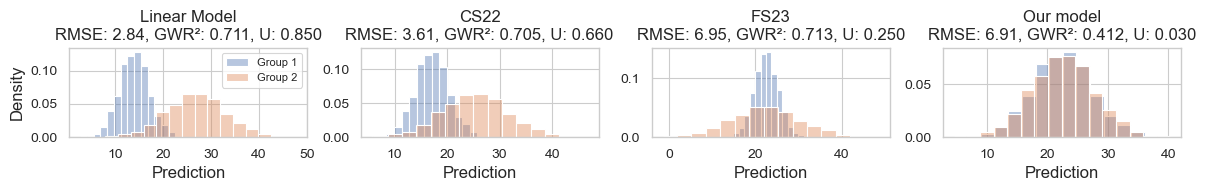

In [85]:
# plot_direct_mu_std_corr_bias_computation = plot_scores_densities(all_results_std[10],'unfairness_computed_mean',test_dataset_std, save_path=None)
plot_direct_mu_std_corr_bias_kstest = plot_scores_densities(all_results_std[3],'ks_stat_mean',test_dataset_std, save_path=None,)
# plot_direct_mu_std_corr_bias_w2 = plot_scores_densities(all_results_std[10],'unfairness_W2_mean',test_dataset_std, save_path=None,)

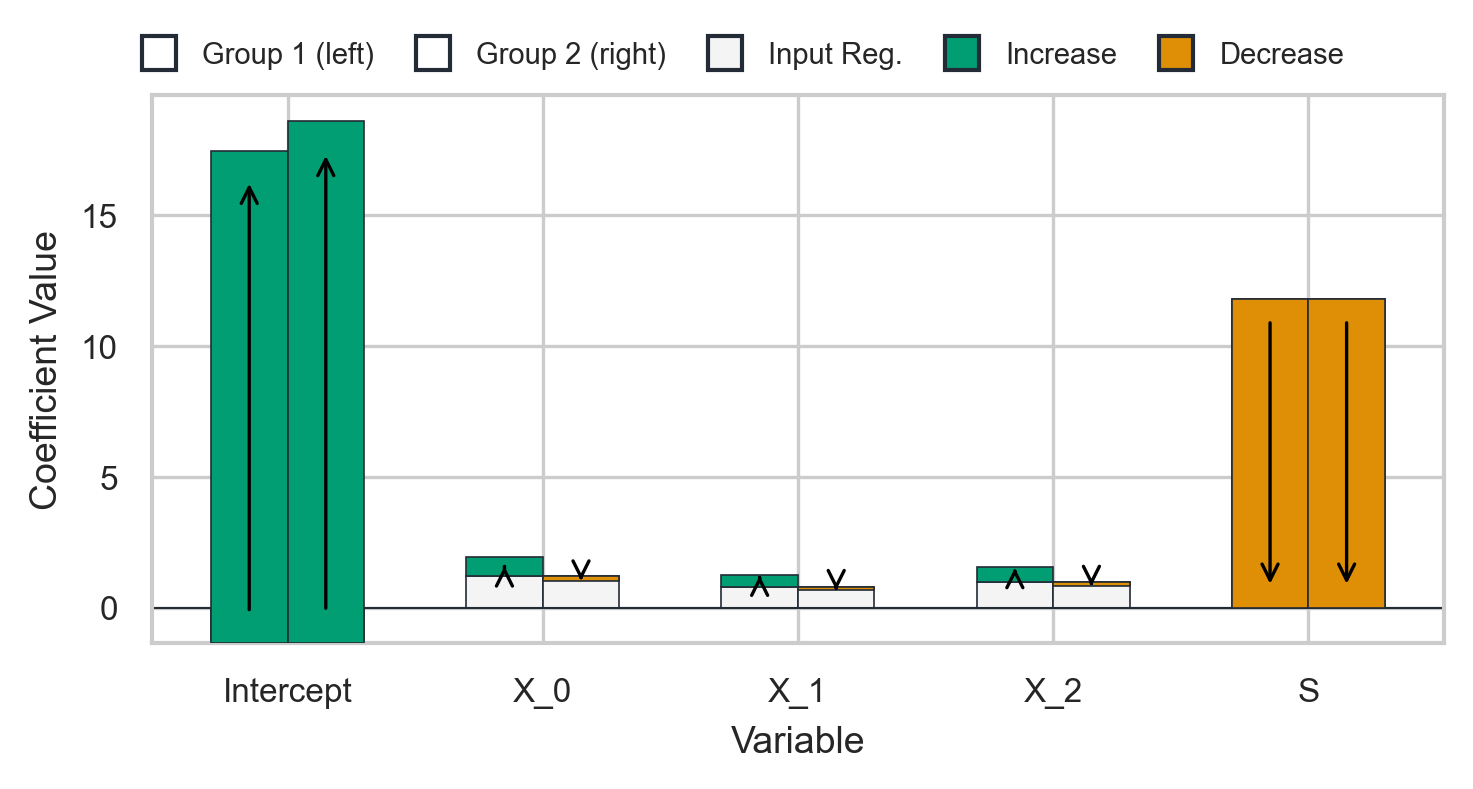

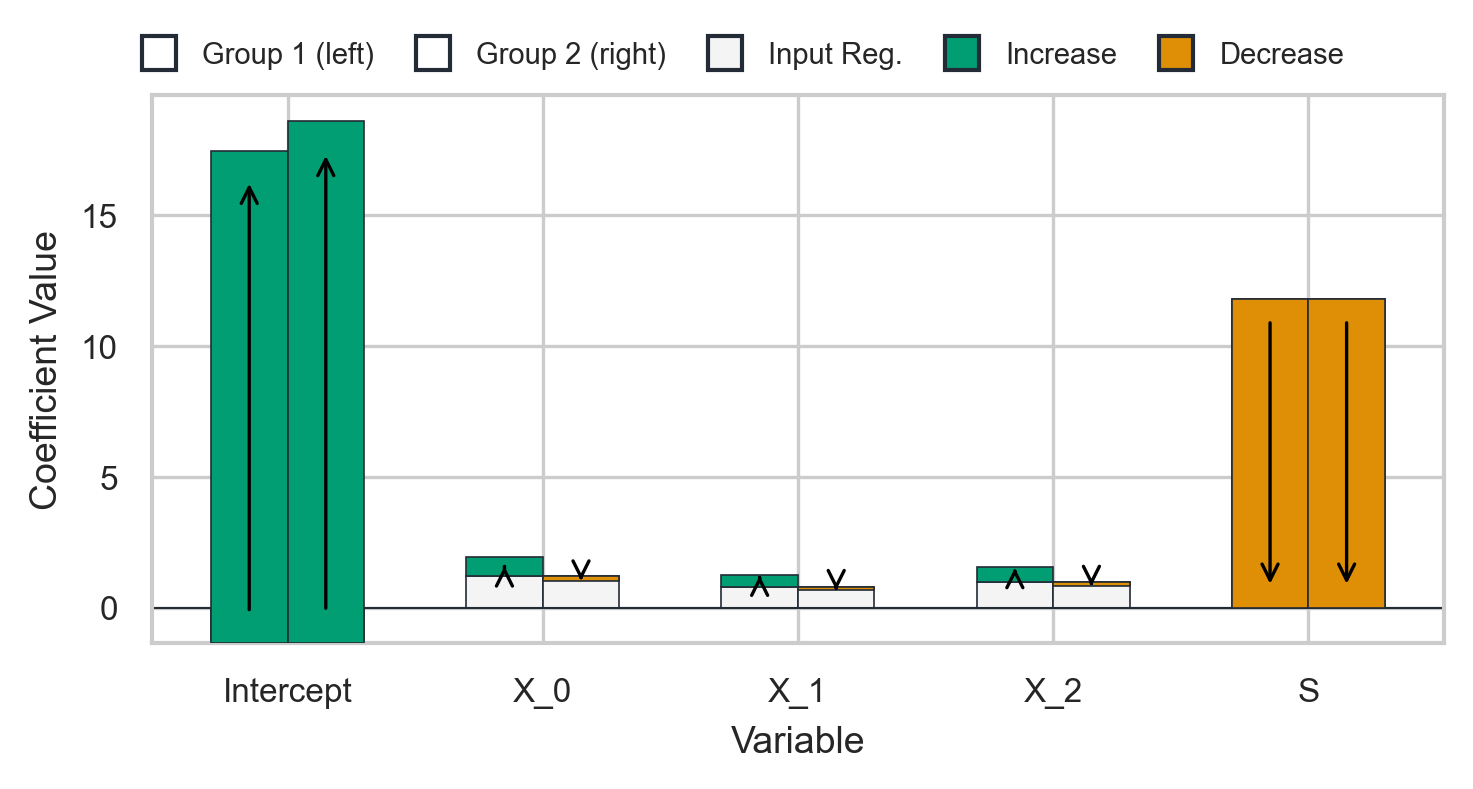

In [86]:
plot_fair_coefficient_evolution_with_decomposition(t_results_all_bias, 3, 'Comparison of coef after remediation', None)

In [87]:
print(test_dataset_all_bias[X_features].corr())
print(test_dataset_all_bias[test_dataset_all_bias['S']==1][X_features].corr())
print(test_dataset_all_bias[test_dataset_all_bias['S']==2][X_features].corr())

          X_0       X_1       X_2       X_3
X_0  1.000000  0.320165  0.115763  0.096598
X_1  0.320165  1.000000 -0.328637 -0.203757
X_2  0.115763 -0.328637  1.000000  0.306188
X_3  0.096598 -0.203757  0.306188  1.000000
          X_0       X_1       X_2       X_3
X_0  1.000000  0.191674  0.117755 -0.142904
X_1  0.191674  1.000000 -0.350362 -0.261242
X_2  0.117755 -0.350362  1.000000  0.619738
X_3 -0.142904 -0.261242  0.619738  1.000000
          X_0       X_1       X_2       X_3
X_0  1.000000  0.264288  0.010635 -0.020834
X_1  0.264288  1.000000 -0.530595 -0.439147
X_2  0.010635 -0.530595  1.000000  0.142020
X_3 -0.020834 -0.439147  0.142020  1.000000


__Analysis of unfairness__

In [88]:
all_bias_params = current_params.copy()
all_bias_params.update({
    'random_seed': 7,
    't_unfair': 3,  # Sera remplacé par les valeurs variables
    'p_mu_bias': 2,
    'p_sigma_bias': 5, #5
    't_correl':0, #0?5
})
all_bias_params_values= [3]

In [89]:
all_results_unfairness, results_unfairness, test_dataset_unfairness,pool_dataset_unfairness, param_dictionnary_unfairness=run_experiment(
    varying_param='t_unfair', 
    param_values=all_bias_params_values, 
    fixed_params=all_bias_params, 
    coefficients_analysis=False,
    bool_coef=False, 
    bool_approximate_fairness=True)
# pd.DataFrame(calculate_marginal_contributions(test_dataset_unfairness, X_features, 'S', param_dictionnary_unfairness))

Processing t_unfair: 100%|██████████| 1/1 [00:16<00:00, 16.27s/it]


In [90]:
# test_dataset_unfairness[test_dataset_unfairness['S']==1][X_features].corr()

__Variation__

In [91]:
all_results_unfairness,results_unfairness, test_dataset_unfairness,pool_dataset_unfairness, param_dictionnary_unfairness=run_experiment(
    varying_param='t_unfair', 
    param_values=[0,1,2], 
    fixed_params=all_bias_params, 
    coefficients_analysis=False,
    bool_coef=False, 
    bool_approximate_fairness=True)
# pd.DataFrame(calculate_marginal_contributions(test_dataset_unfairness, X_features, 'S', param_dictionnary_unfairness))

Processing t_unfair: 100%|██████████| 3/3 [00:28<00:00,  9.50s/it]


__Approximate fairness__

In [92]:
all_results_all_bias, results_df_exp_all_bias, test_dataset_all_bias,pool_dataset_all_bias, param_dictionnary_all_bias=run_experiment(
    varying_param='t_unfair', 
    param_values=all_bias_params_values, 
    fixed_params=all_bias_params, 
    coefficients_analysis=False,
    bool_coef=False, 
    bool_approximate_fairness=True)

Processing t_unfair: 100%|██████████| 1/1 [00:10<00:00, 10.03s/it]


__Final graphs__

In [93]:
def plot_rmse_vs_unfairness(all_results, t_values, metric):
    # Définir les modèles et leurs noms d'affichage
    models = ['y_input_reg', 'y_pred_bias', 'y_pred_riken', 'y_pred_fair']
    display_names = ['Linear model', 'CS_22', 'FS_23', 'Our model']
    
    # Définir les couleurs et marqueurs pour chaque modèle
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # bleu, orange, vert, rouge
    markers = ['o', 's', '^', '*']  # cercle, carré, triangle, étoile
    
    # Créer la figure
    plt.figure(figsize=(6, 4))
    
    # Pour chaque modèle
    for i, (model, display_name) in enumerate(zip(models, display_names)):
        rmse_values = []
        unfairness_values = []
        
        # Collecter les valeurs pour chaque t
        for t in t_values:
            if t in all_results and model in all_results[t]:
                rmse = all_results[t][model].get(f'{metric}_mean')
                unfairness = all_results[t][model].get('unfairness_W2_mean')
                
                if rmse is not None and unfairness is not None:
                    rmse_values.append(rmse)
                    unfairness_values.append(unfairness)
        
        # Tracer les points pour ce modèle
        plt.scatter(unfairness_values, rmse_values, 
                   label=display_name, 
                   color=colors[i], 
                   marker=markers[i], 
                   s=100,
                   alpha=0.8,
                   edgecolors='black',
                   linewidths=0.5)
        
        # Ajouter des annotations pour les valeurs de t
        for j, t in enumerate(t_values):
            if j < len(rmse_values):
                plt.annotate(f"T={t}", 
                           (unfairness_values[j], rmse_values[j]),
                           textcoords="offset points",
                           xytext=(0, 5),
                           ha='center',
                           fontsize=8)
    
    # Ajouter des titres et des étiquettes
    # plt.title( , fontsize=14)
    plt.xlabel('Unfairness', fontsize=12)
    plt.ylabel(f'{metric}', fontsize=12)
    
    # Ajouter une légende
    plt.legend(title='Models', loc='best', frameon=True)
    
    # Ajouter une grille
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Ajuster les limites des axes si nécessaire
    # plt.xlim(0, max_unfairness * 1.1)
    # plt.ylim(min_r2 * 0.9, 1.0)
    
    plt.tight_layout()
    
    return plt.gcf()

# Exemple d'utilisation:
# fig = plot_r2_vs_unfairness(all_results, t_values)
# plt.savefig('r2_vs_unfairness.png', dpi=300, bbox_inches='tight')
# plt.show()


In [94]:
all_bias_params['t_correl']=0.7
all_bias_params['p_sigma_bias']=2
all_bias_params['p_mu_bias']=2
all_bias_params['t_unfair']=10
all_bias_params

{'y': 'Y',
 'S_variable': 'S',
 'additional_s': 0,
 'tho': 0.6,
 'nb_features': 5,
 'nb_obs': 20000,
 'n_simulations': 1,
 'random_seed': 7,
 't_unfair': 10,
 't_correl': 0.7,
 'p_mu_bias': 2,
 'p_sigma_bias': 2}

In [95]:
def plot_rmse_vs_unfairness(all_results, t_values, perf_metric, unf_metric):
    # Définir les modèles et leurs noms d'affichage
    models = ['y_input_reg', 'y_pred_bias', 'y_pred_riken', 'y_pred_fair']
    display_names = ['Linear model', 'CS_22', 'FS_23', 'Our model']
    
    # Définir les couleurs et marqueurs pour chaque modèle
    colors = colors = ["#2B92C2", "#E89B0D", "#03C175", "#D55E00"] # bleu, orange, vert, rouge
    markers = ['o', 's', '^', '*']  # cercle, carré, triangle, étoile
    
    # Créer la figure
    plt.figure(figsize=(5, 3))
    
    # Pour chaque modèle
    for i, (model, display_name) in enumerate(zip(models, display_names)):
        rmse_values = []
        unfairness_values = []
        
        # Collecter les valeurs pour chaque t
        for t in t_values:
            if t in all_results and model in all_results[t]:
                rmse = all_results[t][model].get(f'{perf_metric}_mean')
                unfairness = all_results[t][model].get(f'{unf_metric}_mean')
                
                if rmse is not None and unfairness is not None:
                    rmse_values.append(rmse)
                    unfairness_values.append(unfairness)
        
        # Tracer les points pour ce modèle
        plt.scatter(unfairness_values, rmse_values, 
                   label=display_name, 
                   color=colors[i], 
                   marker=markers[i], 
                   s=100,
                   alpha=0.8,
                   edgecolors='black',
                   linewidths=0.5)
        
        # Ajouter des annotations pour les valeurs de t
        # Ne pas ajouter d'annotations pour "Our model" et "CS_22"
        if display_name not in ["Our model", "CS_22"]:
            for j, t in enumerate([0]):
                if j < len(rmse_values):
                    plt.annotate(f"T={t}", 
                               (unfairness_values[j], rmse_values[j]),
                               textcoords="offset points",
                               xytext=(0, 5),
                               ha='center',
                               fontsize=10)
            for j, t in enumerate([3,6,9,12,15]):
                if j < len(rmse_values):
                    x_offset = 1
                    y_offset = -3
                    plt.annotate(f"{t}", 
                               (unfairness_values[j+1], rmse_values[j+1]),
                               textcoords="offset points",
                               xytext=(0, 5),
                               ha='center',
                               fontsize=10)
    
    # Ajouter des titres et des étiquettes
    # plt.title( , fontsize=14)
    plt.xlabel('Unfairness', fontsize=12)
    plt.ylabel(f'{perf_metric}', fontsize=12)
    
    # Ajouter une légende
    plt.legend(title='Models', loc='best', frameon=True)
    
    # Ajouter une grille
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Ajuster les limites des axes si nécessaire
    # plt.xlim(0, max_unfairness * 1.1)
    # plt.ylim(min_r2 * 0.9, 1.0)
    
    plt.tight_layout()
    
    return plt.gcf()


In [96]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

def plot_approximate_fairness(results_dict, unfairness_measure):
    """
    Crée un graphique GWR2 vs Unfairness pour différents modèles.
    
    Args:
        results_dict: Dictionnaire contenant les résultats des modèles.
                     Chaque clé est un nom de modèle et chaque valeur est un dictionnaire
                     contenant les métriques 'GWR2' et 'unfairness_W2'.
        unfairness_measure: La mesure d'unfairness à utiliser (ex: 'unfairness_W2')
    """
    # Création de la figure
    plt.figure(figsize=(3, 1))
    
    # Définition des modèles spéciaux avec leurs légendes
    special_models = {
        'y_pred_fair': 'Our Model',
        'y_input_reg': 'Base model',
        'y_pred_riken': 'FS23',
        'y_pred_bias': 'CS22'
    }
    
    # Couleurs colorblind-friendly avec les attributions demandées
    # Our model (vert), Base model (bleu), FS_23 (violet), CS_22 (rouge)
    colors_dict = {
        'y_pred_fair': "#03C175",  # Vert pour Our Model
        'y_input_reg': "#2B92C2",  # Bleu pour Base model
        'y_pred_riken': "#8B7DAD",  # Violet pour FS_23
        'y_pred_bias': "#D55E00"   # Rouge pour CS_22
    }
    
    # Marqueurs pour les modèles spéciaux
    markers_dict = {
        'y_pred_fair': '*',  # cercle
        'y_input_reg': 'o',  # carré
        'y_pred_riken': '^',  # triangle
        'y_pred_bias': 's'   # étoile
    }
    
    # Tracer les points spéciaux
    for model, label in special_models.items():
        if model in results_dict:
            plt.scatter(
                results_dict[model][unfairness_measure][0], 
                results_dict[model]['GWR2'][0],
                marker=markers_dict[model], 
                s=100, 
                color=colors_dict[model],
                label=label,
                alpha=0.8,
                edgecolors='black',
                linewidths=0.5
            )
    
    # Tracer les points y_pred_fair_0.1 à y_pred_fair_0.9
    epsilon_color = "#5EC2CF"  # Bleu clair pour les modèles avec epsilon
    for i in range(1, 10):
        epsilon = i / 10
        key = f'y_pred_fair_{epsilon}'
        if key in results_dict:
            plt.scatter(
                results_dict[key][unfairness_measure][0], 
                results_dict[key]['GWR2'][0],
                marker='o', 
                s=50, 
                color=epsilon_color,
                alpha=0.7,
                edgecolors='black',
                linewidths=0.5
            )
            
            # N'afficher l'annotation que pour epsilon=0.1
            if epsilon == 0.1:
                plt.annotate(
                    f'ε={epsilon}', 
                    (results_dict[key][unfairness_measure][0], results_dict[key]['GWR2'][0]),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=8
                )
    
    # Ajout des labels et de la légende
    plt.xlabel('Unfairness', fontsize=12)
    plt.ylabel('GWR2', fontsize=12)
    plt.title(' ', fontsize=14)
    
    # Créer une légende personnalisée qui inclut f_epsilon
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Ajouter un élément pour f_epsilon
    epsilon_handle = Line2D([0], [0], marker='o', color='w', 
                           markerfacecolor=epsilon_color, 
                           markersize=8, 
                           markeredgecolor='black',
                           markeredgewidth=0.5,
                           label='f_ε')
    
    handles.append(epsilon_handle)
    labels.append('f_ε')
    
    plt.legend(handles=handles, labels=labels, title='Models', loc='best', frameon=True)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Ajustement des limites des axes si nécessaire
    plt.tight_layout()
    
    return plt.gcf()  # Retourne la figure pour une utilisation ultérieure si nécessaire


In [97]:
def plot_rmse_vs_unfairness(all_results, t_values, perf_metric, unf_metric):
    # Définir les modèles et leurs noms d'affichage
    models = ['y_input_reg', 'y_pred_bias', 'y_pred_riken', 'y_pred_fair']
    display_names = ['Linear model', 'CS_22', 'FS_23', 'Our model']
    
    # Définir les couleurs colorblind-friendly
    # Palette colorblind-friendly: bleu, orange, vert jaunâtre, rouge-violet
    colors = ["#2B92C2", "#D55E00", "#8B7DAD", "#03C175"]
    #  'y_pred_fair': "#03C175",  # Vert pour Our Model
    #     'y_input_reg': "#2B92C2",  # Bleu pour Base model
    #     'y_pred_riken': "#8B7DAD",  # Violet pour FS_23
    #     'y_pred_bias': "#D55E00"   # Rouge pour CS_22
    markers = ['o', 's', '^', '*']  # cercle, carré, triangle, étoile
    
    # Créer la figure
    plt.figure(figsize=(5, 3))
    
    # Pour chaque modèle
    for i, (model, display_name) in enumerate(zip(models, display_names)):
        rmse_values = []
        unfairness_values = []
        
        # Collecter les valeurs pour chaque t
        for t in t_values:
            if t in all_results and model in all_results[t]:
                rmse = all_results[t][model].get(f'{perf_metric}_mean')
                unfairness = all_results[t][model].get(f'{unf_metric}_mean')
                
                if rmse is not None and unfairness is not None:
                    rmse_values.append(rmse)
                    unfairness_values.append(unfairness)
        
        # Tracer les points pour ce modèle
        plt.scatter(unfairness_values, rmse_values, 
                   label=display_name, 
                   color=colors[i], 
                   marker=markers[i], 
                   s=100,
                   alpha=0.8,
                   edgecolors='black',
                   linewidths=0.5)
        
        # Ajouter des annotations pour les valeurs de t
        # Ne pas ajouter d'annotations pour "Our model" et "CS_22"
        if display_name == "Linear model":
            # Pour Linear model, annoter T=0, T=3, T=6 seulement
            for j, t in enumerate([0]):
                if j < len(rmse_values):
                    plt.annotate(f"T={t}", 
                               (unfairness_values[j], rmse_values[j]),
                               textcoords="offset points",
                               xytext=(0, 5),
                               ha='center',
                               fontsize=10)
            for j, t in enumerate([3, 6]):  # Limité à 3 et 6 seulement
                if j+1 < len(rmse_values):
                    plt.annotate(f"{t}", 
                               (unfairness_values[j+1], rmse_values[j+1]),
                               textcoords="offset points",
                               xytext=(0, 5),
                               ha='center',
                               fontsize=10)
        elif display_name == "FS_23":
            # Pour FS_23, décaler les annotations vers la droite
            for j, t in enumerate([0]):
                if j < len(rmse_values):
                    plt.annotate(f"T={t}", 
                               (unfairness_values[j], rmse_values[j]),
                               textcoords="offset points",
                               xytext=(10, 0),  # Décalage vers la droite (x=10)
                               ha='center',
                               fontsize=10)
            for j, t in enumerate([3, 6, 9, 12, 15]):
                if j+1 < len(rmse_values):
                    plt.annotate(f"{t}", 
                               (unfairness_values[j+1], rmse_values[j+1]),
                               textcoords="offset points",
                               xytext=(10, -3),  # Décalage vers la droite (x=10)
                               ha='center',
                               fontsize=10)
    
    # Ajouter des titres et des étiquettes
    # plt.title( , fontsize=14)
    plt.xlabel('Unfairness', fontsize=12)
    plt.ylabel(f'{perf_metric}', fontsize=12)
    
    # Ajouter une légende
    plt.legend(title='Models', loc='best', frameon=True)
    
    # Ajouter une grille
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Ajuster les limites des axes si nécessaire
    # plt.xlim(0, max_unfairness * 1.1)
    # plt.ylim(min_r2 * 0.9, 1.0)
    
    plt.tight_layout()
    
    return plt.gcf()


In [98]:
# plot = plot_rmse_vs_unfairness(t_y_results, [0,3,6,9,12,15], 'GWR2','unfairness_W2')

In [99]:
# plot = plot_rmse_vs_unfairness(t_y_results, [0,3,6,9,12,15], 'GWR2','unfairness_computed')

In [100]:
all_bias_params

{'y': 'Y',
 'S_variable': 'S',
 'additional_s': 0,
 'tho': 0.6,
 'nb_features': 5,
 'nb_obs': 20000,
 'n_simulations': 1,
 'random_seed': 7,
 't_unfair': 10,
 't_correl': 0.7,
 'p_mu_bias': 2,
 'p_sigma_bias': 2}

In [101]:
t_y_results, results_df_exp, test_dataset,pool_dataset, param_dictionnary=run_experiment(
    varying_param='t_unfair', 
    param_values=[0,5,10], 
    fixed_params=all_bias_params, 
    coefficients_analysis=False,
    bool_coef=True, 
    bool_approximate_fairness=False)

Processing t_unfair: 100%|██████████| 3/3 [00:19<00:00,  6.55s/it]


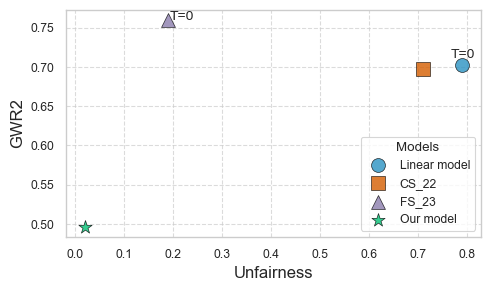

In [102]:
plot = plot_rmse_vs_unfairness(t_y_results, [0,3,6,9,12,15], 'GWR2','ks_stat')

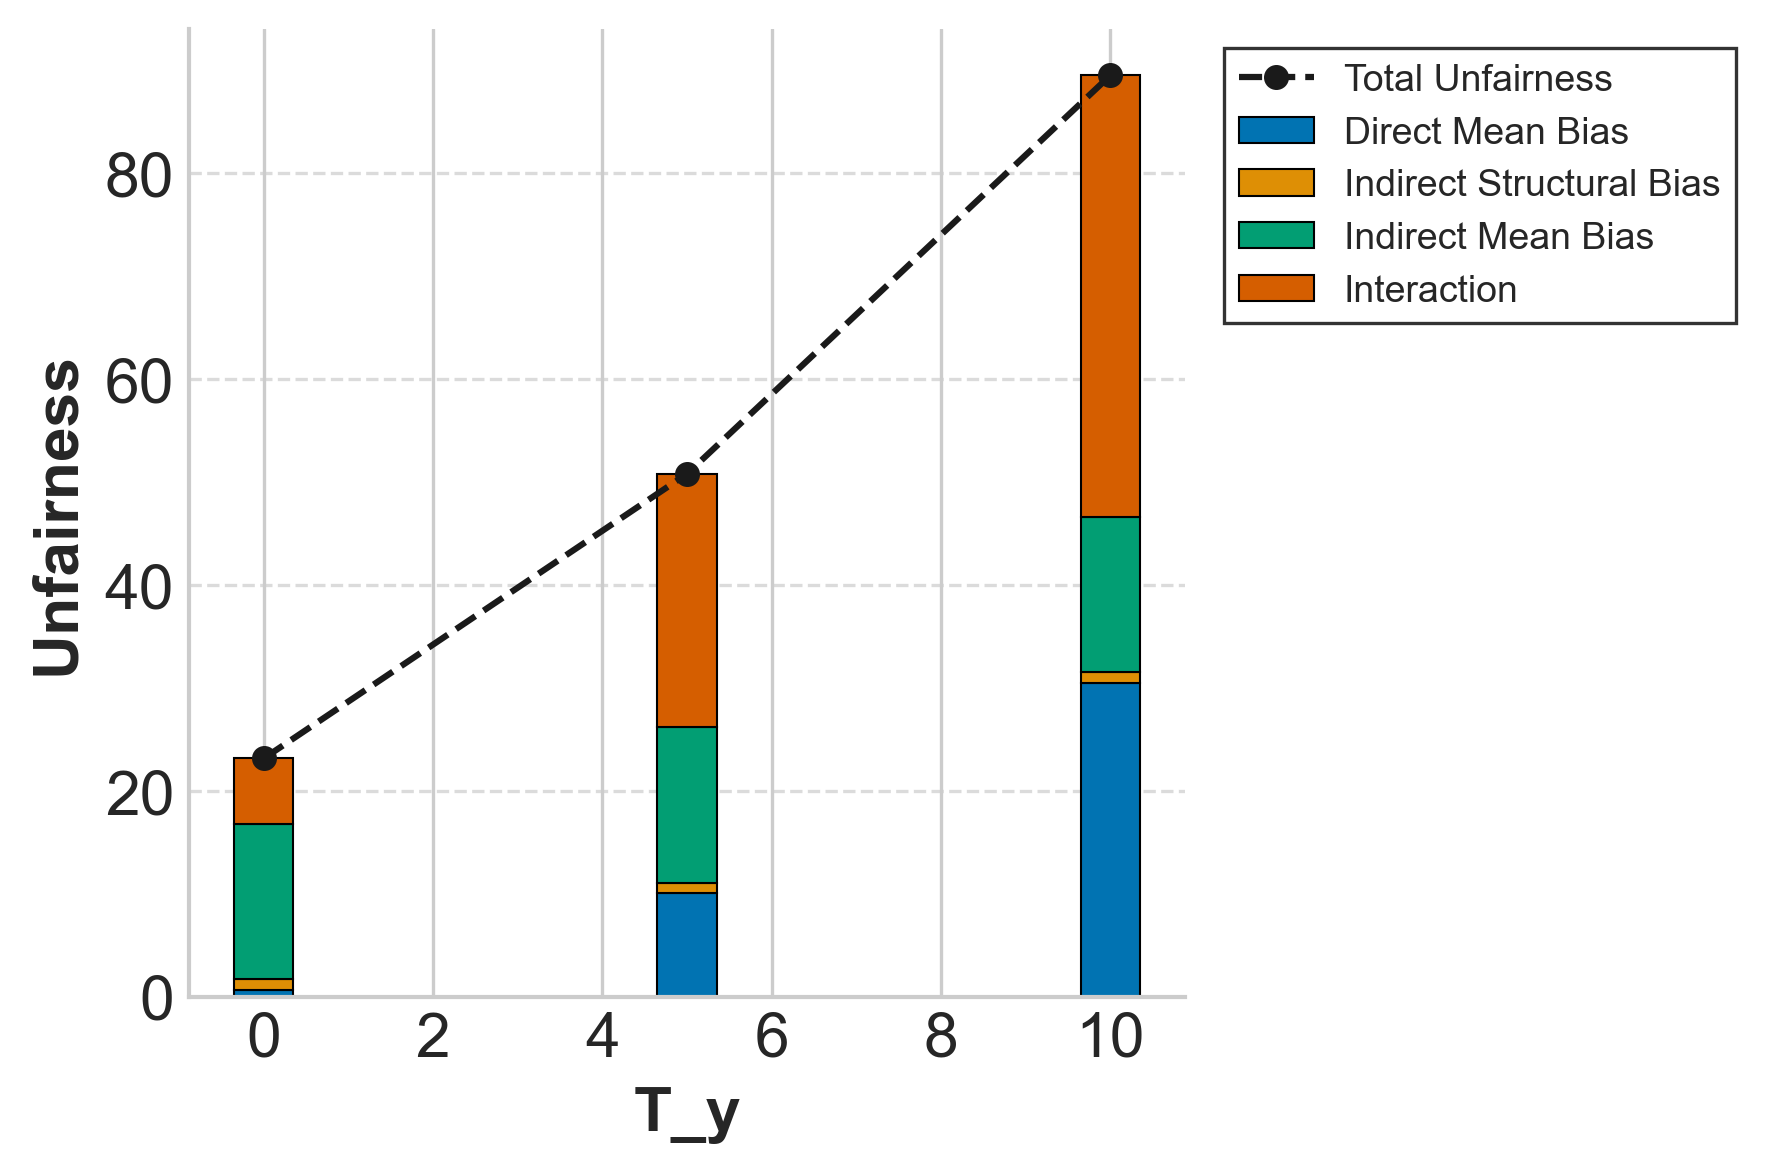

In [103]:
plot = plot_unfairness_decomposition(t_y_results, 't_unfair','T_y', 'unfairness_decomposition_T_corr.png')

In [106]:
t_corr_results, results_df_exp, test_dataset,pool_dataset, param_dictionnary=run_experiment(
    varying_param='t_correl', 
    param_values=[0,  0.45,  0.9], 
    fixed_params=all_bias_params, 
    coefficients_analysis=False,
    bool_coef=True, 
    bool_approximate_fairness=False)

Processing t_correl: 100%|██████████| 3/3 [00:27<00:00,  9.23s/it]


In [107]:
def plot_rmse_vs_unfairness(all_results, t_values, perf_metric, unf_metric):
    # Définir les modèles et leurs noms d'affichage
    models = ['y_input_reg', 'y_pred_bias', 'y_pred_riken', 'y_pred_fair']
    display_names = ['Linear model', 'CS_22', 'FS_23', 'Our model']
    
    # Définir les couleurs et marqueurs pour chaque modèle
    colors = ["#2B92C2", "#D55E00", "#8B7DAD", "#03C175"] # bleu, orange, vert, rouge
    markers = ['o', 's', '^', '*']  # cercle, carré, triangle, étoile
    
    # Créer la figure
    plt.figure(figsize=(5, 3))
    
    # Pour chaque modèle
    for i, (model, display_name) in enumerate(zip(models, display_names)):
        rmse_values = []
        unfairness_values = []
        
        # Collecter les valeurs pour chaque t
        for t in t_values:
            if t in all_results and model in all_results[t]:
                rmse = all_results[t][model].get(f'{perf_metric}_mean')
                unfairness = all_results[t][model].get(f'{unf_metric}_mean')
                
                if rmse is not None and unfairness is not None:
                    rmse_values.append(rmse)
                    unfairness_values.append(unfairness)
        
        # Tracer les points pour ce modèle
        plt.scatter(unfairness_values, rmse_values, 
                   label=display_name, 
                   color=colors[i], 
                   marker=markers[i], 
                   s=100,
                   alpha=0.8,
                   edgecolors='black',
                   linewidths=0.5)
        
        # Ajouter des annotations pour les valeurs de t
        # Ne pas ajouter d'annotations pour "Linear model" et "CS_22"
        if display_name not in ["Linear model", "CS_22"]:
            for j, t in enumerate([0]):
                if j < len(rmse_values):
                    # Offset pour "Our model" pour améliorer la visibilité
                    if display_name == "Our model":
                        x_offset = 10
                        y_offset = -5
                    else:
                        x_offset = 10
                        y_offset = -3
                        
                    plt.annotate(f"{t}", 
                               (unfairness_values[j], rmse_values[j]),
                               textcoords="offset points",
                               xytext=(x_offset, y_offset),
                               ha='center',
                               fontsize=10)
            for j, t in enumerate([0.3]):
                if j < len(rmse_values):
                    # Offset pour "Our model" pour améliorer la visibilité
                    if display_name == "Our model":
                        x_offset = 18
                        y_offset = 0
                    else:
                        x_offset = 10
                        y_offset = 5
                        
                    plt.annotate(f"{t}", 
                               (unfairness_values[j+1], rmse_values[j+1]),
                               textcoords="offset points",
                               xytext=(x_offset, y_offset),
                               ha='center',
                               fontsize=10)
                    
            for j, t in enumerate([0.6]):
                if j < len(rmse_values):
                    # Offset pour "Our model" pour améliorer la visibilité
                    if display_name == "Our model":
                        x_offset = 14
                        y_offset = -7
                    else:
                        x_offset = 10
                        y_offset = 7
                        
                    plt.annotate(f"{t}", 
                               (unfairness_values[j+2], rmse_values[j+2]),
                               textcoords="offset points",
                               xytext=(x_offset, y_offset),
                               ha='center',
                               fontsize=10)
            for j, t in enumerate([0.9]):
                if display_name == "Our model":
                        x_offset = 18
                        y_offset = -2
                else:
                        x_offset = 13
                        y_offset = 5
                        
                plt.annotate(f"T={t}", 
                               (unfairness_values[3], rmse_values[3]),
                               textcoords="offset points",
                               xytext=(x_offset, y_offset),
                               ha='center',
                               fontsize=10)
    
    # Ajouter des titres et des étiquettes
    # plt.title( , fontsize=14)
    plt.xlabel('Unfairness', fontsize=12)
    plt.ylabel(f'{perf_metric}', fontsize=12)
    
    # Ajouter une légende
    plt.legend(title='Models', loc='best', frameon=True)
    
    # Ajouter une grille
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Ajuster les limites des axes si nécessaire
    # plt.xlim(0, max_unfairness * 1.1)
    # plt.ylim(min_r2 * 0.9, 1.0)
    
    plt.tight_layout()
    
    return plt.gcf()


In [ ]:
# plot = plot_rmse_vs_unfairness(t_corr_results, [0,  0.3,  0.6,  0.9], 'GWR2','ks_stat')

In [ ]:
all_bias_params

{'y': 'Y',
 'S_variable': 'S',
 'additional_s': 0,
 'tho': 0.6,
 'nb_features': 5,
 'nb_obs': 20000,
 'n_simulations': 1,
 'random_seed': 7,
 't_unfair': 3,
 't_correl': 0.7,
 'p_mu_bias': 2,
 'p_sigma_bias': 2}

In [ ]:
t_std_results, results_df_exp, test_dataset,pool_dataset, param_dictionnary=run_experiment(
    varying_param='p_sigma_bias', 
    param_values=[1,25,50], 
    fixed_params=all_bias_params, 
    coefficients_analysis=False,
    bool_coef=True, 
    bool_approximate_fairness=False)

Processing p_sigma_bias: 100%|██████████| 3/3 [00:33<00:00, 11.31s/it]


In [ ]:
# plot = plot_rmse_vs_unfairness(t_std_results, [0, 0.5, 1, 1.5, 2, 2.5,3,3.5,4,4.5,5], 'GWR2')

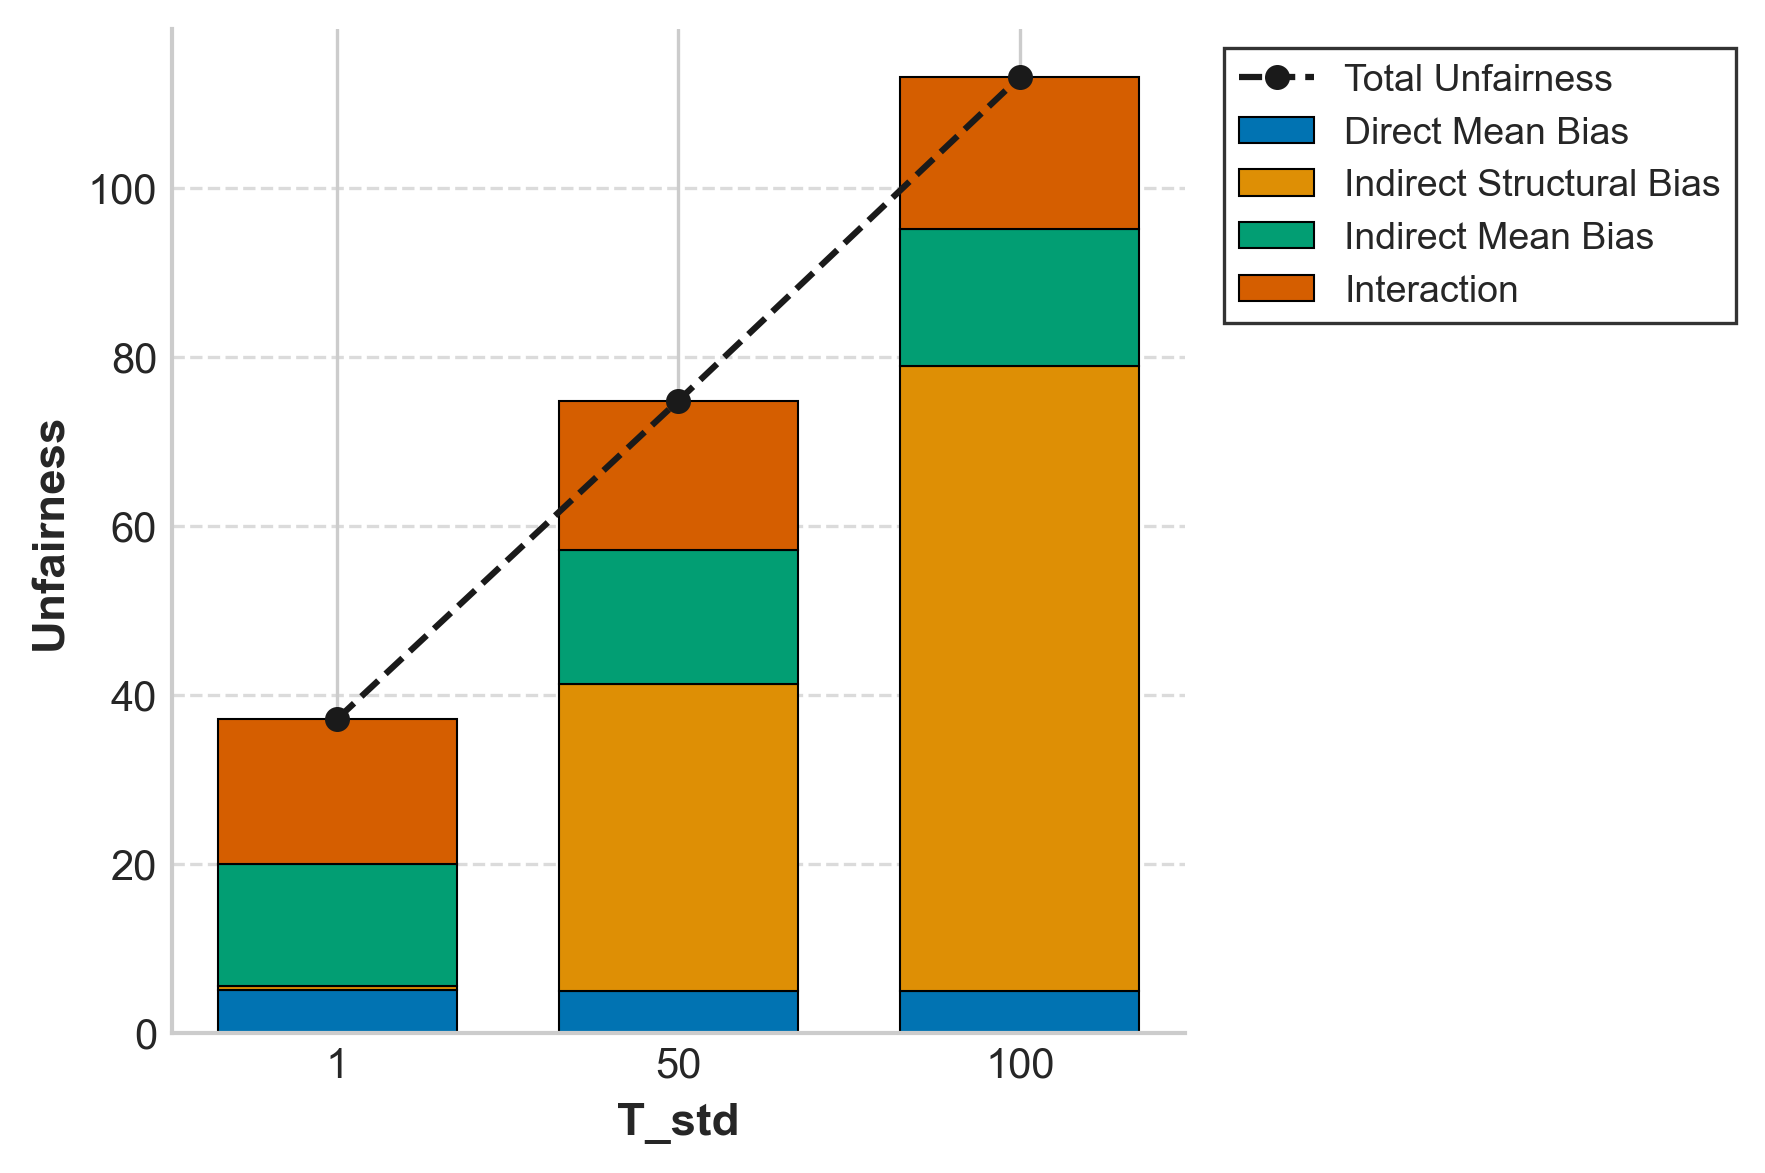

In [ ]:
plot = plot_unfairness_decomposition(t_std_results, 'p_sigma_bias','T_std', 'unfairness_decomposition_T_std.png')

In [ ]:
t_mu_results, results_df_exp, test_dataset,pool_dataset, param_dictionnary=run_experiment(
    varying_param='p_mu_bias', 
    param_values=[0,2,4], 
    fixed_params=all_bias_params, 
    coefficients_analysis=False,
    bool_coef=True, 
    bool_approximate_fairness=False)

# plot = plot_rmse_vs_unfairness(t_mu_results, [1,2,3,4,5,6,7], 'GWR2')

Processing p_mu_bias: 100%|██████████| 3/3 [00:12<00:00,  4.33s/it]


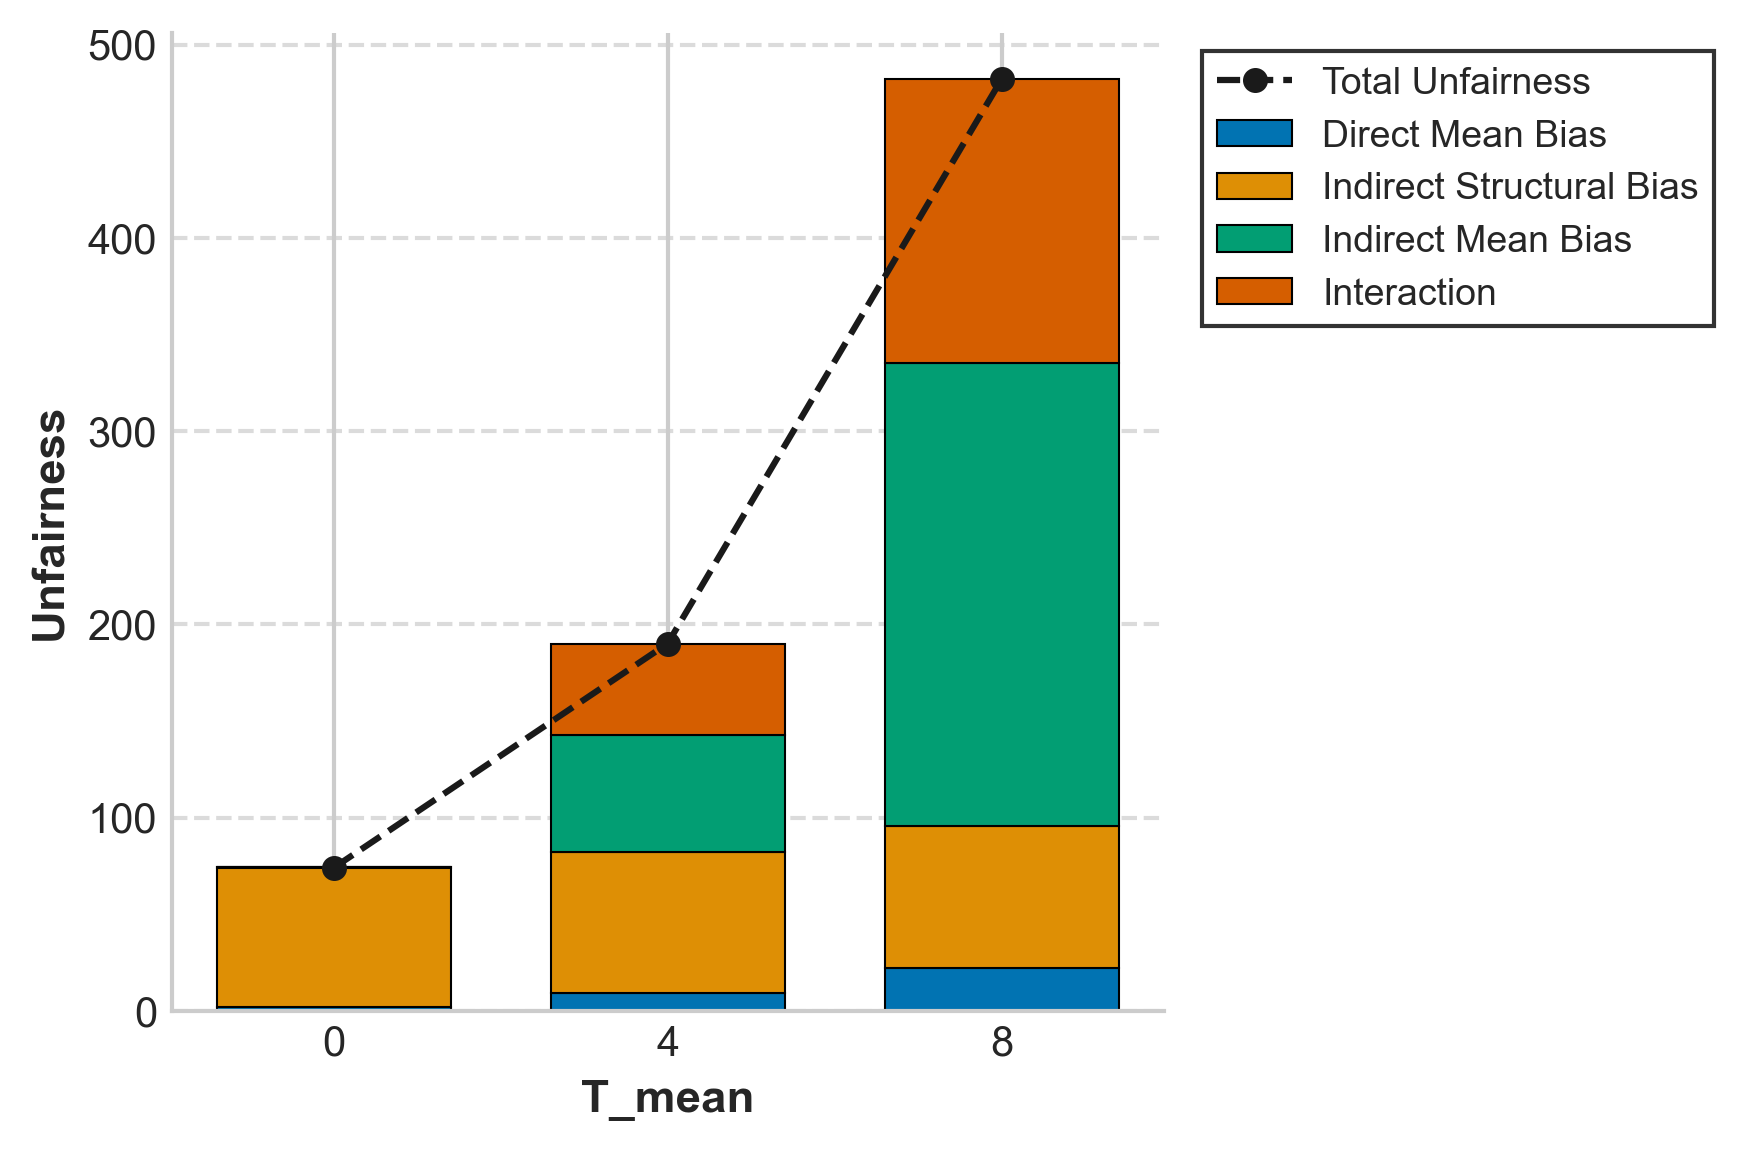

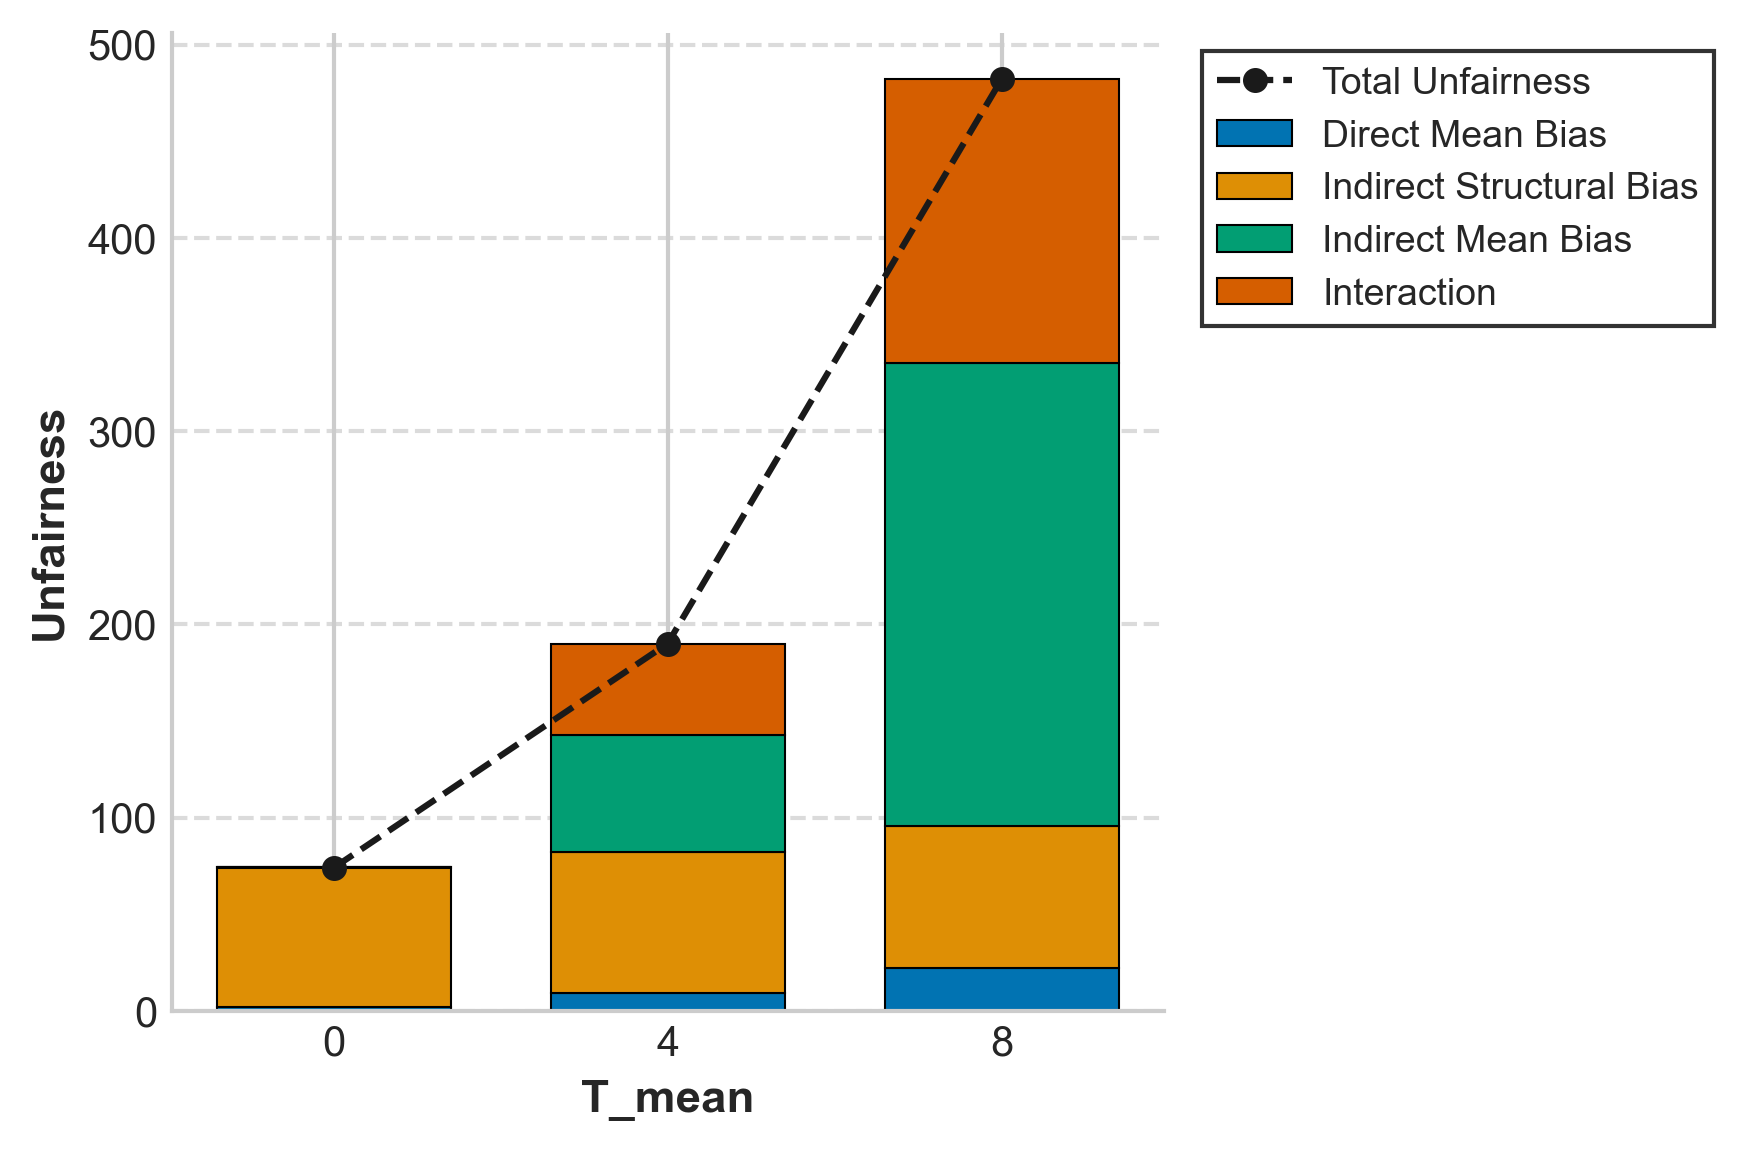

In [ ]:
plot_unfairness_decomposition(t_mu_results, 'p_mu_bias','T_mean', 'unfairness_decomposition_T_mean.png')

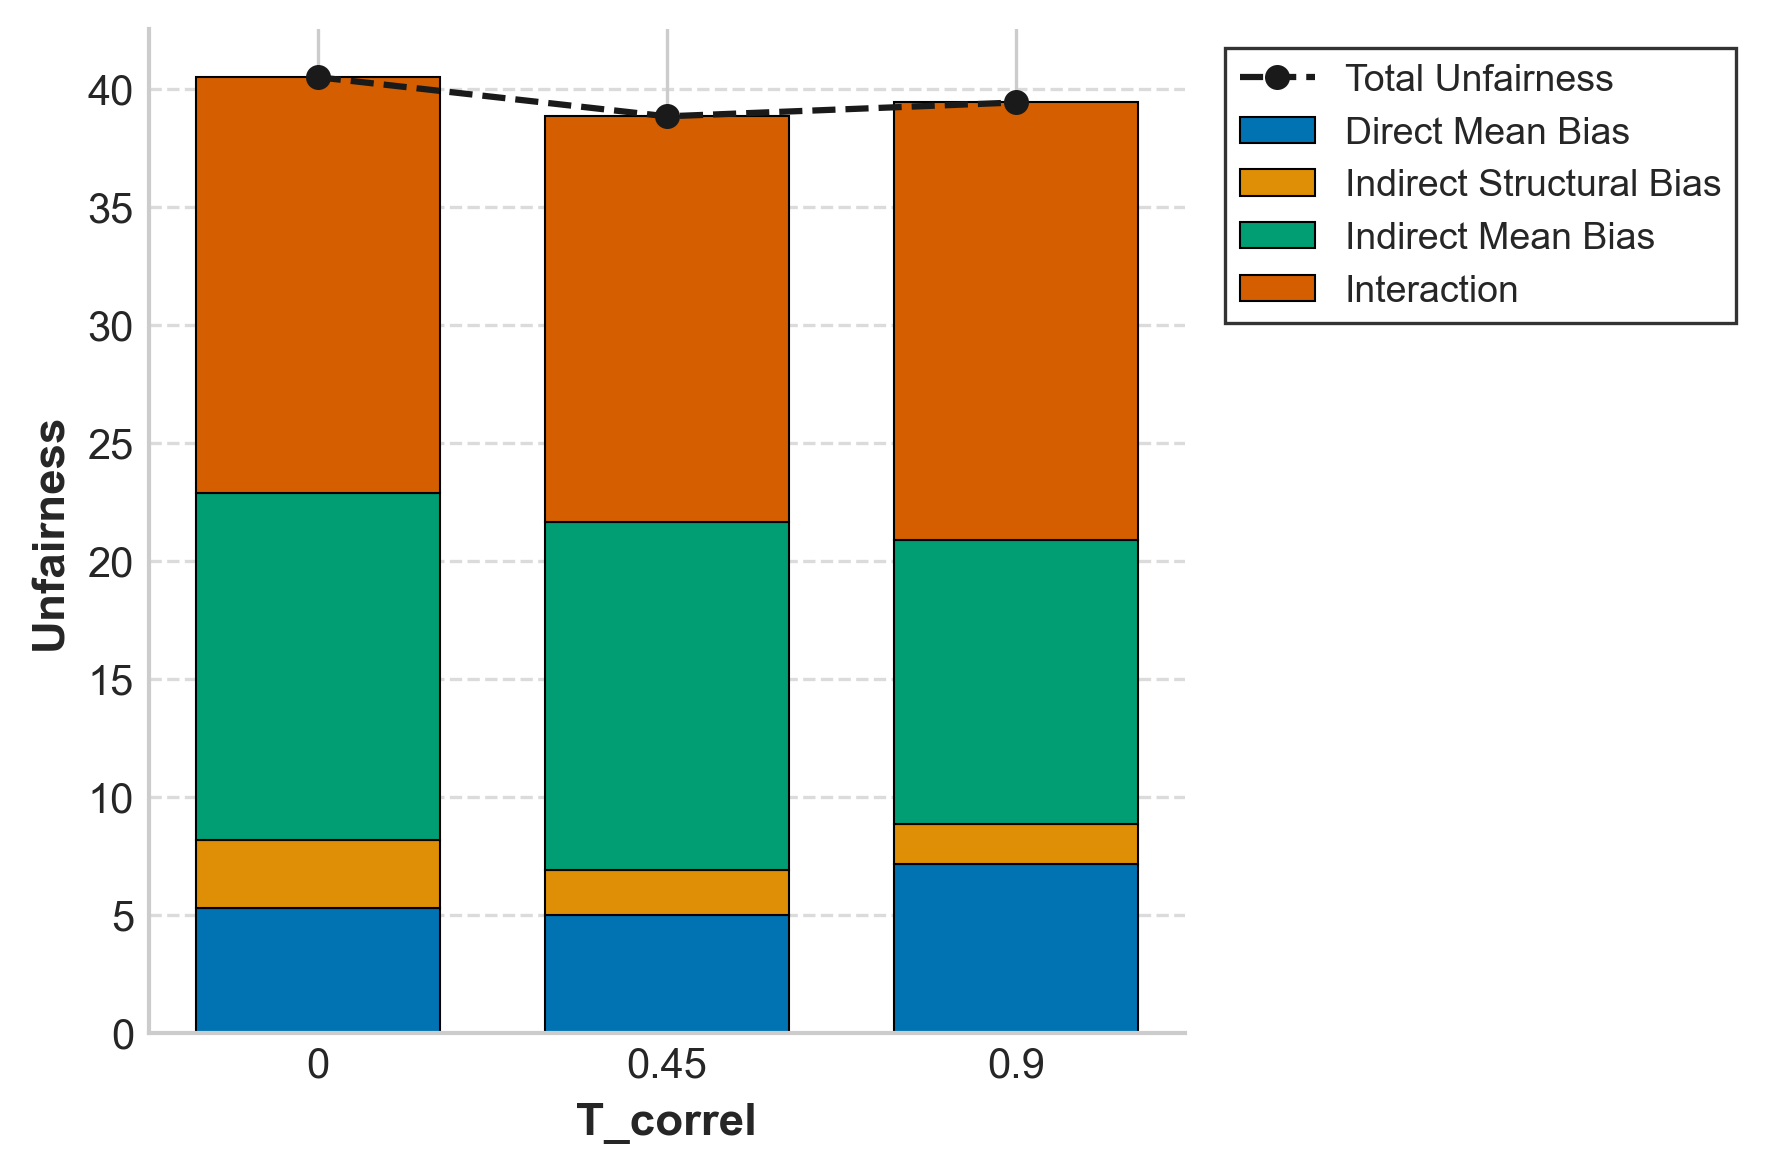

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

def plot_unfairness_decomposition(results_dict, param_name,param_name_legend, output_file, figsize=(6, 4), dpi=300):
    """
    Plot unfairness decomposition as stacked bars for varying parameter values.
    
    Parameters:
    -----------
    results_dict : dict
        Dictionary with results for each parameter value
    param_name : str
        Name of the parameter that varies (e.g., 'T_correl')
    output_file : str
        Path to save the output figure
    figsize : tuple
        Figure size (width, height) in inches
    dpi : int
        Resolution for the saved figure
    """
    # Set style for scientific publication
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Use colorblind palette
    palette = sns.color_palette("colorblind")
    
    # Create figure with higher quality settings
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Extract parameter values and prepare data
    param_values = sorted(results_dict.keys())
    
    # Components to plot
    components = ['direct_mean_bias_mean', 'indirect_structural_bias_mean', 'indirect_mean_bias_mean', 'interaction_mean']
    component_labels = ['Direct Mean Bias', 'Indirect Structural Bias', 'Indirect Mean Bias', 'Interaction']
    
    # Create data structure for plotting
    data = []
    for param_val in param_values:
        result = results_dict[param_val]['y_input_reg']
        row = [param_val]
        for comp in components:
            row.append(result[comp])
        data.append(row)
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=[param_name] + components)
    
    # Use integer positions for bars, but label with actual parameter values
    x_positions = np.arange(len(param_values))
    
    # Set width of bars
    bar_width = 0.7
    
    # Plot stacked bars
    bottom = np.zeros(len(param_values))
    for i, comp in enumerate(components):
        values = df[comp].values
        ax.bar(x_positions, values, bottom=bottom, width=bar_width,
               label=component_labels[i], color=palette[i], 
               edgecolor='black', linewidth=0.5)
        bottom += values
    
    # Add total unfairness as a line
    df['total'] = df[components].sum(axis=1)
    ax.plot(x_positions, df['total'], 'k--', marker='o', markersize=5, 
            linewidth=1.5, label='Total Unfairness')
    
    # Set x-ticks to parameter values
    ax.set_xticks(x_positions)
    ax.set_xticklabels([str(val) for val in param_values])
    
    # Customize plot for scientific publication
    ax.set_xlabel(f'{param_name_legend}', fontsize=11, fontweight='bold')
    ax.set_ylabel('Unfairness', fontsize=11, fontweight='bold')
    ax.tick_params(axis='both', labelsize=10)
    
    # Add grid only for y-axis
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend with clear formatting
    legend = ax.legend(fontsize=9, frameon=True, fancybox=False, 
                      edgecolor='black', ncol=1, loc='upper left', 
                      bbox_to_anchor=(1.02, 1))
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(output_file, bbox_inches='tight')
    
    return fig

plot = plot_unfairness_decomposition(t_corr_results, 't_correl','T_correl', 'unfairness_decomposition_T_corr.png')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D

def plot_multiple_unfairness_decompositions(results_dicts, param_names, param_legends, output_file, figsize=(12, 4), dpi=300):
    """
    Plot multiple unfairness decompositions as stacked bars in a single row with shared legend.
    
    Parameters:
    -----------
    results_dicts : list of dict
        List of dictionaries with results for each parameter
    param_names : list of str
        Names of the parameters that vary
    param_legends : list of str
        Display names for the parameters on x-axis
    output_file : str
        Path to save the output figure
    figsize : tuple
        Figure size (width, height) in inches
    dpi : int
        Resolution for the saved figure
    """
    # Set style for scientific publication
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Use colorblind palette
    palette = sns.color_palette("colorblind")
    
    # Components to plot
    components = ['direct_mean_bias_mean', 'indirect_structural_bias_mean', 'indirect_mean_bias_mean', 'interaction_mean']
    component_labels = ['Direct Mean Bias', 'Indirect Structural Bias', 'Indirect Mean Bias', 'Interaction']
    
    # Create figure with subplots - add space at top for legend
    fig, axes = plt.subplots(1, len(results_dicts), figsize=figsize, dpi=dpi, sharey=True)
    
    # Store handles for legend
    legend_handles = []
    legend_labels = []
    
    # Process each subplot
    for idx, (results_dict, param_name, param_legend, ax) in enumerate(zip(results_dicts, param_names, param_legends, axes)):
        # Extract parameter values and prepare data
        param_values = sorted(results_dict.keys())
        
        # Create data structure for plotting
        data = []
        for param_val in param_values:
            result = results_dict[param_val]['y_input_reg']
            row = [param_val]
            for comp in components:
                row.append(result[comp])
            data.append(row)
        
        # Convert to DataFrame
        df = pd.DataFrame(data, columns=[param_name] + components)
        
        # Use integer positions for bars, but label with actual parameter values
        x_positions = np.arange(len(param_values))
        
        # Set width of bars
        bar_width = 0.7
        
        # Plot stacked bars
        bottom = np.zeros(len(param_values))
        for i, comp in enumerate(components):
            values = df[comp].values
            bars = ax.bar(x_positions, values, bottom=bottom, width=bar_width,
                   label=component_labels[i] if idx == 0 else "", color=palette[i], 
                   edgecolor='black', linewidth=0.5)
            bottom += values
            
            # Store handles for first subplot only (for legend)
            if idx == 0:
                legend_handles.append(bars)
                legend_labels.append(component_labels[i])
        
        # Add total unfairness as a line
        df['total'] = df[components].sum(axis=1)
        line = ax.plot(x_positions, df['total'], 'k--', marker='o', markersize=5, 
                linewidth=1.5, label='Total Unfairness' if idx == 0 else "")
        
        if idx == 0:
            legend_handles.append(line[0])
            legend_labels.append('Total Unfairness')
        
        # Set x-ticks to parameter values
        ax.set_xticks(x_positions)
        ax.set_xticklabels([str(val) for val in param_values], fontsize=11)
        
        # Customize plot for scientific publication
        ax.set_xlabel(f'{param_legend}', fontsize=15, fontweight='bold')
        if idx == 0:
            ax.set_ylabel('Unfairness', fontsize=15, fontweight='bold')
        ax.tick_params(axis='both', labelsize=15)
        
        # Add grid only for y-axis
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    # Add a single legend at the top
    fig.legend(legend_handles, legend_labels, 
               loc='upper center', bbox_to_anchor=(0.5, 1.05),
               ncol=5, fontsize=14, frameon=True, fancybox=False, 
               edgecolor='black')
    
    # Adjust layout with minimal space between legend and plots
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust this value to control space between legend and plots
    
    # Save figure
    plt.savefig(output_file, bbox_inches='tight')
    
    return fig

# Example usage:
# plot_multiple_unfairness_decompositions(
#     [t_y_results, t_mu_results, t_std_results, t_corr_results],
#     ['t_unfair', 'p_mu_bias', 'p_sigma_bias', 't_correl'],
#     ['T_y', 'T_mean', 'T_std', 'T_correl'],
#     'unfairness_decomposition_combined.png'
# )


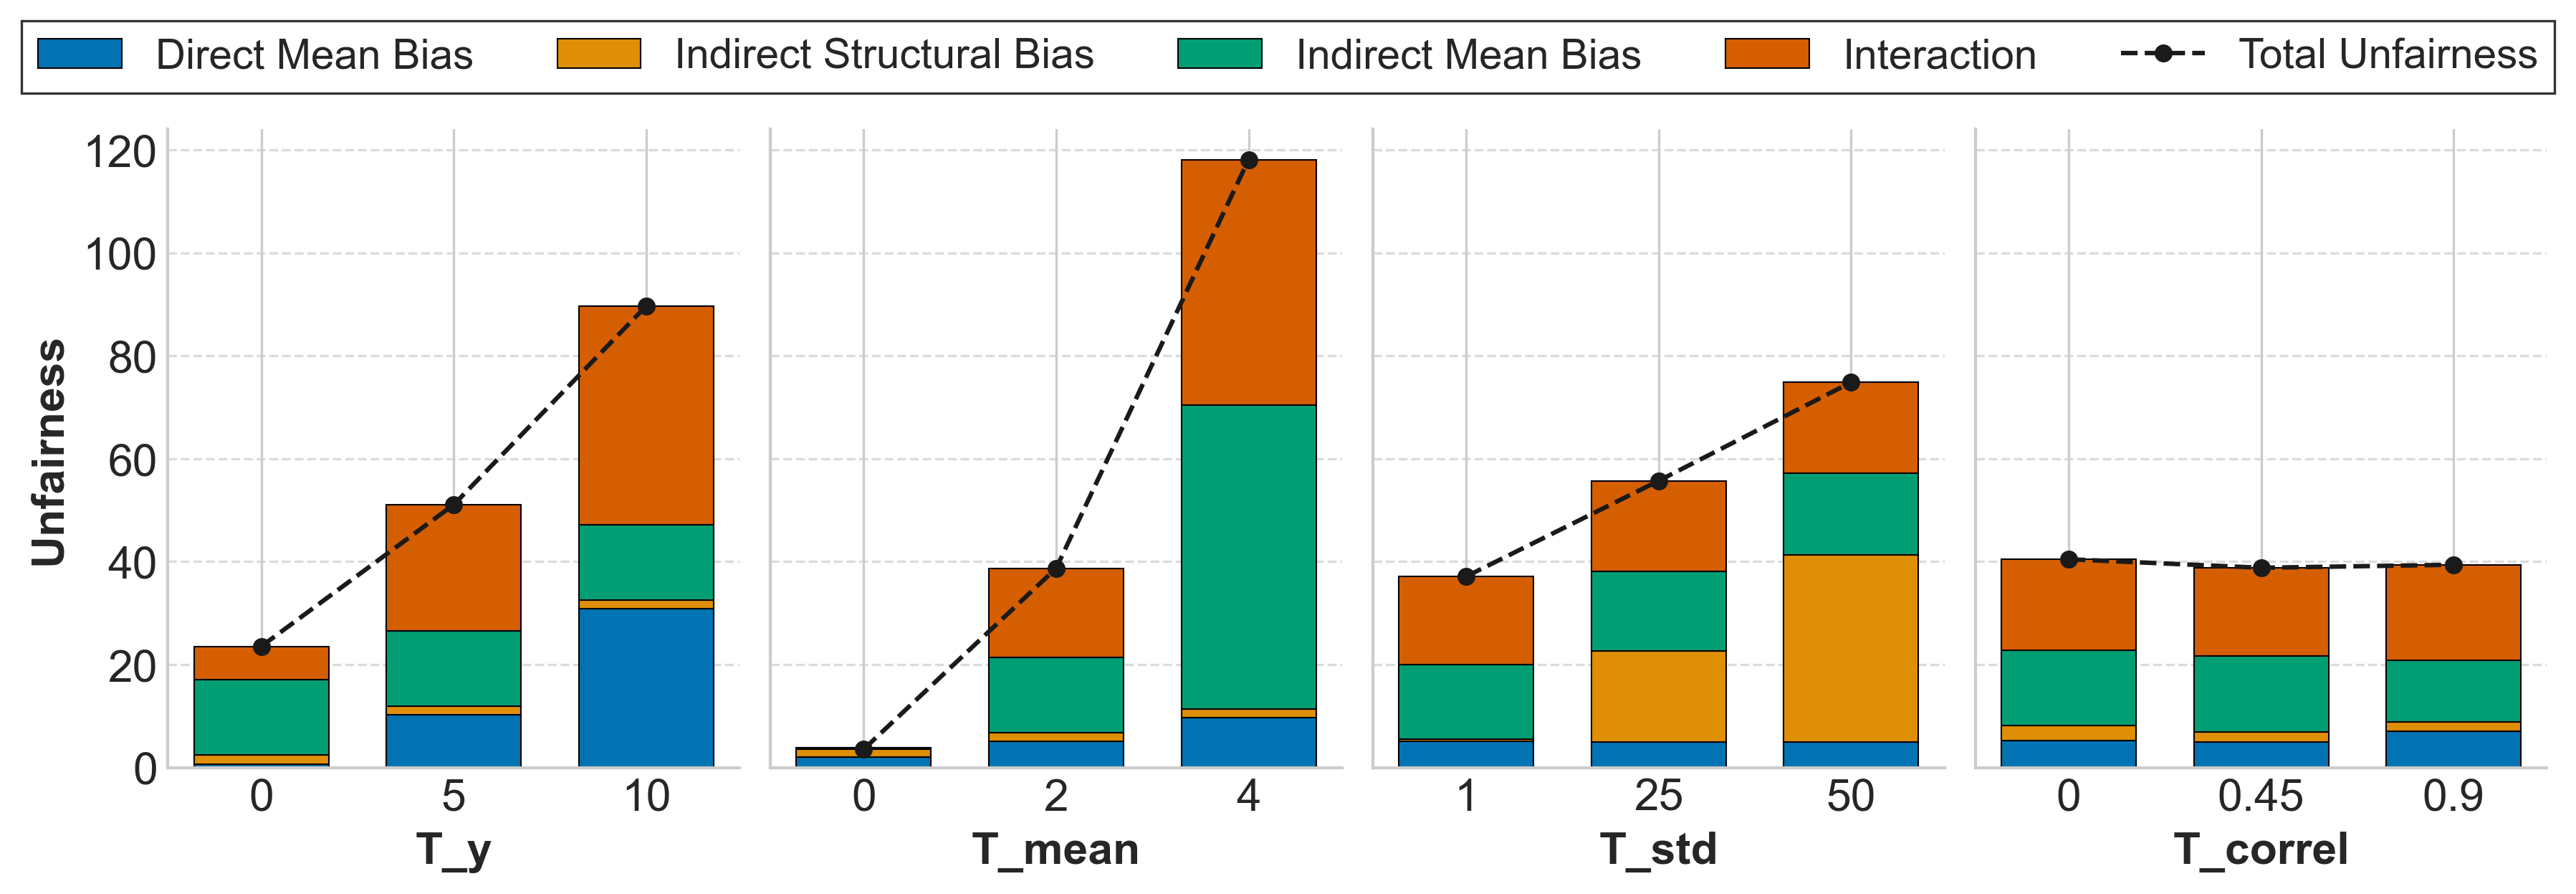

In [ ]:
# Créer la figure combinée
plot = plot_multiple_unfairness_decompositions(
    [t_y_results, t_mu_results, t_std_results, t_corr_results],
    ['t_unfair', 'p_mu_bias', 'p_sigma_bias', 't_correl'],
    ['T_y', 'T_mean', 'T_std', 'T_correl'],
    'unfairness_decomposition_combined.png'
)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D

def plot_multiple_unfairness_decompositions(results_dicts, param_names, param_legends, output_file, figsize=(17, 4), dpi=300):
    """
    Plot multiple unfairness decompositions as stacked bars in a single row with shared legend.
    
    Parameters:
    -----------
    results_dicts : list of dict
        List of dictionaries with results for each parameter
    param_names : list of str
        Names of the parameters that vary
    param_legends : list of str
        Display names for the parameters on x-axis
    output_file : str
        Path to save the output figure
    figsize : tuple
        Figure size (width, height) in inches
    dpi : int
        Resolution for the saved figure
    """
    # Set style for scientific publication
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Disable LaTeX and use matplotlib's built-in math renderer
    plt.rcParams['text.usetex'] = False
    plt.rcParams['mathtext.default'] = 'regular'
    
    # Use colorblind palette
    palette = sns.color_palette("colorblind")
    
    # Components to plot
    components = ['direct_mean_bias_mean', 'indirect_structural_bias_mean', 'indirect_mean_bias_mean', 'interaction_mean']
    component_labels = ['Direct Mean Bias', 'Indirect Structural Bias', 'Indirect Mean Bias', 'Interaction']
    
    # Create figure with subplots - add space at top for legend
    fig, axes = plt.subplots(1, len(results_dicts), figsize=figsize, dpi=dpi, sharey=True)
    
    # Store handles for legend
    legend_handles = []
    legend_labels = []
    
    # Process each subplot
    for idx, (results_dict, param_name, param_legend, ax) in enumerate(zip(results_dicts, param_names, param_legends, axes)):
        # Extract parameter values and prepare data
        param_values = sorted(results_dict.keys())
        
        # Create data structure for plotting
        data = []
        for param_val in param_values:
            result = results_dict[param_val]['y_input_reg']
            row = [param_val]
            for comp in components:
                row.append(result[comp])
            data.append(row)
        
        # Convert to DataFrame
        df = pd.DataFrame(data, columns=[param_name] + components)
        
        # Use integer positions for bars, but label with actual parameter values
        x_positions = np.arange(len(param_values))
        
        # Set width of bars
        bar_width = 0.7
        
        # Plot stacked bars
        bottom = np.zeros(len(param_values))
        for i, comp in enumerate(components):
            values = df[comp].values
            bars = ax.bar(x_positions, values, bottom=bottom, width=bar_width,
                   label=component_labels[i] if idx == 0 else "", color=palette[i], 
                   edgecolor='black', linewidth=0.5)
            bottom += values
            
            # Store handles for first subplot only (for legend)
            if idx == 0:
                legend_handles.append(bars)
                legend_labels.append(component_labels[i])
        
        # Add total unfairness as a line
        df['total'] = df[components].sum(axis=1)
        line = ax.plot(x_positions, df['total'], 'k--', marker='o', markersize=5, 
                linewidth=1.5, label='Total Unfairness' if idx == 0 else "")
        
        if idx == 0:
            legend_handles.append(line[0])
            legend_labels.append('Total Unfairness')
        
        # Set x-ticks to parameter values
        ax.set_xticks(x_positions)
        ax.set_xticklabels([str(val) for val in param_values], fontsize=15)
        
        # Customize plot for scientific publication
        ax.set_xlabel(f'{param_legend}', fontsize=18)
        if idx == 0:
            ax.set_ylabel('Unfairness', fontsize=18, fontweight='bold')
        ax.tick_params(axis='both', labelsize=18)
        
        # Add grid only for y-axis
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Add a single legend at the top
    fig.legend(legend_handles, legend_labels, 
               loc='upper center', bbox_to_anchor=(0.5, 1.05),
               ncol=5, fontsize=20, frameon=True, fancybox=False, 
               edgecolor='black')
    
    # Adjust layout with minimal space between legend and plots
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust this value to control space between legend and plots
    
    # Save figure
    plt.savefig(output_file, bbox_inches='tight')
    
    return fig

# Example usage with LaTeX formatting:
# plot_multiple_unfairness_decompositions(
#     [t_y_results, t_mu_results, t_std_results, t_corr_results],
#     ['t_unfair', 'p_mu_bias', 'p_sigma_bias', 't_correl'],
#     [r'$T_y$', r'$T_{\mathrm{mean}}$', r'$T_{\mathrm{std}}$', r'$T_{\mathrm{corr}}$'],
#     'unfairness_decomposition_combined.png'
# )

In [ ]:
all_bias_params

{'y': 'Y',
 'S_variable': 'S',
 'additional_s': 0,
 'tho': 0.6,
 'nb_features': 5,
 'nb_obs': 20000,
 'n_simulations': 1,
 'random_seed': 7,
 't_unfair': 3,
 't_correl': 0.7,
 'p_mu_bias': 2,
 'p_sigma_bias': 3}

In [ ]:
all_bias_params_values

[10]

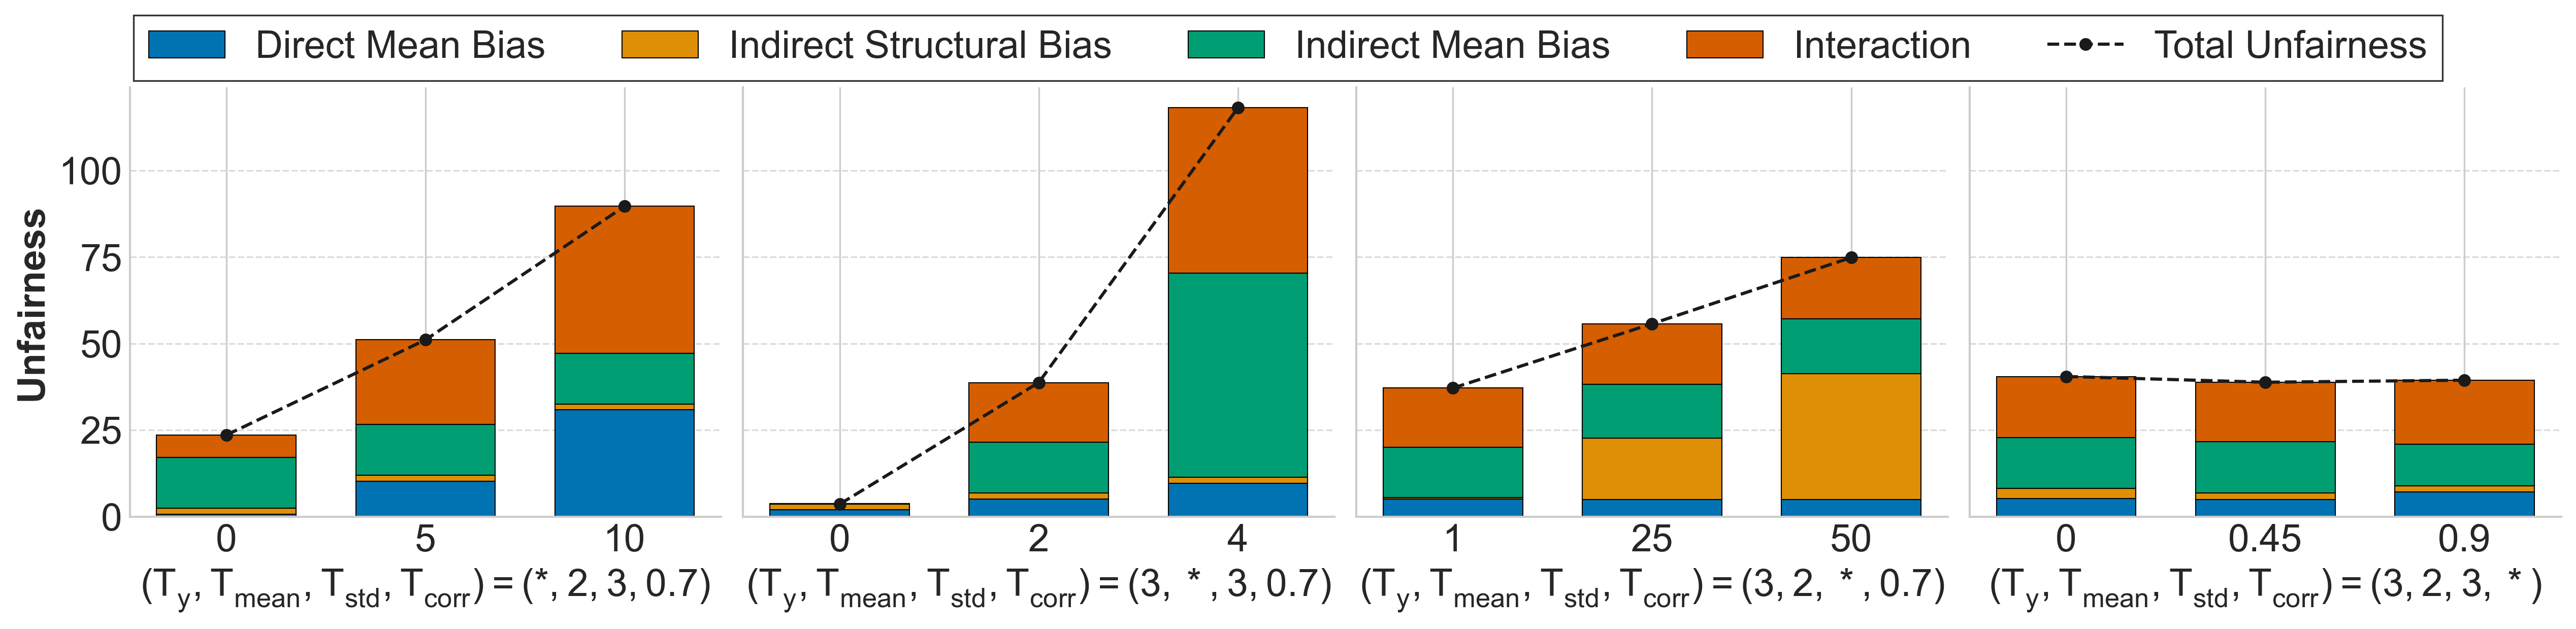

In [ ]:
# Créer la figure combinée avec le rendu mathématique
plot = plot_multiple_unfairness_decompositions(
    [t_y_results, t_mu_results, t_std_results, t_corr_results],
    ['t_unfair', 'p_mu_bias', 'p_sigma_bias', 't_correl'],
    [r'$(T_y,T_{mean},T_{std},T_{corr})=(*,2,3,0.7)$', r'$(T_y,T_{mean},T_{std},T_{corr})=(3,*,3,0.7)$', r'$(T_y,T_{mean},T_{std},T_{corr})=(3,2,*,0.7)$', r'$(T_y,T_{mean},T_{std},T_{corr})=(3,2,3,*)$'],
    'unfairness_decomposition_combined.png'
)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D

def plot_multiple_unfairness_decompositions(results_dicts, param_names, param_legends, output_file, figsize=(17, 4), dpi=300):
    """
    Plot multiple unfairness decompositions as stacked bars in a single row with shared legend.
    
    Parameters:
    -----------
    results_dicts : list of dict
        List of dictionaries with results for each parameter
    param_names : list of str
        Names of the parameters that vary
    param_legends : list of str
        Display names for the parameters on x-axis
    output_file : str
        Path to save the output figure
    figsize : tuple
        Figure size (width, height) in inches
    dpi : int
        Resolution for the saved figure
    """
    # Set style for scientific publication
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Disable LaTeX and use matplotlib's built-in math renderer
    plt.rcParams['text.usetex'] = False
    plt.rcParams['mathtext.default'] = 'regular'
    
    # Use colorblind palette
    palette = sns.color_palette("colorblind")
    
    # Components to plot
    components = ['direct_mean_bias_mean', 'indirect_structural_bias_mean', 'indirect_mean_bias_mean', 'interaction_mean']
    component_labels = ['Direct Mean Bias', 'Indirect Structural Bias', 'Indirect Mean Bias', 'Interaction']
    
    # Create figure with subplots - add space at top for legend
    fig, axes = plt.subplots(1, len(results_dicts), figsize=figsize, dpi=dpi, sharey=True)
    
    # Store handles for legend
    legend_handles = []
    legend_labels = []
    
    # Process each subplot
    for idx, (results_dict, param_name, param_legend, ax) in enumerate(zip(results_dicts, param_names, param_legends, axes)):
        # Extract parameter values and prepare data
        param_values = sorted(results_dict.keys())
        
        # Create data structure for plotting
        data = []
        for param_val in param_values:
            result = results_dict[param_val]['y_input_reg']
            row = [param_val]
            for comp in components:
                row.append(result[comp])
            data.append(row)
        
        # Convert to DataFrame
        df = pd.DataFrame(data, columns=[param_name] + components)
        
        # Use integer positions for bars, but label with actual parameter values
        x_positions = np.arange(len(param_values))
        
        # Set width of bars
        bar_width = 0.7
        
        # Plot stacked bars
        bottom = np.zeros(len(param_values))
        for i, comp in enumerate(components):
            values = df[comp].values
            bars = ax.bar(x_positions, values, bottom=bottom, width=bar_width,
                   label=component_labels[i] if idx == 0 else "", color=palette[i], 
                   edgecolor='black', linewidth=0.5)
            bottom += values
            
            # Store handles for first subplot only (for legend)
            if idx == 0:
                legend_handles.append(bars)
                legend_labels.append(component_labels[i])
        
        # Add total unfairness as a line
        df['total'] = df[components].sum(axis=1)
        line = ax.plot(x_positions, df['total'], 'k--', marker='o', markersize=5, 
                linewidth=1.5, label='Total Unfairness' if idx == 0 else "")
        
        if idx == 0:
            legend_handles.append(line[0])
            legend_labels.append('Total Unfairness')
        
        # Set x-ticks to parameter values with increased font size
        ax.set_xticks(x_positions)
        ax.set_xticklabels([str(val) for val in param_values], fontsize=20)  # Increased from 15 to 20
        
        # Customize plot for scientific publication with increased font sizes
        ax.set_xlabel(f'{param_legend}', fontsize=22)  # Increased from 18 to 22
        if idx == 0:
            ax.set_ylabel('Unfairness', fontsize=22, fontweight='bold')  # Increased from 18 to 22
        ax.tick_params(axis='both', labelsize=20)  # Increased from 18 to 20
        
        # Add grid only for y-axis
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Add a single legend at the top with increased font size
    fig.legend(legend_handles, legend_labels, 
               loc='upper center', bbox_to_anchor=(0.5, 1.05),
               ncol=5, fontsize=20, frameon=True, fancybox=False,  # Increased from 18 to 20
               edgecolor='black')
    
    # Adjust layout with minimal space between legend and plots
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust this value to control space between legend and plots
    
    # Save figure
    plt.savefig(output_file, bbox_inches='tight')
    
    return fig

# Example usage with LaTeX formatting:
# plot_multiple_unfairness_decompositions(
#     [t_y_results, t_mu_results, t_std_results, t_corr_results],
#     ['t_unfair', 'p_mu_bias', 'p_sigma_bias', 't_correl'],
#     [r'$T_y$', r'$T_{\mathrm{mean}}$', r'$T_{\mathrm{std}}$', r'$T_{\mathrm{corr}}$'],
#     'unfairness_decomposition_combined.png'
# )

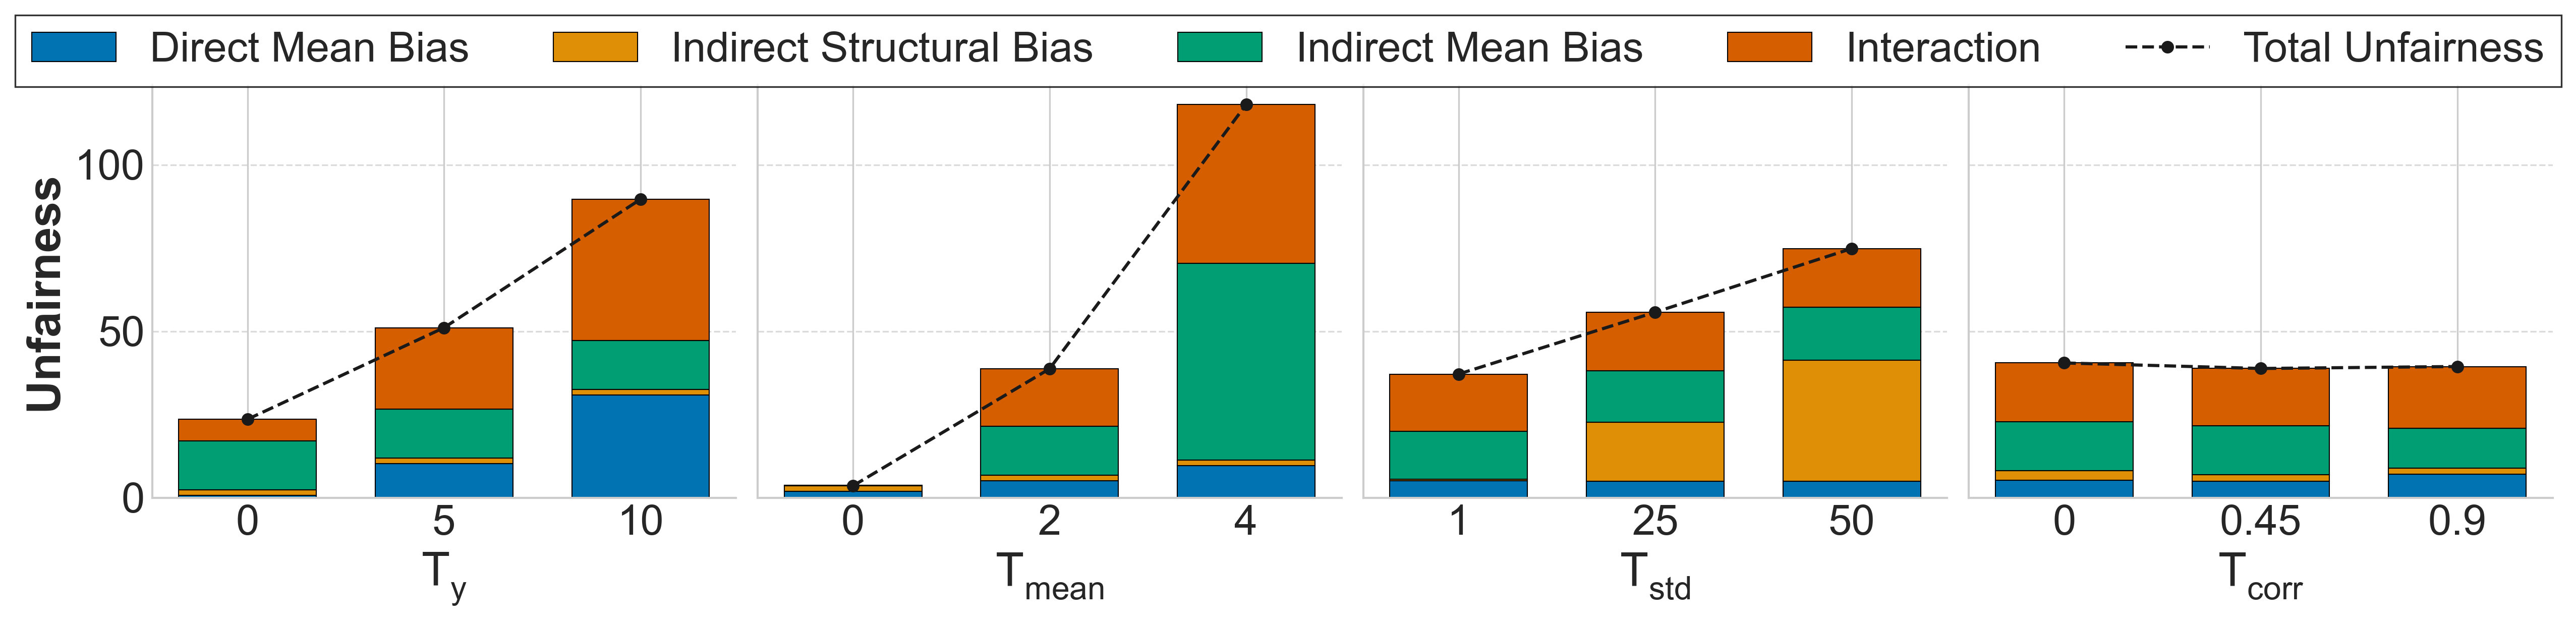

In [ ]:
# Créer la figure combinée avec le rendu mathématique
plot = plot_multiple_unfairness_decompositions(
    [t_y_results, t_mu_results, t_std_results, t_corr_results],
    ['t_unfair', 'p_mu_bias', 'p_sigma_bias', 't_correl'],
    [r'$T_y$', r'$T_{mean}$', r'$T_{std}$', r'$T_{corr}$'],
    'unfairness_decomposition_combined.png'
)

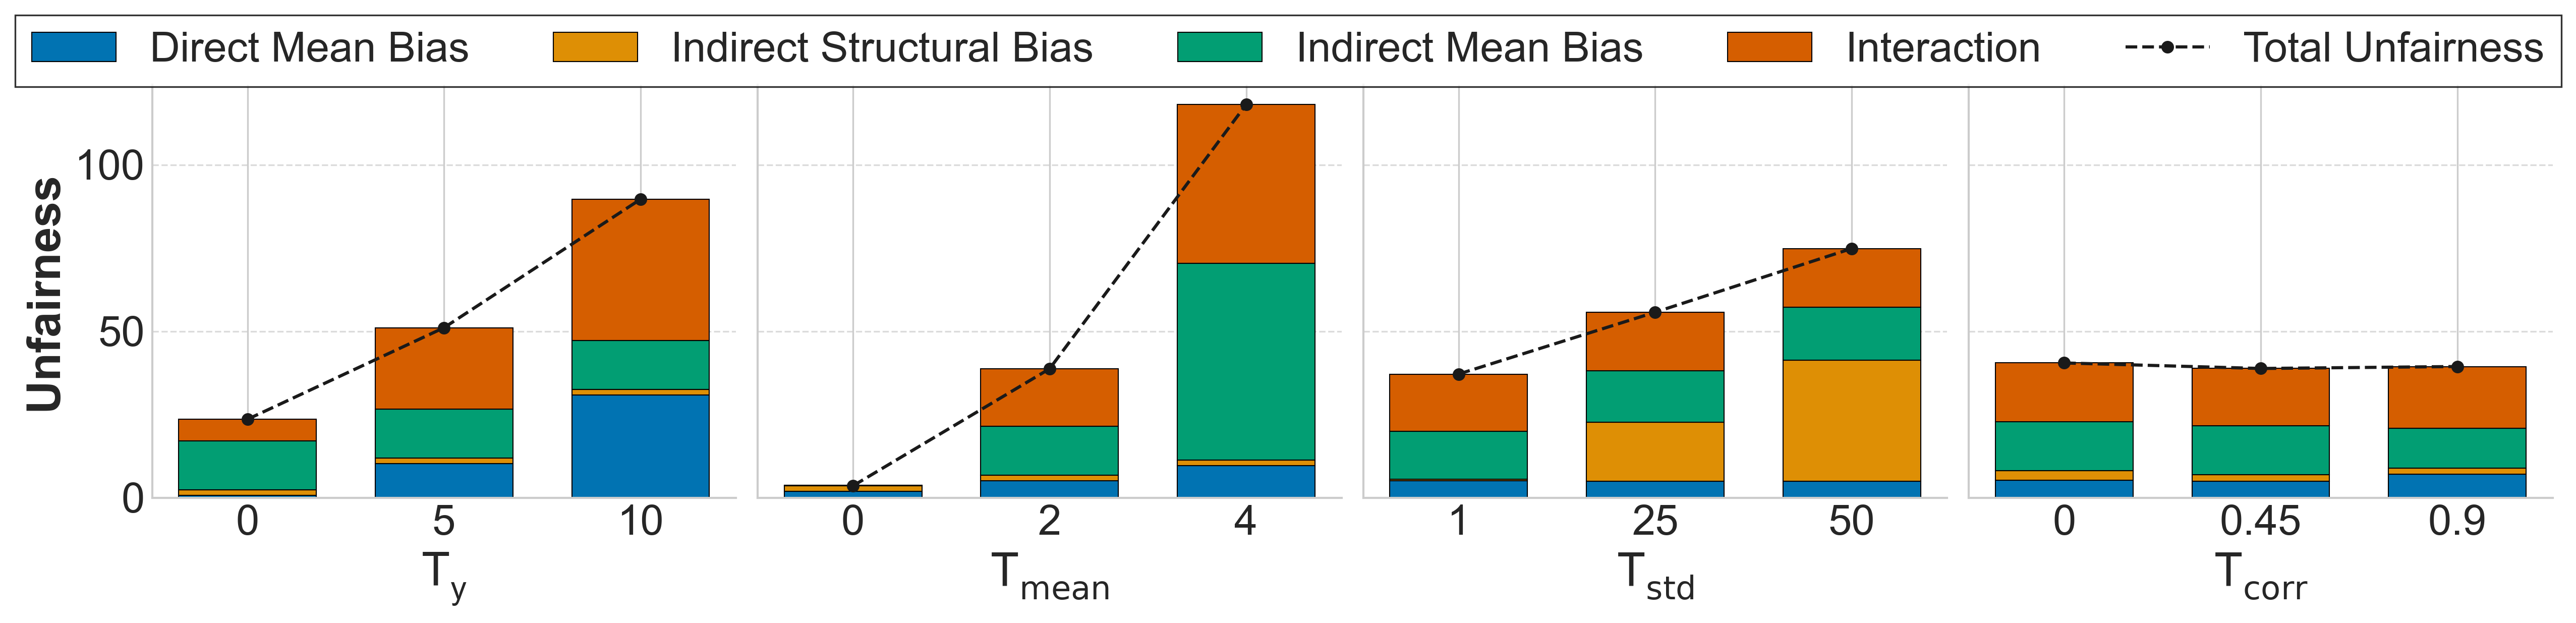

In [ ]:
# Créer la figure combinée avec le rendu mathématique amélioré
plot = plot_multiple_unfairness_decompositions(
    [t_y_results, t_mu_results, t_std_results, t_corr_results],
    ['t_unfair', 'p_mu_bias', 'p_sigma_bias', 't_correl'],
    [r'$T_y$', r'$T_{\mathrm{mean}}$', r'$T_{\mathrm{std}}$', r'$T_{\mathrm{corr}}$'],
    'unfairness_decomposition_combined.png'
)

__Unfairness__

In [ ]:
t_results_all_bias['y_pred_fair'].keys()

dict_keys(['r2', 'GWR2', 'mae', 'rmse', 'unfairness_W2', 'unfairness_W1', 'ks_stat', 'indirect_mean_bias', 'indirect_structural_bias', 'interaction', 'direct_mean_bias', 'beta_0_NoStd', 'beta_NoStd', 'gamma_NoStd', 'beta_0_1_Std', 'beta_0_2_Std', 'beta_1_Std', 'beta_2_Std', 'gamma_Std', 'fair_intercept_1_NoStd', 'fair_intercept_2_NoStd', 'beta_1_NoStd', 'beta_2_NoStd', 'fair_intercept_Std', 'beta_Std', 'riken_intercept_Std'])

In [ ]:
pd.DataFrame(calculate_marginal_contributions(test_dataset_all_bias, X_features, 'S', param_dictionnary_all_bias))

,Feature,Mean,Std,Beta_j_star,Var_mu_j,Var_sigma_j,Cov_S_mu_j,Indirect_Mean_Bias,Indirect_Structural_Bias,Interaction_Effect,Total_Marginal_Contribution
0,X_0,"[3.0317983491265723, 5.031810700324668]","[3.8158907376596223, 18.063418606112197]",0.998506,0.885259,44.924599,0.442627,0.882616,44.656742,4.320415,49.859773
1,X_1,"[1.9730552962615326, 3.849097497620818]","[1.837189290435755, 13.201938413581304]",0.999575,0.778916,28.584124,0.415191,0.778254,28.535607,4.056956,33.370816
2,X_2,"[1.9934840191947902, 4.029973983130819]","[1.028896348938819, 10.72876066339042]",1.018822,0.917846,20.822674,0.450700,0.952722,22.435166,4.488720,27.876608
3,X_3,"[2.9845909009693545, 5.092982068942032]","[0.31694779519436617, 8.180583990874666]",1.044557,0.983802,13.685227,0.466612,1.073425,16.292219,4.764588,22.130231


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_fairness_accuracy_tradeoff(results_df_exp, t_value=0):
    """
    Crée un graphique dans le style des figures de référence:
    - Fond blanc propre
    - Grille discrète
    - Style épuré et académique
    """
    
    # Filtrer pour la valeur de t spécifiée
    df_filtered = results_df_exp[results_df_exp['t'] == t_value].copy()
    
    # Style matplotlib épuré
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'sans-serif',
        'axes.linewidth': 1,
        'grid.linewidth': 0.5,
        'axes.spines.top': False,
        'axes.spines.right': False
    })
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_facecolor('white')
    
    # Palette de couleurs cohérente avec vos graphiques de référence
    colors = {
        'interpolation': '#4472C4',    # Bleu comme dans vos barres
        'our_model': '#E74C3C',        # Rouge distinctif
        'bayes': '#2E8B57',            # Vert foncé
        'cs22': '#FF8C00',             # Orange
        'fs23': '#8A2BE2'              # Violet
    }
    
    # 1. Points d'interpolation ε
    epsilon_values = np.arange(0.1, 1.0, 0.1)
    x_interp, y_interp = [], []
    
    for epsilon in epsilon_values:
        e = round(epsilon, 2)
        model_name = f'y_pref_fair_{e}'
        
        if model_name in df_filtered['model'].values:
            model_data = df_filtered[df_filtered['model'] == model_name].iloc[0]
            x_interp.append(model_data['unfairness_W2_mean'])
            y_interp.append(model_data['GWR2_mean'])
    
    # Tracer la courbe d'interpolation
    if len(x_interp) > 0:
        # Ligne continue
        ax.plot(x_interp, y_interp, color=colors['interpolation'], 
                linewidth=2, alpha=0.8, zorder=2)
        
        # Points d'interpolation
        ax.scatter(x_interp, y_interp, color=colors['interpolation'], 
                  s=60, alpha=0.9, zorder=3, edgecolors='white', linewidth=1)
    
    # 2. Modèles de référence
    reference_models = [
        ('y_pred_fair', 'Our Model', colors['our_model'], 'o'),
        ('y_input_reg', 'Bayes', colors['bayes'], 's'), 
        ('y_pred_bias', 'CS_22', colors['cs22'], '^'),
        ('y_pred_riken', 'FS_23', colors['fs23'], 'D')
    ]
    
    for model_key, label, color, marker in reference_models:
        if model_key in df_filtered['model'].values:
            model_data = df_filtered[df_filtered['model'] == model_key].iloc[0]
            x = model_data['unfairness_W2_mean']
            y = model_data['GWR2_mean']
            
            ax.scatter(x, y, color=color, s=100, marker=marker, 
                      label=label, edgecolors='white', linewidth=1.5, zorder=4)
    
    # 3. Annotations epsilon (tous les points)
    for i, (x, y) in enumerate(zip(x_interp, y_interp)):
        epsilon = round((i + 1) * 0.1, 1)
        ax.annotate(f'ε={epsilon}', (x, y), xytext=(6, 6), 
                   textcoords='offset points', fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.15", 
                            facecolor='white', alpha=0.9, 
                            edgecolor='lightgray', linewidth=0.5))
    
    # 4. Style comme vos graphiques de référence
    
    # Grille subtile comme dans vos images
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, color='gray')
    ax.set_axisbelow(True)
    
    # Labels des axes
    ax.set_xlabel('Unfairness', fontsize=14, fontweight='normal')
    ax.set_ylabel('GWR²', fontsize=14, fontweight='normal')
    
    # Titre discret (optionnel, comme dans vos graphiques)
    # ax.set_title('Accuracy-Fairness Trade-off', fontsize=14, pad=15)
    
    # Légende positionnée proprement
    legend = ax.legend(loc='best', fontsize=11, framealpha=1, 
                      fancybox=False, shadow=False, 
                      edgecolor='lightgray')
    legend.get_frame().set_linewidth(0.5)
    
    # Ajustements des marges
    ax.margins(0.05)
    
    # Spines minimales (comme dans vos graphiques)
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)
        spine.set_color('gray')
    
    # Ticks discrets
    ax.tick_params(axis='both', which='major', labelsize=11, 
                  colors='black', width=0.8, length=4)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Usage: plot_fairness_accuracy_tradeoff(results_df_exp, t_value=0)

In [ ]:
[2.9928151856167857, 5.996435332961947]

[2.9928151856167857, 5.996435332961947]

Remarques sur la base synthétique
- les coefficients du modèle de base sont connus d'avance: beta_j=1, gamma=T_y, intercept =  moyenne des Y - moyennes(X,S)*(beta,gamma)  
- revoir la variance